In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import gepard as g # NeuralModel with Dispersion relation added 
from gepard import model, fitter, plots, dvcs, bmk
import gepard.plots as gplot
from gepard.fits import GLO15new, AUTIpts, ALUIpts, GLO15b
from gepard import theory
from gepard.fitter import Fitter
from gepard import data
from gepard.data import DataSet

print('Gepard version = {}'.format(g.__version__))

Gepard version = 0.9.11b0


In [3]:
import gmaster as gm
from gmaster.fits import th_KM15, th_KM10b # need KM15 for simulated data
th15 = th_KM15
from gmaster.constants import Mp2, toTeX

In [4]:
import torch
import numpy as np 
#np.set_printoptions(legacy='1.25')
import matplotlib
import matplotlib.pyplot as plt
import shelve, logging, copy
logging.basicConfig(level=logging.ERROR) 
import pandas as pd 
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import norm

from math import sqrt
from typing import List, Union
import time

In [5]:
# Define file path
DIR = '/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/Results'
file_path = '/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests'

## Datasets

In [6]:
sys.path.append('/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/')

import mydatafiles
from mydatafiles import ep2epgamma

mydset = g.data.loaddata(mydatafiles)
mydset.update(g.data.loaddata(ep2epgamma))

In [7]:
fitpoints = g.dset[101] + g.dset[102] + g.dset[8] + mydset[182] + mydset[192] # + data.dset[81] + data.dset[94] + data.dset[95] + data.dset[96] + + GLO15b + data.dset[116] + data.dset[117] 
g.describe_data(fitpoints)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
 8 x ALU     CLAS    -1     182 arxiv.org/pdf/2211.11274
 8 x ALU     CLAS    -1     192 arxiv:2211.11274
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 172


In [8]:
Data = g.dset[101]
BSD = Data.df()  # CLAS 2015

In [9]:
# Bins can be defined as ranges within the following limiting values:
tmlims = [0, 0.13, 0.18, 0.22, 0.3, 0.4, 0.5]
xilims = [0, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.26]

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

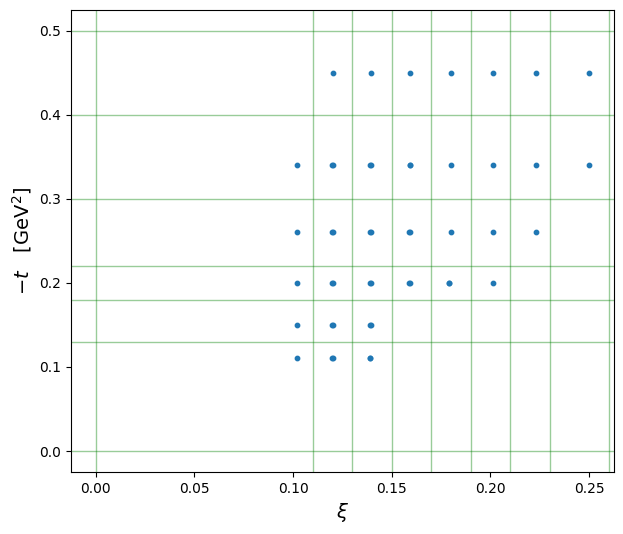

In [10]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSD.xi, BSD.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

## Neural Model

In [11]:
class Model(theory.Theory):
    """Base class for all models.

    Instance of this class specifies structure of relevant hadrons.
    Methods provided are typically GPDs, CFFs, elastic FFs,
    DVMP transition TFFs, DAs, etc.
    Main subclasses are:

     - ParameterModel which depends on real parameters (some of which can be
       provided by minimization routine in the fitting procedure).
     - NeuralModel where structure functions are represented as neural nets
       (not yet implemented)
     - GridModel where values of structure functions are represented as
       grids of numbers, which may be interpolated
       (not yet implemented)

    These are then further subclassed to model actual structure functions.

    """
    def __init__(self, **kwargs) -> None:
        self.cffs_evaluated = False  # Controls that NNet CFFs eval happens only once per predict()
        super().__init__(**kwargs)

class NeuralModel_DR(Model):
    """Model where CFFs are represented by set of neural nets. Real parts of CFFs are modeled using a dispersion relation.

    Args:
        fitpoints (data.DataSet): points to fit to
        theory (theory.Theory): theory/model to be fitted
        smear_replicas (Bool): Should we smear the replica according the uncertainties
        patience (Int): How many batches to wait for improvement before early stopping
        q2in (Bool): Should input layer be [xB, t, Q2] or only [xB, t]? Default: False.
        xpow: CFF will be modelled as CFF = xB**(xpow) * NNet. Default: 0.

    Note:
        There will be separate model where GPDs are represented by neural net.

    """

    def __init__(self, output_layer=['ImH', 'D'], **kwargs) -> None:
        self.nets = []  # here come PyTorch models [(mean, std, net), ...]
        self.allCFFs = {'ReH', 'ImH', 'ReE', 'ImE', 'ReHt', 'ImHt', 'ReEt', 'ImEt',
                        'ReHeff', 'ImHeff', 'ReEeff', 'ImEeff',
                        'ReHteff', 'ImHteff', 'ReEteff', 'ImEteff'}
        self.output_layer = output_layer
        #self.modeled_cffs = modeled_cffs #Store the CFFs which can be derived from the NN. Could be done better maybe. The Imaginary must be in the same order and the real part after
        self.cffs_map = {cff: k for k, cff in enumerate(self.output_layer)}
        self.in_training = False
        self.q2in = kwargs.setdefault('q2in', False)
        self.xpow = kwargs.setdefault('xpow', 0)
        
        
        #This is just to accomodate the DispersionCFF attributes
        self.parameters = {'dummy':0.0}
        self.parameters_fixed = {'dummy': True}
		
        if self.q2in:
            self.indim = 3
        else:
            self.indim = 2
        super().__init__(**kwargs)

    def get_standard(self, x, leave=[]):
        mean = x.mean(0, keepdim=True)
        std = x.std(0, unbiased=False, keepdim=True)
        for dim in leave:
            # we don't standardize indices e.g.
            # FIXME: if we give up on y-standardization remove this
            mean[0, dim] = 0
            std[0, dim] = 1 - 1e-7
        return mean, std

    def standardize(self, x, mean, std):
        #print("in standardize")
        #print("x ",x)
        #print("mean ",mean)
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x)
        y = x - mean
        y /= (std + 1e-7)
        return y

    def unstandardize(self, x, mean, std):
        y = x * (std + 1e-7)
        y += mean
        return y

    def build_net(self):
        '''Builds net architecture. For user to override.'''
        nn_model = torch.nn.Sequential(
                torch.nn.Linear(self.indim, 32),
                torch.nn.ReLU(),
                torch.nn.Linear(32, 64),
                torch.nn.ReLU(),
                torch.nn.Linear(64, 32),
                torch.nn.ReLU(),
                torch.nn.Linear(32, len(self.output_layer))
            )
        #optimizer = torch.optim.Rprop(nn_model.parameters(),
         #       lr=0.01)
        optimizer = torch.optim.Adam(nn_model.parameters(),
                lr=0.01)   # <- Added to test
        return nn_model, optimizer
        
    def __getattr__(self, name):
        if name in self.output_layer:
            self.cff_index = self.cffs_map[name]
            return self.cffs
        elif name in self.allCFFs:
            return self.zero

    def zero(self, pt):
        return 0
        
    def all_cffs(self, pt, xi = 0):
        if isinstance(xi, np.ndarray): #Copy from cff.py
            # function was called with third argument that is xi nd array
            
            #This allows to use the dispersion relation in cff.py
            xB = 2.0*xi/(1+xi)
        else:
            # xi should be taken from pt object
            xB = pt[:,0].view(-1, 1) #xB is store in the first column of the data. See Fitter.py datasets_replica function
        
        t = pt[:,1].view(-1, 1)
        #print(self.cffs_evaluated)
        
        if not self.cffs_evaluated or self.in_training:
            if self.q2in:
                print("Not supported yet")
                #input_layer = torch.vstack(xB, t, Q2)
            else:
                input_layer = torch.hstack((xB, t))
            
            #print("input layer ",input_layer)
            #print(self.ImH)
            
            x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),
                                    self.nn_mean, self.nn_std)
            
            # Make sure the CFF have three inputs as in DispersionFixedPoleCFF for example
            self.all_cffs_val = self.nn_model(x) #Make sure IM are at the start of the output and modeled list
            
            if not self.in_training:
                self.cffs_evaluated = True

            return self.all_cffs_val * xB**(self.xpow)
    
    def cffs(self, index, pt, xi: Union[float, torch.Tensor] = 0):
                
        self.curname = self.output_layer[index]
        #print("In CFFs ",self.curname)
        #print("Xi ",xi)
        #print(type(xi))
        if isinstance(xi, torch.Tensor): #Copy from cff.py
            #print("Here in tensor case")
            # function was called with third argument that is xi nd array
            #This allows to use the dispersion relation in cff.py
            xB = 2.0*xi/(1+xi)
        elif isinstance(xi, float) and xi != 0:
            # function was called with third argument that is xi number
            xB = 2.0*xi/(1+xi)
        else:
            #print("Here in the scalar case")
            # xi should be taken from pt object
            xB = pt.xB
            
        #print(xB)
        
        if not self.cffs_evaluated:
            if isinstance(xi, torch.Tensor): #Copy from cff.py
                #create a tensor with x and repeated values of t
                input_layer = torch.hstack((xB.view(-1, 1), torch.full_like(xB.view(-1, 1), pt.t)))
            else:
                input_layer = [xB, pt.t]
            
            #print(input_layer)
            
            #x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),
            #                        self.nn_mean, self.nn_std)
            
            x = self.standardize(input_layer,
                                    self.nn_mean, self.nn_std)
            
            #print("after standard stuff ",x)
        
            # Make sure the CFF have three inputs as in DispersionFixedPoleCFF for example
            self._cffs = self.nn_model(x.float()) #Make sure IM are at the start of the output and modeled list
            
            #print(" self._cffs ",self._cffs)
            
            #self.cffs_evaluated = True
            #print(index)
            #print(self._cffs)
        return self._cffs[:,index] * pt.xB**(self.xpow)

    def prune(self, pts: data.DataSet, min_prob: float = None,
                    max_chisq: float = None, max_chisq_npt: float = None):
        """Remove bad nets.

        If you specify more criteria, violating any is enough to be pruned.

        Args:
            pts: List of datapoints that will be used to evaluate net performance.
            min_prob: Probability that data occurs if model is true has to be larger
                than this if the model is to be considered good (i.e. "p-value")
            max_chisq: Chi-squared has to be smaller than this for the model to be considered good.
            max_chisq_npt: Chi-squared per datapoint has to be smaller than this for the model
                to be considered good.

        Returns:
            None. Changes Theory instance in place by deleting bad nets.

        """
        chis, npts, probs = self.chisq(pts, mesh=True)
        bad_indices = []
        for k, (chi, prob) in enumerate(zip(chis, probs)):
            if ( (min_prob and (prob < min_prob)) or
                    (max_chisq and (chi > max_chisq)) or
                    (max_chisq_npt and (chi/npts > max_chisq_npt)) ):
                bad_indices.append(k)
        for k in bad_indices[::-1]:   # must delete backwards
            del self.nets[k]
    

    #def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
    #    """Subtraction constant."""
    #    return 0  # default



In [ ]:
import torch
import numpy as np
from typing import Union

class NeuralModel_DR(Model):
    def __init__(self, output_layer=['ImH', 'D'], **kwargs) -> None:
        self.device = kwargs.get("device", torch.device("mps" if torch.backends.mps.is_available() else "cpu"))
        self.nets = []
        self.allCFFs = {'ReH', 'ImH', 'ReE', 'ImE', 'ReHt', 'ImHt', 'ReEt', 'ImEt',
                        'ReHeff', 'ImHeff', 'ReEeff', 'ImEeff',
                        'ReHteff', 'ImHteff', 'ReEteff', 'ImEteff'}
        self.output_layer = output_layer
        self.cffs_map = {cff: k for k, cff in enumerate(self.output_layer)}
        self.in_training = False
        self.q2in = kwargs.setdefault('q2in', False)
        self.xpow = kwargs.setdefault('xpow', 0)

        self.cffs_evaluated = False
        self._cffs = None

        self.parameters = {'dummy': 0.0}
        self.parameters_fixed = {'dummy': True}

        self.indim = 3 if self.q2in else 2

        super().__init__(**kwargs)
        self.nn_model = None  # 💥 FIX: ensures no leftover model from base class

    def get_standard(self, x, leave=[]):
        x = x.to(self.device)
        mean = x.mean(0, keepdim=True)
        std = x.std(0, unbiased=False, keepdim=True)
        for dim in leave:
            mean[0, dim] = 0
            std[0, dim] = 1 - 1e-7
        return mean.to(self.device), std.to(self.device)

    def standardize(self, x, mean, std):
        x = x.to(self.device)
        mean = mean.to(self.device)
        std = std.to(self.device)
        return (x - mean) / (std + 1e-7)

    def unstandardize(self, x, mean, std):
        return x.to(self.device) * (std.to(self.device) + 1e-7) + mean.to(self.device)

    def build_net(self):
        print("Building model on device:", self.device)
        def linear(in_dim, out_dim):
            return torch.nn.Linear(in_dim, out_dim).to(self.device)

        nn_model = torch.nn.Sequential(
            linear(self.indim, 32),
            torch.nn.ReLU(),
            linear(32, 64),
            torch.nn.ReLU(),
            linear(64, 32),
            torch.nn.ReLU(),
            linear(32, len(self.output_layer))
        )

        print("Final model layer device:", next(nn_model.parameters()).device)
        optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.01)
        return nn_model, optimizer

    def __getattr__(self, name):
        if name in self.output_layer:
            self.cff_index = self.cffs_map[name]
            return self.cffs
        elif name in self.allCFFs:
            return self.zero

    def zero(self, pt):
        return 0

    def all_cffs(self, pt, xi=0):
        if isinstance(xi, np.ndarray):
            xB = 2.0 * xi / (1 + xi)
            xB = torch.tensor(xB, dtype=torch.float32, device=self.device)
        else:
            xB = pt[:, 0].view(-1, 1).to(self.device)

        t = pt[:, 1].view(-1, 1).to(self.device)

        if not self.cffs_evaluated or self.in_training:
            if self.q2in:
                raise NotImplementedError("q2in=True not supported yet")
            input_layer = torch.hstack((xB, t)).to(self.device)
            x = self.standardize(input_layer, self.nn_mean, self.nn_std)

            print("Calling model:")
            print("  input device:", x.device)
            print("  model device:", next(self.nn_model.parameters()).device)

            self.all_cffs_val = self.nn_model(x)
            if not self.in_training:
                self.cffs_evaluated = True

        return self.all_cffs_val * xB ** self.xpow

    def cffs(self, index, pt, xi: Union[float, torch.Tensor] = 0):
        self.curname = self.output_layer[index]

        if isinstance(xi, torch.Tensor):
            xB = 2.0 * xi / (1 + xi)
        elif isinstance(xi, float) and xi != 0:
            xB = 2.0 * xi / (1 + xi)
            xB = torch.tensor([[xB]], dtype=torch.float32, device=self.device)
        else:
            xB = torch.tensor([[float(pt.xB)]], dtype=torch.float32, device=self.device)

        if not self.cffs_evaluated:
            if isinstance(xi, torch.Tensor):
                t_val = torch.full_like(xB, float(pt.t), device=self.device)
                input_layer = torch.hstack((xB.view(-1, 1), t_val.view(-1, 1)))
            else:
                input_layer = torch.tensor([[float(pt.xB), float(pt.t)]], dtype=torch.float32, device=self.device)

            x = self.standardize(input_layer, self.nn_mean, self.nn_std)
            self._cffs = self.nn_model(x)

        xB_scalar = torch.tensor(pt.xB, device=self.device) if not torch.is_tensor(pt.xB) else pt.xB.to(self.device)
        return self._cffs[:, index] * xB_scalar ** self.xpow

    def prune(self, pts: data.DataSet, min_prob: float = None,
              max_chisq: float = None, max_chisq_npt: float = None):
        chis, npts, probs = self.chisq(pts, mesh=True)
        bad_indices = []
        for k, (chi, prob) in enumerate(zip(chis, probs)):
            if ((min_prob and (prob < min_prob)) or
                (max_chisq and (chi > max_chisq)) or
                (max_chisq_npt and (chi / npts > max_chisq_npt))):
                bad_indices.append(k)
        for k in bad_indices[::-1]:
            del self.nets[k]
    



## Fitter

In [121]:
class Fitter(object):
    """Superclass for fitting procedures/algorithms."""

    def __init__(self, **kwargs) -> None:
        for key in kwargs:
            setattr(self, key, kwargs[key])

In [122]:
def datasets_replica(datasets, train_percentage=70, smear_replicas=True, q2in=False):
    """TODO: merge with data_replica / a lot of code duplication."""
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    # We make train/test separation on level of datasets because our datasets
    # can have very different sizes
    for dataset in datasets:
        train_size = int(len(dataset) * train_percentage / 100)
        for k, pt in enumerate(np.random.permutation(dataset)):
            if smear_replicas:
                y = pt.val + np.random.normal(0, pt.err, 1)[0]
            else:
                y = pt.val
            if k < train_size:
                if q2in:
                    x_train.append([pt.xB, pt.t, pt.Q2])
                else:
                    x_train.append([pt.xB, pt.t])
                y_train.append([y, pt.err, pt.ptid])
            else:
                if q2in:
                    x_test.append([pt.xB, pt.t, pt.Q2])
                else:
                    x_test.append([pt.xB, pt.t])
                y_test.append([y, pt.err, pt.ptid])
    # We pass the pt.ptid to the loss function so Gepard
    # can use it to determine which DataPoint to use to calculate observable.
    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    return x_train, y_train, x_test, y_test

class CustomLoss(torch.nn.Module):
    def __init__(self, fitpoints, theory):
        self.fitpoints = fitpoints
        self.theory = theory
        super(CustomLoss, self).__init__()

    def forward(self, cff_pred, obs_true):
        # Our custom loss function is essentially chi-squared
        preds = []
        for cffs, id in zip(cff_pred, obs_true[:, -1]):
            pt = self.fitpoints[int(id)]
            preds.append(self.theory.predict_while_train(cffs, pt))
        # FIXME: Hard-wired factor 10 tuned to CLAS observables y range. Kludge.
        # return 10*torch.mean(torch.square((torch.stack(preds) - obs_true[:, 0]))/obs_true[:, 1])
        # Standard chisq. Do we doubly penalize the large-uncertainty points?
        return torch.mean(torch.square((torch.stack(preds) - obs_true[:, 0])/obs_true[:, 1]))

In [123]:
class CustomLoss(torch.nn.Module):
    def __init__(self, fitpoints, theory):
        self.fitpoints = fitpoints
        self.theory = theory
        super(CustomLoss, self).__init__()

    def forward(self, cff_pred, obs_true):
        device = cff_pred.device  # Use whatever device the inputs are on

        preds = []
        for cffs, id in zip(cff_pred, obs_true[:, -1]):
            pt = self.fitpoints[int(id)]
            print(f"🔍 observable = {pt.observable}") 
            pred = self.theory.predict_while_train(cffs, pt)
            if not torch.is_tensor(pred):
                pred = torch.tensor(pred, dtype=torch.float32)  # If float, convert to tensor
            preds.append(pred.to(device))  # ✅ Move to same device

        preds = torch.stack(preds)
        return torch.mean(torch.square((preds - obs_true[:, 0]) / obs_true[:, 1]))


#from gepard import data
#from gepard.data import DataSet

class NeuralFitter(Fitter):
    """Fits using PyTorch library.

    Args:
        fitpoints (data.DataSet): points to fit to
        theory (theory.Theory): theory/model to be fitted
        smear_replicas (Bool): Should we smear the replica according the uncertainties
        patience (Int): How many batches to wait for improvement before early stopping

    """
    def __init__(self, fitpoints: data.DataSet,
                 theory: theory.Theory, **kwargs) -> None:
        if type(fitpoints) == list:
            self.datasets = fitpoints
            self.datapoints = fitpoints[0][:]
            for dataset in fitpoints[1:]:
                self.datapoints += dataset
        else:
            self.datapoints = fitpoints
            self.datasets = [fitpoints]
        for k, pt in enumerate(self.datapoints):
            pt.ptid = k
        self.theory = theory
        self.nnets = 4
        self.maxtries = 999
        self.nbatch = 20
        self.batchlen = 5
        self.patience = 5
        self.lx_lambda = 0.001
        self.regularization = None
        self.smear_replicas = True
        self.train_percentage = 70
        self.criterion = CustomLoss(self.datapoints, theory)
        Fitter.__init__(self, **kwargs)

    def train_net(self, datasets, new_net=True):
        """Create net trained on datapoints.

        Args:
            new_net (bool): should we create new net or continue
                            with existing self.theory.nn_model
        """
        self.theory.in_training = True
        x_train, y_train, x_test, y_test = datasets_replica(datasets,
				train_percentage=self.train_percentage, smear_replicas=self.smear_replicas,
                q2in = self.theory.q2in)
        self.theory.nn_mean, self.theory.nn_std = self.theory.get_standard(x_train)
        
        # Store x_test and y_test in the instance for later use
        self.x_test = x_test   # <-- ADDED: to call after training
        self.y_test = y_test   # <-- ADDED: to call after training
        
        x_train_standardized = self.theory.standardize(x_train,
                self.theory.nn_mean, self.theory.nn_std)
        x_test_standardized = self.theory.standardize(x_test,
                self.theory.nn_mean, self.theory.nn_std)
                
        if new_net:
            self.theory.nn_model, self.optimizer = self.theory.build_net()
            self.history = []
            self.test_history = []  # <-- ADDED: Test loss history

        mem_state_dict = self.theory.nn_model.state_dict()
        mem_err = 100  # large init error, almost certain to be bettered
        early_stop_counter = 1
        for k in range(1, self.nbatch+1):       
            for epoch in range(self.batchlen):
                self.optimizer.zero_grad()
                #cff_pred_1 = self.theory.nn_model(x_train_standardized) 
                #print("cff_pred 1", cff_pred_1)
                cff_pred = self.theory.all_cffs(x_train) 
                #print("cff_pred 2", cff_pred-cff_pred_1)
                #print("END")
                loss = self.criterion(cff_pred, y_train)

                if self.regularization == 'L1':
                    lx_norm = sum(torch.linalg.norm(p, 1)
                            for p in self.theory.nn_model.parameters())
                elif self.regularization == 'L2':
                    lx_norm = sum(torch.linalg.norm(p, 2) ** 2
                            for p in self.theory.nn_model.parameters())
                else:
                    lx_norm = 0

                loss = loss + self.lx_lambda * lx_norm
                self.history.append(float(loss))       # Save training loss
                loss.backward()
                self.optimizer.step()

                # Compute test loss every epoch (not just at the end of the batch)    
                #test_cff_pred = self.theory.nn_model(x_test_standardized)  
                test_cff_pred = self.theory.all_cffs(x_test)
                test_loss = float(self.criterion(test_cff_pred, y_test))
                self.test_history.append(test_loss)  # <-- ADDED: Save test loss

            print("\nEpoch {:3d}: train error = {:.4f} test error = {:.4f} ".format(
                k*self.batchlen, self.history[-1], test_loss), end='')
            if test_loss < mem_err:
                mem_state_dict = self.theory.nn_model.state_dict()
                mem_err = test_loss
                print('-', end='')
                early_stop_counter = 1
            elif test_loss > 100:
                print("\nHopeless. Giving up")
                mem_err = -1  # fail flag
                break
            else:
                if early_stop_counter == self.patience:
                    print("+\nNo improvement for {} batches. Stopping early.".format(self.patience))
                    break
                else:
                    print('+', end='')
                    early_stop_counter += 1
                    
        self.theory.nn_model.load_state_dict(mem_state_dict)
        self.theory.in_training = False
        return self.theory.nn_model, self.theory.nn_mean, self.theory.nn_std, mem_err


    def fit(self):
        """Train number (nnet) of nets."""
        for n in range(self.nnets):
            test_err = -1
            while test_err < 0:
                net, mean, std, test_err = self.train_net(self.datasets)
            self.theory.nets.append((net, mean, std))
            print("Net {} --> test_err = {}".format(n, test_err))


    def fitgood(self, max_test_err : float = 2):
        """Train until you have nnet good nets.

        CAREFUL: you are in danger of overfitting if you use this,
                 stick with normal fit unless you know what you are doing!
        """
        n = 0
        k = 0
        while n < self.nnets and k < self.maxtries:
            k += 1
            net, mean, std, test_err = self.train_net(self.datasets)
            self.theory.nets.append((net, mean, std))
            if test_err > max_test_err:
                del self.theory.nets[-1]
            else:
                print("test_err = {} < max_test_err = {} so we accept the net".format(
                    test_err, max_test_err))
                n += 1
            print("[Try {}/{}] {} good nets. Last test_err = {}".format(
                k, self.maxtries, n, test_err))
            if (k > self.maxtries/4) and (n < 2):
                print("Less than 2 good nets found after 25% of maxtries. Giving up.")
                break


In [124]:
import torch

class NeuralFitter(Fitter):
    def __init__(self, fitpoints: data.DataSet, theory: theory.Theory, **kwargs) -> None:
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        torch.set_float32_matmul_precision("high")

        if type(fitpoints) == list:
            self.datasets = fitpoints
            self.datapoints = fitpoints[0][:]
            for dataset in fitpoints[1:]:
                self.datapoints += dataset
        else:
            self.datapoints = fitpoints
            self.datasets = [fitpoints]
        for k, pt in enumerate(self.datapoints):
            pt.ptid = k

        self.theory = theory
        self.nnets = 4
        self.maxtries = 999
        self.nbatch = 20
        self.batchlen = 5
        self.patience = 5
        self.lx_lambda = 0.001
        self.regularization = None
        self.smear_replicas = True
        self.train_percentage = 70
        self.criterion = CustomLoss(self.datapoints, theory)
        Fitter.__init__(self, **kwargs)

    def train_net(self, datasets, new_net=True):
        self.theory.in_training = True
        device = self.device

        x_train, y_train, x_test, y_test = datasets_replica(
            datasets,
            train_percentage=self.train_percentage,
            smear_replicas=self.smear_replicas,
            q2in=self.theory.q2in,
        )

        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        self.theory.nn_mean, self.theory.nn_std = self.theory.get_standard(x_train)

        if new_net:
            self.theory.nn_model, self.optimizer = self.theory.build_net()
            self.history = []
            self.test_history = []

        mem_state_dict = self.theory.nn_model.state_dict()
        mem_err = 100
        early_stop_counter = 1

        for k in range(1, self.nbatch + 1):
            for epoch in range(self.batchlen):
                self.optimizer.zero_grad()
                cff_pred = self.theory.all_cffs(x_train)
                loss = self.criterion(cff_pred, y_train)

                if self.regularization == 'L1':
                    lx_norm = sum(torch.linalg.norm(p, 1) for p in self.theory.nn_model.parameters())
                elif self.regularization == 'L2':
                    lx_norm = sum(torch.linalg.norm(p, 2) ** 2 for p in self.theory.nn_model.parameters())
                else:
                    lx_norm = 0

                loss = loss + self.lx_lambda * lx_norm
                self.history.append(loss.detach().cpu().item())
                loss.backward()
                self.optimizer.step()

                test_cff_pred = self.theory.all_cffs(x_test)
                test_loss = self.criterion(test_cff_pred, y_test).detach().cpu().item()
                self.test_history.append(test_loss)

            print("\nEpoch {:3d}: train error = {:.4f} test error = {:.4f} ".format(
                k * self.batchlen, self.history[-1], test_loss), end='')

            if test_loss < mem_err:
                mem_state_dict = self.theory.nn_model.state_dict()
                mem_err = test_loss
                print('-', end='')
                early_stop_counter = 1
            elif test_loss > 100:
                print("\nHopeless. Giving up")
                mem_err = -1
                break
            else:
                if early_stop_counter == self.patience:
                    print("+\nNo improvement for {} batches. Stopping early.".format(self.patience))
                    break
                else:
                    print('+', end='')
                    early_stop_counter += 1

        self.theory.nn_model.load_state_dict(mem_state_dict)
        self.theory.in_training = False
        return self.theory.nn_model, self.theory.nn_mean, self.theory.nn_std, mem_err

    def fit(self):
        for n in range(self.nnets):
            test_err = -1
            while test_err < 0:
                net, mean, std, test_err = self.train_net(self.datasets)
            self.theory.nets.append((net, mean, std))
            print("Net {} --> test_err = {}".format(n, test_err))

    def fitgood(self, max_test_err: float = 2):
        n = 0
        k = 0
        while n < self.nnets and k < self.maxtries:
            k += 1
            net, mean, std, test_err = self.train_net(self.datasets)
            self.theory.nets.append((net, mean, std))
            if test_err > max_test_err:
                del self.theory.nets[-1]
            else:
                print("test_err = {} < max_test_err = {} so we accept the net".format(test_err, max_test_err))
                n += 1
            print("[Try {}/{}] {} good nets. Last test_err = {}".format(k, self.maxtries, n, test_err))
            if (k > self.maxtries / 4) and (n < 2):
                print("Less than 2 good nets found after 25% of maxtries. Giving up.")
                break


## Custom Neural Nets

In [125]:
import torch.nn as nn
class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 20)  # 2 input features, 12 hidden units
        self.n2 = nn.Linear(20, 25)  # 12 hidden units, 17 hidden units
        self.n3 = nn.Linear(25, 1)  # 17 hidden units, 1 output features
        
        self.n1p = nn.Linear(1, 12)  # 2 input features, 12 hidden units
        self.n2p = nn.Linear(12, 17)  # 12 hidden units, 17 hidden units
        self.n3p = nn.Linear(17, 1)  # 17 hidden units, 1 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

In [126]:
class NNTest_DR(g.model.NeuralModel_DR, g.eff.KellyEFF, g.dvcs.BM10, g.cff.DispersionCFF):

    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork()
        #optimizer = torch.optim.Rprop(nn_model.parameters(),
          #      lr=0.01)  
        optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3) # <-- Added to test
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(1, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.zero(pt)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [127]:
th = NNTest_DR(output_layer=['ImH', 'D'], device='mps')
th.name = 'fit'

## Fitting with 10 models

In [128]:
%%time
ensembleSize = 1
device = torch.device("mps")

for i in range(1, 1 + ensembleSize):
    print(f"Training model {i}/{ensembleSize}...")

    # ✅ Create model on MPS before giving it to the fitter
    th = NeuralModel_DR(output_layer=['ImH', 'D'], device=device)

    # ✅ Pass model (already on MPS) to the fitter
    f = NeuralFitter(fitpoints, th, nnets=10, nbatch=10, batchlen=5,
                     regularization='L2', lx_lambda=0.001)

    f.fit()

    torch.save(th.nets, f'Test1_nets_{i}.tar')

    plt.figure(figsize=(8, 5))
    plt.plot(f.history, label="Training Loss", linewidth=2.0)
    plt.plot(f.test_history, label="Test Loss", linestyle="dashed", linewidth=2.0)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    print("...done!\n")


Training model 1/1...
Building model on device: mps
Final model layer device: mps:0
Calling model:
  input device: mps:0
  model device: mps:0
🔍 observable = ALU


TypeError: 'NoneType' object is not callable

In [129]:
%%time
# Define ensemble training
ensembleSize = 1  # Number of models in the ensemble
device_str = "mps"
# Loop over the ensembles:
for i in range(1,1+ensembleSize):
    print(f"Training model {i}/{ensembleSize}...")

    f = NeuralFitter(fitpoints, th, nnets=10, nbatch=10, batchlen=5, regularization='L2', lx_lambda=0.001)
    #f = g.fitter.NeuralFitter(fitpoints, th, nnets=10, nbatch=50, batchlen=2, regularization=None)
    f.device = torch.device(device_str)
    f.fit()
    torch.save(th.nets, f'Test1_nets_{i}.tar')

    # Plot the results:
    plt.figure(figsize=(8, 5))
    plt.plot(f.history, label="Training Loss",linewidth=2.0)
    plt.plot(f.test_history, label="Test Loss", linestyle="dashed",linewidth=2.0)
    plt.xlabel("Epochs") #Epochs in nbatch length
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    print("...done!")
    print(" ")

Training model 1/1...
Building model on device: mps
Final model layer device: mps:0
Calling model:
  input device: mps:0
  model device: mps:0
🔍 observable = XUUw


TypeError: 'NoneType' object is not callable

In [52]:
print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())

MPS available: True
MPS built: True


### Train a Classifier Ensemble

In [21]:
Data_points = [[dp.xB, dp.t] for dp in fitpoints] # , dp.Q2, dp.val, dp.err
Data_pointsy = [[dp.val, dp.err] for dp in fitpoints]

In [22]:
# Collect the ensemble predictions on the test data:
ensemble_predictions = []
ensembleSize = 1 

# Set the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda")

# Access individual trained networks
current_model = th.nn_model.to(device)

for i in range(1,1+ensembleSize):
#for i, net in enumerate(th.nets):  # Loop over neural networks
    current_state_dict = torch.load(f'Test_nets_{i}.pt', map_location=device, weights_only=True) 
    current_model.load_state_dict(current_state_dict, strict=False)
    current_model.eval()  # Set to evaluation mode
    
    current_predictions = current_model(torch.as_tensor(Data_points, dtype=torch.float32))
    ensemble_predictions.append(current_predictions.detach().cpu().numpy())  # Convert to NumPy for analysis

ensemble_predictions = np.stack(ensemble_predictions)  # Shape: (num_models, num_data_points, num_outputs)
print(ensemble_predictions.shape)

(1, 156, 2)


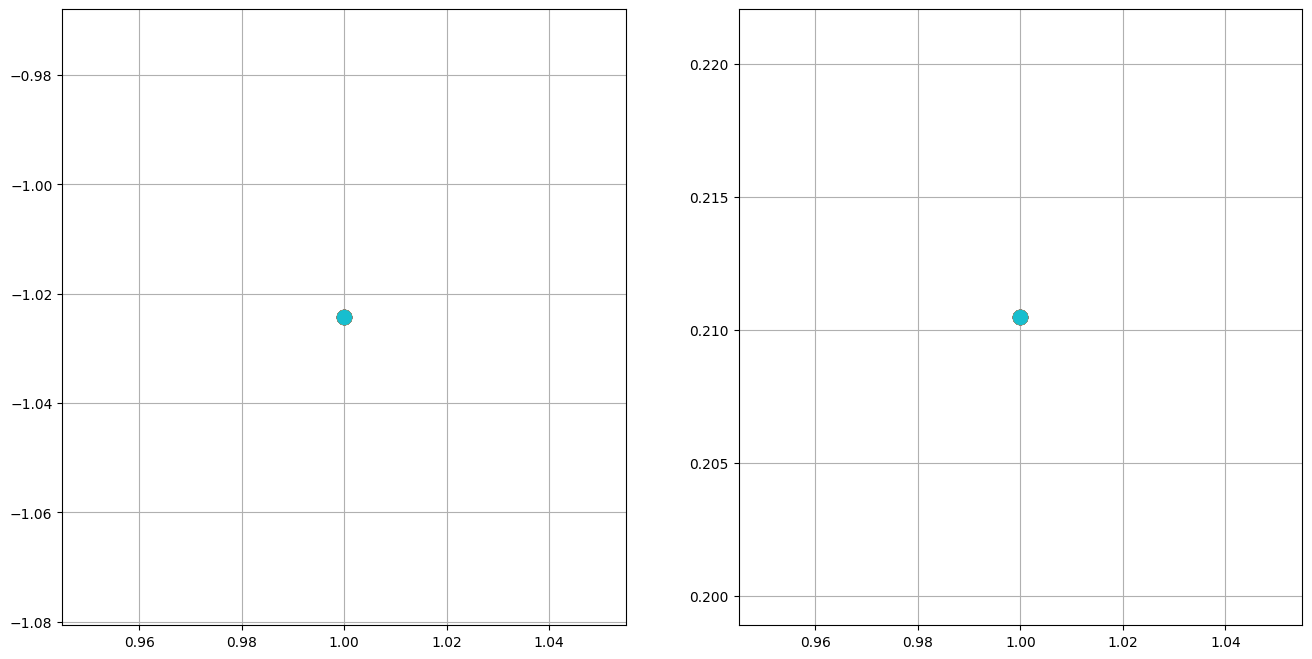

In [23]:
# Function to remove entries from array:
def remove_entries(a, n):
    if n < a.shape[0]:
        removed_entries = np.random.choice(a.shape[0], n, replace=False)
        return np.delete(a, removed_entries, axis=0), True
    return a, False

# Get residuals from ensemble predictions:
def get_residuals(ensemble_predictions, y_true, current_idx):
    residual = y_true - np.mean(ensemble_predictions[current_idx], axis=0)
    r_mean = np.mean(residual, axis=0)
    r_std = np.std(residual, axis=0)
    return np.mean(r_mean), np.mean(r_std)

# Evaluate ensemble performance:
def evaluate_ensemble(ensemble_predictions, y_true, n_remove, n_trials):
    ensemble_size = ensemble_predictions.shape[0]
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    for _ in range(n_trials):
        residuals_mean = []
        residuals_std = []
        sizes = [ensemble_size]

        keep_removing = True
        idx = np.arange(ensemble_size)
        res = get_residuals(ensemble_predictions, y_true, idx)
        residuals_mean.append(res[0])
        residuals_std.append(res[1])

        while keep_removing:
            new_idx, keep_removing = remove_entries(idx, n_remove)
            if keep_removing:
                res = get_residuals(ensemble_predictions, y_true, new_idx)
                residuals_mean.append(res[0])
                residuals_std.append(res[1])
                sizes.append(new_idx.shape[0])

            idx = new_idx

        ax[0].plot(sizes, residuals_mean, '-o', linewidth=3.0, markersize=10)
        ax[0].grid(True)
        ax[1].plot(sizes, residuals_std, '-o', linewidth=3.0, markersize=10)
        ax[1].grid(True)

evaluate_ensemble(ensemble_predictions, Data_pointsy, 2, 30)


In [25]:
idx = np.arange(10)
print(idx)

def remove_n_entries(arr, n):
    if n < arr.shape[0]:
       indices_to_remove = np.random.choice(arr.shape[0], n, replace=False)

       # Remove the entries at those indices
       return np.delete(arr, indices_to_remove)
    
    return arr

new_idx = remove_n_entries(idx,2)
print(new_idx)

new_idx_2 = remove_n_entries(new_idx,2)
print(new_idx_2)

[0 1 2 3 4 5 6 7 8 9]
[1 2 3 4 5 7 8 9]
[2 3 4 5 8 9]


In [26]:
th.chisq(fitpoints)

(np.float64(193.0686847281752), 156, np.float64(0.023336947982023126))

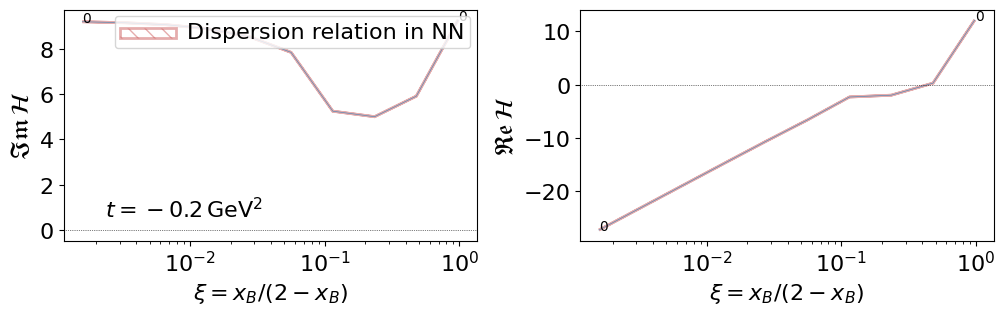

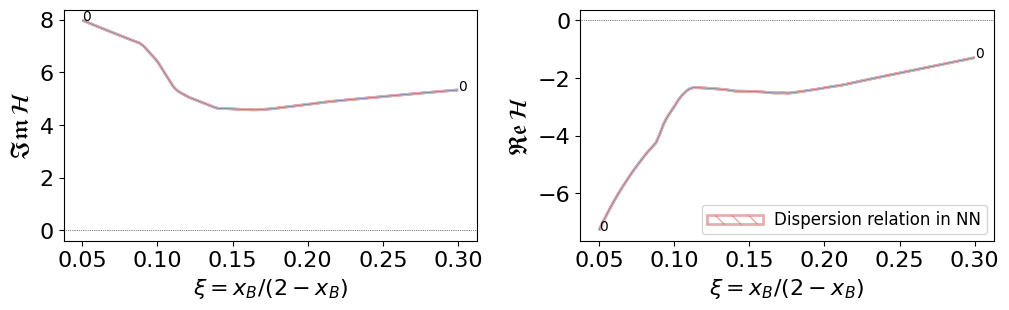

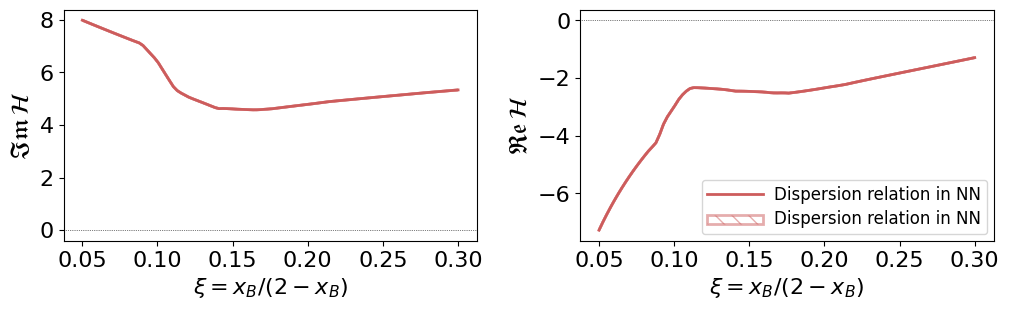

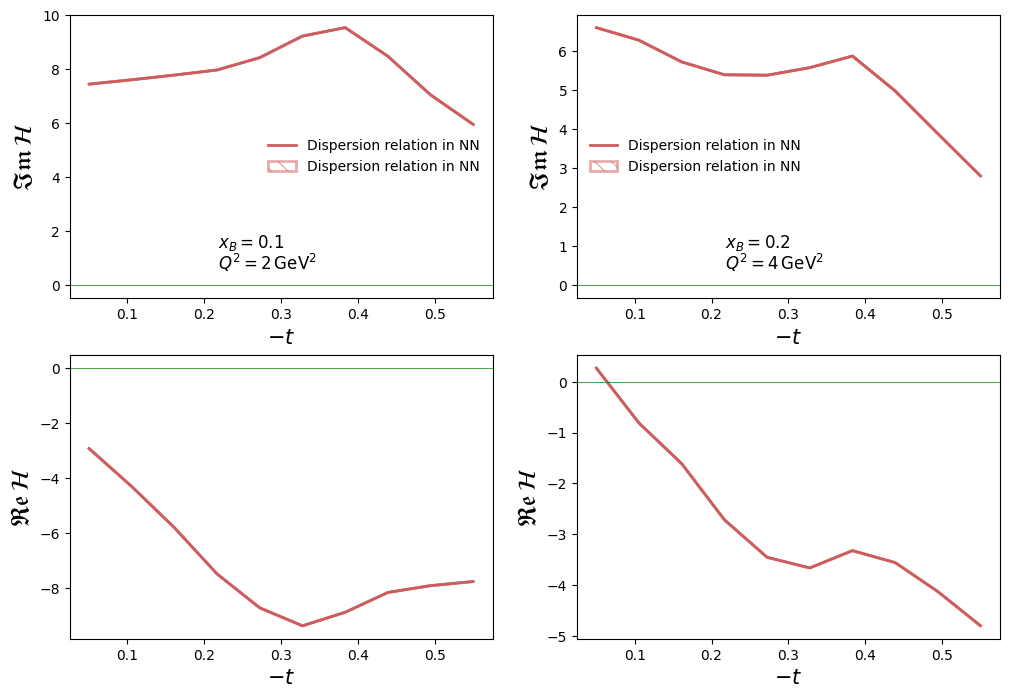

In [27]:
th.name = "Dispersion relation in NN"
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th, bands=[th], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th, bands=[th])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th], bands=[th])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th], bands=[th])

In [ ]:
################# Customization for 4-CFF DR model ###################
class CustomNetwork_4(nn.Module):
    def __init__(self):
        super(CustomNetwork_4, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 20)
        self.n2 = nn.Linear(20, 25)
        self.n3 = nn.Linear(25, 2)

        self.n1p = nn.Linear(1, 7)
        self.n2p = nn.Linear(7, 5)
        self.n3p = nn.Linear(5, 1)

    def forward(self, x):

        x0 = x

        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)

        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)

        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)

        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
        return output



# Define the 4-CFF DR model
class NNTest_DR_4(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BM10, g.cff.DispersionCFF):
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork_4()
        optimizer = torch.optim.Rprop(nn_model.parameters(), lr=0.05)
        return nn_model, optimizer

    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #print("I am here in D")
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(2, pt, xi)

    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)

    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.cffs(1, pt, xi)

    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)

    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [ ]:
th_dr_4 = NNTest_DR_4(output_layer=['ImH', 'ImE', 'D'])
th_dr_4.name = "DR in NN with H and E-CFFs"

In [ ]:
for i in range(1, 1 + ensembleSize):
    print(f"Training DR 4-CFF model {i}/{ensembleSize}...")
    f3 = g.fitter.NeuralFitter(fitpoints, th_dr_4, nnets=2, nbatch=5, batchlen=5, regularization='L2', lx_lambda=0.001)
    f3.fit()
    torch.save(th_dr_4.nn_model.state_dict(), os.path.join(FITS_DIR, f'Test_DR4CFF_nets_{i}.pt'))

In [ ]:
########## Ensemble for 2CFFs with DR

# Collect ensemble predictions for DR model
ensemble_predictions2 = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
current_model = th_dr_4.nn_model.to(device)

for i in range(1, 1 + ensembleSize):
    model_path = os.path.join(FITS_DIR, f'Test_DR4CFF_nets_{i}.pt')
    current_state_dict = torch.load(model_path, map_location=device, weights_only=True)
    current_model.load_state_dict(current_state_dict, strict=False)
    current_model.eval()
    current_predictions = current_model(torch.as_tensor(Data_points, dtype=torch.float32).to(device))
    ensemble_predictions2.append(current_predictions.detach().cpu().numpy())

ensemble_predictions = np.stack(ensemble_predictions2)
print("Ensemble prediction shape:", ensemble_predictions.shape)

# Ensemble evaluation
evaluate_ensemble(ensemble_predictions, Data_pointsy, n_remove=2, n_trials=10)


In [29]:
import random
ptts = []
tm_list = np.linspace(0.1, 0.5, 10)#[0.1, 0.2, 0.3, 0.4]

for tm in tm_list:
    #rndm_idx = random.randint(0, len(tm_list)-1) # take some random point and set/change -t
    ptb = g.dset[102][0].copy()  
    ptb.t = -tm
    ptb.tm = tm
    th15.prepare(ptb)
    ptts.append(ptb)

print(ptts)

[DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437]


In [30]:
th.name = "DR in NN whit 2 CFFs"
D = []
std_values = [] #!
net_indices = [] #!

print("\n---- [{} - {}] ----".format(th.name, th.description))
A = []
for pt in ptts[::-1]:
    Ds = []
    for i, net in enumerate(th.nets):  # Loop over neural networks
        th.nn_model, th.nn_mean, th.nn_std = net  # Assign neural net parameters
            
        Ds.append(float(th.m.subtraction(pt).detach().numpy()*18./25.))
        #print(float(-th.m.subtraction(pt).detach().numpy()*18./25.))
        th.cffs_evaluated = False
    net_indices.append(i)
        #for k in range(len(th.m.nets)):
        #th.m.parameters['nnet'] = k
        # NOTE: subtraction in code is equal to -\Delta(t) !
        #Ds.append(-th.m.subtraction(pt).detach().numpy()*18./25.) 
        #print(-th.m.subtraction(pt).detach().numpy()*18./25.)
    Ds = np.array(Ds)
    D_std = Ds.std() #!
    std_values.append(D_std) #!

    print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
    A.append((pt.tm, Ds.mean(), Ds.std()))
th.m.parameters['nnet'] = 'ALL'    
D.append(A)


---- [DR in NN whit 2 CFFs - N/A] ----
0.185, -0.5: 0.08083438873291016 +- 0.0
0.185, -0.4555555555555556: 0.03861932083964348 +- 0.0
0.185, -0.4111111111111111: -0.0062009720131754875 +- 0.0
0.185, -0.3666666666666667: -0.04844914376735687 +- 0.0
0.185, -0.32222222222222224: -0.20339971780776978 +- 0.0
0.185, -0.2777777777777778: -1.0332708358764648 +- 0.0
0.185, -0.23333333333333334: -2.1213982105255127 +- 0.0
0.185, -0.18888888888888888: -3.429067373275757 +- 0.0
0.185, -0.14444444444444446: -4.776697158813477 +- 0.0
0.185, -0.1: -6.086076259613037 +- 0.0


/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_13477/2915168330.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ds.append(float(th.m.subtraction(pt).detach().numpy()*18./25.))


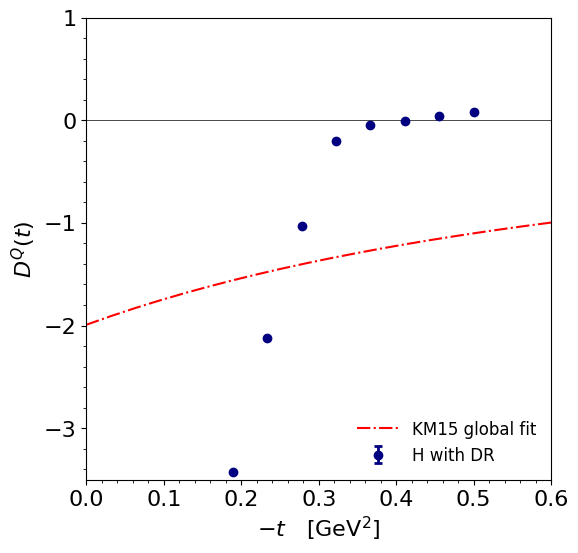

In [31]:
NPTS = 20
ts = np.linspace(0, 0.6, NPTS)
KMS = np.array([-(18./25.)*2.768/(1.+tm/1.204**2)**2 for tm in ts])
CDS = np.array(D[0])
#CADS = np.array(D[1])
fig, ax = plt.subplots(1, 1,  figsize=[6,6])
ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
ax.plot(ts, KMS, 'r-.', label='KM15 global fit')
ax.errorbar(CDS[:,0], CDS[:,1], CDS[:,2], linestyle='None', color='navy',
            elinewidth=2, capsize=3, capthick=2, marker='o', label='H with DR')
#ax.errorbar(CADS[:,0,]+0.01, CADS[:,1], CADS[:,2], linestyle='None', elinewidth=2,
#            capsize=3, capthick=2, marker='o', color='indianred', label='H and E with DR')

ax.set_xlim(0.0, 0.6)
ax.set_ylim(-3.5, 1)
ax.legend(loc=4, handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(0)
ax.set_xlabel(r'$-t \quad [{\rm GeV}^2]$', fontsize=16)
ax.set_ylabel(r'$D^{Q}(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)) 
ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.02)) 
ax.yaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(1.)) 
ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.2)) 

# Fitting with 20 models

In [ ]:
th1 = NNTest_DR(output_layer=['ImH', 'D'])
th1.name = 'fit'

Training model 1/20...


/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/model.py:399: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),



Epoch   5: train error = 7.6357 test error = 4.4321 -
Epoch  10: train error = 2.6532 test error = 5.0188 +
Epoch  15: train error = 1.5481 test error = 2.8591 -
Epoch  20: train error = 1.4781 test error = 2.0596 -
Epoch  25: train error = 1.4055 test error = 1.8661 -
Epoch  30: train error = 1.3743 test error = 1.7352 -
Epoch  35: train error = 1.3503 test error = 1.6708 -
Epoch  40: train error = 1.3341 test error = 1.6748 +
Epoch  45: train error = 1.3216 test error = 1.6170 -
Epoch  50: train error = 1.3111 test error = 1.6067 -
Epoch  55: train error = 1.3040 test error = 1.6006 -
Epoch  60: train error = 1.2985 test error = 1.6018 +
Epoch  65: train error = 1.2929 test error = 1.6017 +
Epoch  70: train error = 1.2870 test error = 1.5764 -
Epoch  75: train error = 1.2795 test error = 1.6474 +
Epoch  80: train error = 1.2748 test error = 1.6476 +
Epoch  85: train error = 1.2712 test error = 1.6550 +
Epoch  90: train error = 1.2673 test error = 1.6357 +
Epoch  95: train error = 1.

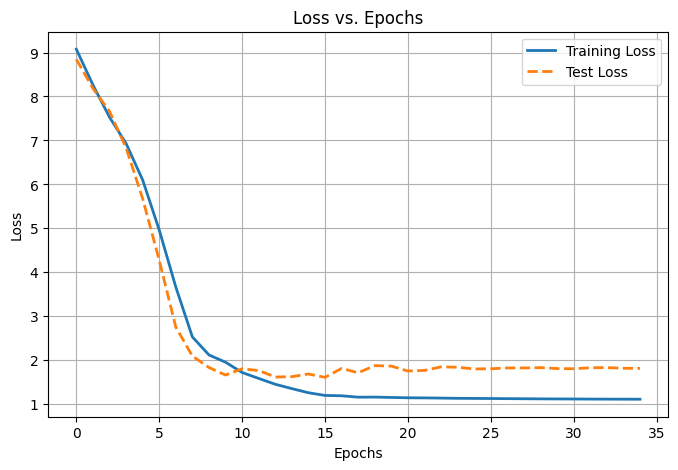

...done!
 
Training model 2/20...

Epoch   5: train error = 7.9529 test error = 6.9428 -
Epoch  10: train error = 2.7016 test error = 2.1970 -
Epoch  15: train error = 2.1324 test error = 2.1033 -
Epoch  20: train error = 1.6669 test error = 2.6363 +
Epoch  25: train error = 1.5232 test error = 2.9983 +
Epoch  30: train error = 1.4909 test error = 2.7416 +
Epoch  35: train error = 1.4688 test error = 2.7662 +
Epoch  40: train error = 1.4495 test error = 2.8919 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 2.1032767840649105

Epoch   5: train error = 6.1300 test error = 5.7067 -
Epoch  10: train error = 2.3745 test error = 7.8521 +
Epoch  15: train error = 1.6215 test error = 3.7023 -
Epoch  20: train error = 1.4927 test error = 2.3213 -
Epoch  25: train error = 1.3840 test error = 1.7508 -
Epoch  30: train error = 1.3271 test error = 1.6766 -
Epoch  35: train error = 1.2815 test error = 1.7048 +
Epoch  40: train error = 1.2573 test error = 1.5943 -
Epoch  45: tra

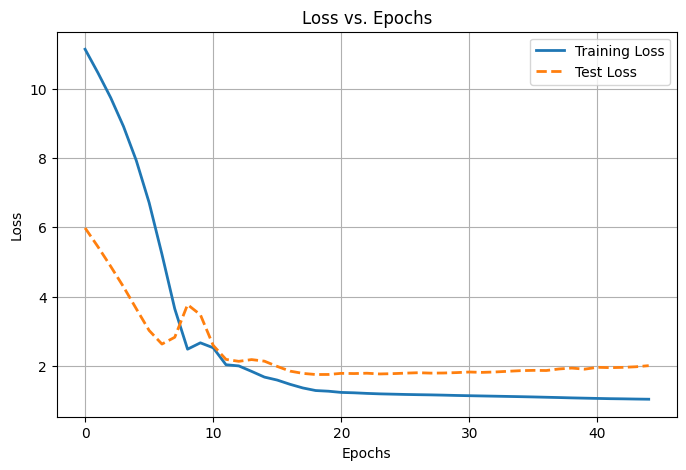

...done!
 
Training model 3/20...

Epoch   5: train error = 7.2667 test error = 3.8951 -
Epoch  10: train error = 2.5290 test error = 3.2332 -
Epoch  15: train error = 1.7915 test error = 2.0247 -
Epoch  20: train error = 1.5845 test error = 1.5409 -
Epoch  25: train error = 1.4459 test error = 1.6601 +
Epoch  30: train error = 1.3491 test error = 1.7775 +
Epoch  35: train error = 1.2944 test error = 2.0494 +
Epoch  40: train error = 1.2678 test error = 1.9773 +
Epoch  45: train error = 1.2464 test error = 2.0064 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.5408942913390733

Epoch   5: train error = 4.3327 test error = 10.2855 -
Epoch  10: train error = 2.0013 test error = 2.1333 -
Epoch  15: train error = 1.6554 test error = 1.7884 -
Epoch  20: train error = 1.4541 test error = 2.2771 +
Epoch  25: train error = 1.3910 test error = 2.5746 +
Epoch  30: train error = 1.3605 test error = 2.6750 +
Epoch  35: train error = 1.3146 test error = 3.0269 +
Epoch  40: tr

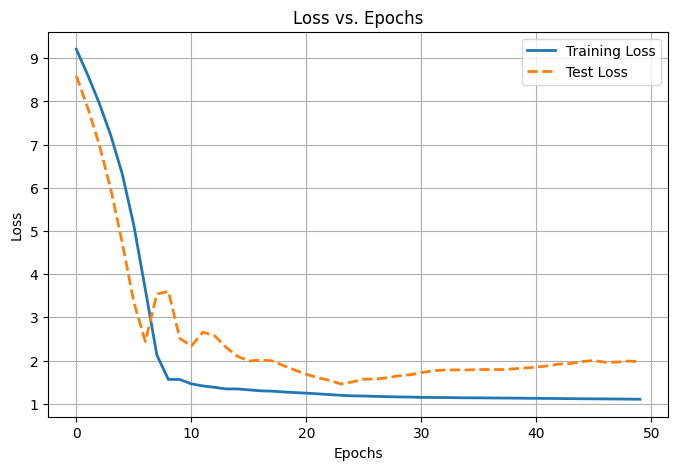

...done!
 
Training model 4/20...

Epoch   5: train error = 5.2098 test error = 6.2847 -
Epoch  10: train error = 1.9560 test error = 3.1339 -
Epoch  15: train error = 1.5026 test error = 2.3853 -
Epoch  20: train error = 1.3839 test error = 1.6832 -
Epoch  25: train error = 1.3223 test error = 1.4667 -
Epoch  30: train error = 1.2918 test error = 1.4697 +
Epoch  35: train error = 1.2751 test error = 1.5673 +
Epoch  40: train error = 1.2655 test error = 1.6220 +
Epoch  45: train error = 1.2577 test error = 1.6343 +
Epoch  50: train error = 1.2430 test error = 1.6298 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.4666783218875987

Epoch   5: train error = 7.9587 test error = 6.6535 -
Epoch  10: train error = 3.4926 test error = 1.8864 -
Epoch  15: train error = 2.2544 test error = 1.5740 -
Epoch  20: train error = 1.9138 test error = 1.8456 +
Epoch  25: train error = 1.7941 test error = 2.1919 +
Epoch  30: train error = 1.6897 test error = 2.3070 +
Epoch  35: tra

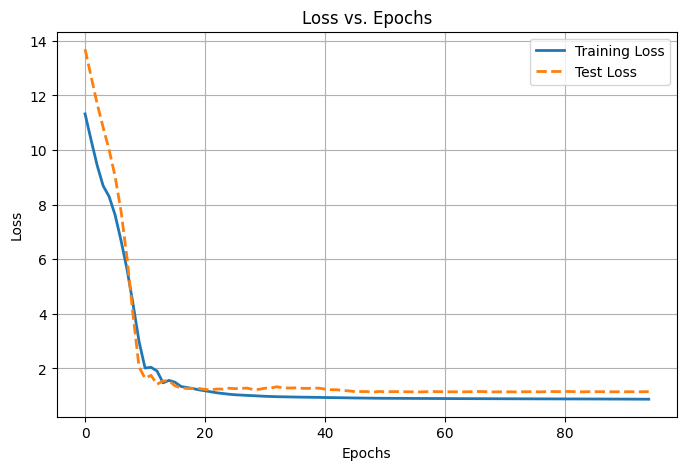

...done!
 
Training model 5/20...

Epoch   5: train error = 6.2389 test error = 3.1860 -
Epoch  10: train error = 2.2820 test error = 1.5693 -
Epoch  15: train error = 1.4234 test error = 1.5313 -
Epoch  20: train error = 1.3929 test error = 1.4378 -
Epoch  25: train error = 1.3519 test error = 1.3767 -
Epoch  30: train error = 1.3249 test error = 1.3624 -
Epoch  35: train error = 1.2920 test error = 1.3751 +
Epoch  40: train error = 1.2598 test error = 1.3936 +
Epoch  45: train error = 1.2339 test error = 1.4143 +
Epoch  50: train error = 1.2150 test error = 1.4305 +
Epoch  55: train error = 1.2013 test error = 1.4275 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.3624085040254772

Epoch   5: train error = 8.0648 test error = 6.5650 -
Epoch  10: train error = 2.7288 test error = 3.4270 -
Epoch  15: train error = 1.5511 test error = 1.8621 -
Epoch  20: train error = 1.2653 test error = 1.4111 -
Epoch  25: train error = 1.1723 test error = 1.4824 +
Epoch  30: tra

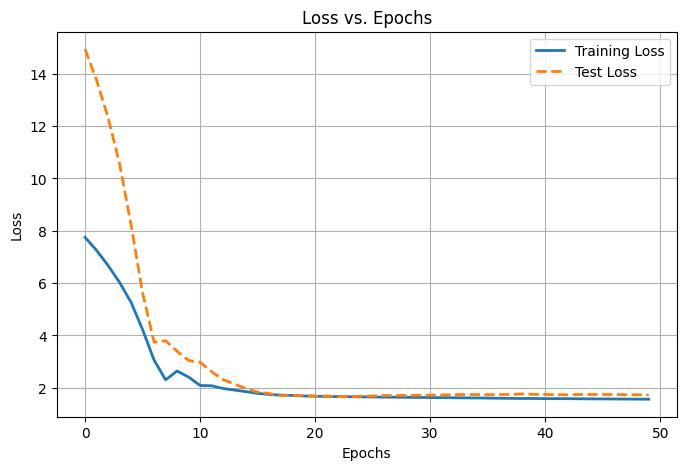

...done!
 
Training model 6/20...

Epoch   5: train error = 6.1426 test error = 5.9900 -
Epoch  10: train error = 1.5677 test error = 1.9966 -
Epoch  15: train error = 1.1624 test error = 1.3533 -
Epoch  20: train error = 1.0368 test error = 1.2042 -
Epoch  25: train error = 0.9994 test error = 1.2577 +
Epoch  30: train error = 0.9750 test error = 1.3374 +
Epoch  35: train error = 0.9629 test error = 1.3069 +
Epoch  40: train error = 0.9496 test error = 1.3242 +
Epoch  45: train error = 0.9404 test error = 1.3297 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.2041989938044997

Epoch   5: train error = 6.1576 test error = 6.2335 -
Epoch  10: train error = 2.2451 test error = 4.4523 -
Epoch  15: train error = 1.6863 test error = 1.9504 -
Epoch  20: train error = 1.5063 test error = 1.3687 -
Epoch  25: train error = 1.4469 test error = 1.2644 -
Epoch  30: train error = 1.4146 test error = 1.1735 -
Epoch  35: train error = 1.3784 test error = 1.1089 -
Epoch  40: tra

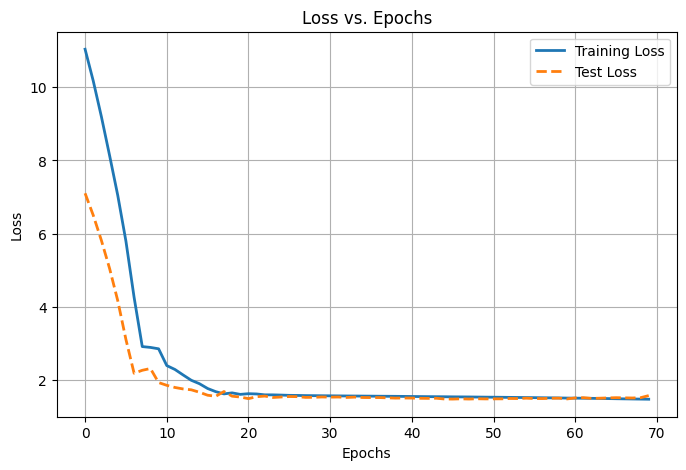

...done!
 
Training model 7/20...

Epoch   5: train error = 10.0024 test error = 6.0163 -
Epoch  10: train error = 3.8036 test error = 3.5225 -
Epoch  15: train error = 2.3211 test error = 3.0070 -
Epoch  20: train error = 1.5747 test error = 1.8476 -
Epoch  25: train error = 1.3933 test error = 1.6980 -
Epoch  30: train error = 1.3155 test error = 1.6355 -
Epoch  35: train error = 1.2459 test error = 1.7295 +
Epoch  40: train error = 1.2017 test error = 1.6623 +
Epoch  45: train error = 1.1793 test error = 1.6621 +
Epoch  50: train error = 1.1627 test error = 1.6627 +
Epoch  55: train error = 1.1420 test error = 1.6750 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.635457954246434

Epoch   5: train error = 8.0935 test error = 7.6740 -
Epoch  10: train error = 2.6027 test error = 1.9254 -
Epoch  15: train error = 1.9032 test error = 1.7627 -
Epoch  20: train error = 1.5884 test error = 1.7725 +
Epoch  25: train error = 1.5291 test error = 1.6662 -
Epoch  30: tra

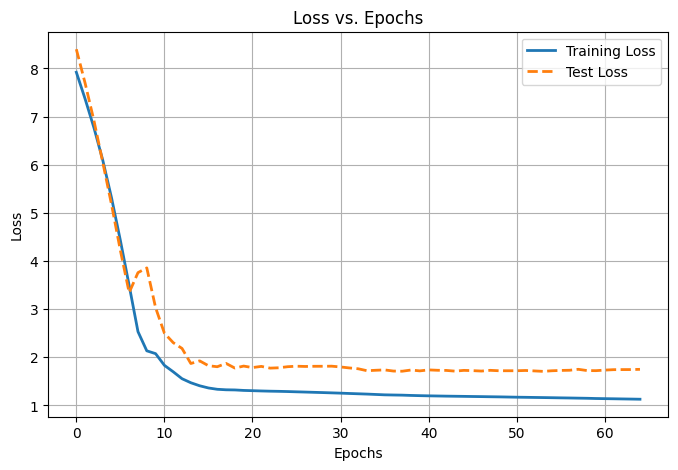

...done!
 
Training model 8/20...

Epoch   5: train error = 6.2839 test error = 7.3218 -
Epoch  10: train error = 2.2857 test error = 1.2650 -
Epoch  15: train error = 1.4705 test error = 1.3392 +
Epoch  20: train error = 1.2781 test error = 1.4781 +
Epoch  25: train error = 1.2495 test error = 1.4387 +
Epoch  30: train error = 1.2207 test error = 1.4219 +
Epoch  35: train error = 1.1932 test error = 1.3858 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.2650267865111364

Epoch   5: train error = 4.6167 test error = 7.0615 -
Epoch  10: train error = 1.8526 test error = 3.0798 -
Epoch  15: train error = 1.5003 test error = 1.9548 -
Epoch  20: train error = 1.3837 test error = 1.5344 -
Epoch  25: train error = 1.3592 test error = 1.4915 -
Epoch  30: train error = 1.3368 test error = 1.5001 +
Epoch  35: train error = 1.3047 test error = 1.5039 +
Epoch  40: train error = 1.2677 test error = 1.5673 +
Epoch  45: train error = 1.2414 test error = 1.5607 +
Epoch  50: tra

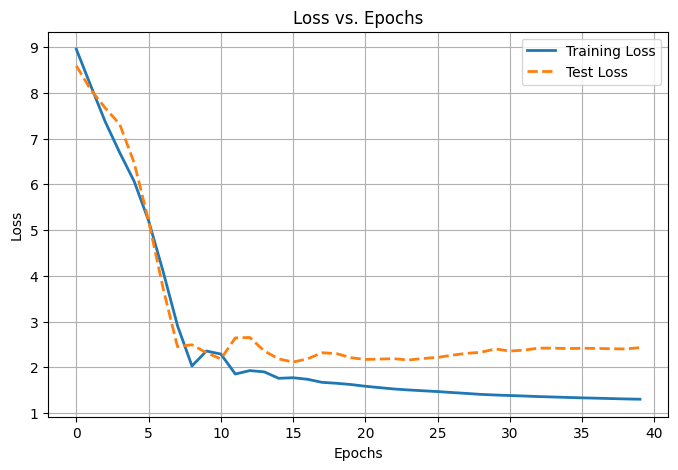

...done!
 
Training model 9/20...

Epoch   5: train error = 6.0055 test error = 5.6409 -
Epoch  10: train error = 2.6042 test error = 2.7143 -
Epoch  15: train error = 1.7198 test error = 2.1447 -
Epoch  20: train error = 1.4109 test error = 2.2248 +
Epoch  25: train error = 1.3227 test error = 2.1637 +
Epoch  30: train error = 1.2507 test error = 2.1537 +
Epoch  35: train error = 1.1940 test error = 2.2635 +
Epoch  40: train error = 1.1607 test error = 2.2588 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 2.144734263524501

Epoch   5: train error = 8.5966 test error = 4.8317 -
Epoch  10: train error = 2.2462 test error = 1.6807 -
Epoch  15: train error = 1.4573 test error = 1.2933 -
Epoch  20: train error = 1.3411 test error = 1.2577 -
Epoch  25: train error = 1.3061 test error = 1.2143 -
Epoch  30: train error = 1.2803 test error = 1.2049 -
Epoch  35: train error = 1.2552 test error = 1.2805 +
Epoch  40: train error = 1.2323 test error = 1.3234 +
Epoch  45: trai

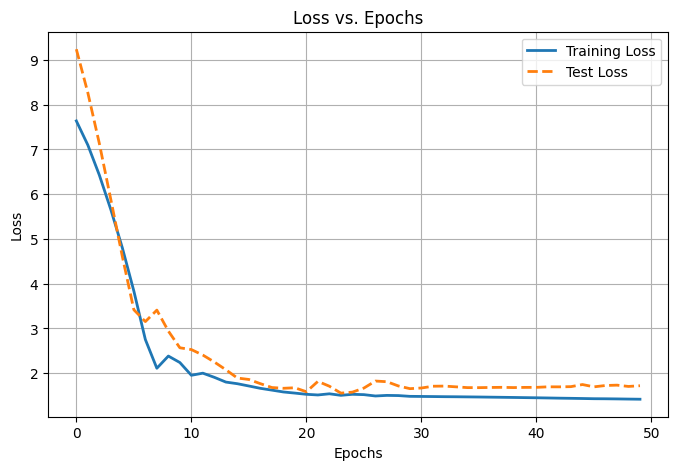

...done!
 
Training model 10/20...

Epoch   5: train error = 7.1228 test error = 5.6644 -
Epoch  10: train error = 2.1688 test error = 1.4668 -
Epoch  15: train error = 1.4326 test error = 1.0149 -
Epoch  20: train error = 1.2995 test error = 0.8958 -
Epoch  25: train error = 1.2554 test error = 0.9267 +
Epoch  30: train error = 1.2299 test error = 0.9569 +
Epoch  35: train error = 1.2102 test error = 0.9620 +
Epoch  40: train error = 1.1971 test error = 0.9802 +
Epoch  45: train error = 1.1893 test error = 0.9813 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 0.8957936137597435

Epoch   5: train error = 8.2563 test error = 5.8022 -
Epoch  10: train error = 2.3996 test error = 4.8722 -
Epoch  15: train error = 1.9519 test error = 2.2588 -
Epoch  20: train error = 1.3500 test error = 1.6913 -
Epoch  25: train error = 1.2197 test error = 2.3813 +
Epoch  30: train error = 1.1795 test error = 2.5676 +
Epoch  35: train error = 1.1454 test error = 2.5593 +
Epoch  40: tr

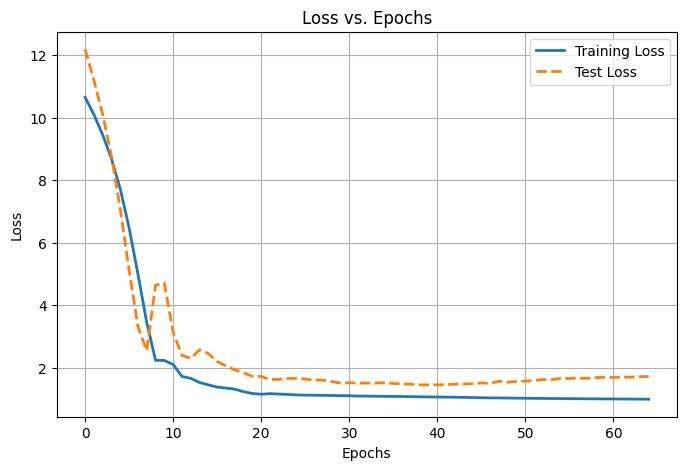

...done!
 
Training model 11/20...

Epoch   5: train error = 7.7271 test error = 7.3384 -
Epoch  10: train error = 2.1087 test error = 3.8418 -
Epoch  15: train error = 1.8811 test error = 1.9113 -
Epoch  20: train error = 1.6046 test error = 1.8658 -
Epoch  25: train error = 1.4683 test error = 1.8079 -
Epoch  30: train error = 1.3916 test error = 1.8499 +
Epoch  35: train error = 1.3620 test error = 1.8965 +
Epoch  40: train error = 1.3292 test error = 1.9203 +
Epoch  45: train error = 1.2987 test error = 1.9869 +
Epoch  50: train error = 1.2628 test error = 2.0643 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.8079379083204579

Epoch   5: train error = 8.4413 test error = 5.3577 -
Epoch  10: train error = 2.1055 test error = 1.7880 -
Epoch  15: train error = 1.4291 test error = 1.7930 +
Epoch  20: train error = 1.2008 test error = 1.8477 +
Epoch  25: train error = 1.1563 test error = 1.8235 +
Epoch  30: train error = 1.1359 test error = 1.8393 +
Epoch  35: tr

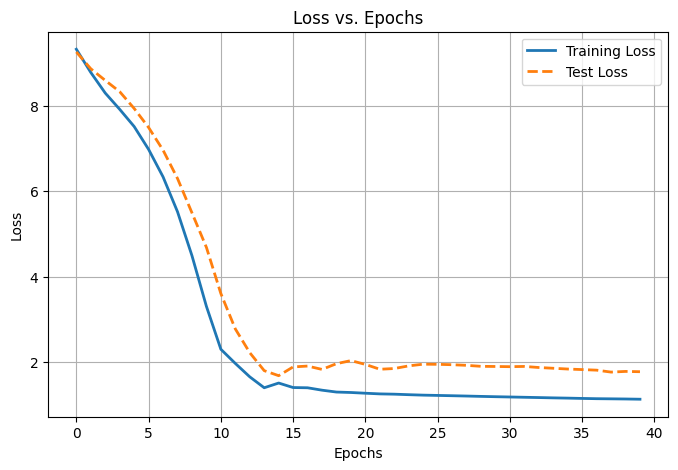

...done!
 
Training model 12/20...

Epoch   5: train error = 6.3831 test error = 5.8206 -
Epoch  10: train error = 2.5481 test error = 1.4018 -
Epoch  15: train error = 1.6960 test error = 1.6357 +
Epoch  20: train error = 1.5147 test error = 1.8010 +
Epoch  25: train error = 1.4493 test error = 1.9156 +
Epoch  30: train error = 1.4194 test error = 2.0338 +
Epoch  35: train error = 1.4030 test error = 2.0134 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.4017532553203238

Epoch   5: train error = 9.3890 test error = 5.7625 -
Epoch  10: train error = 2.6281 test error = 1.9653 -
Epoch  15: train error = 1.7980 test error = 1.5706 -
Epoch  20: train error = 1.5186 test error = 1.6119 +
Epoch  25: train error = 1.4501 test error = 1.5948 +
Epoch  30: train error = 1.3856 test error = 1.6144 +
Epoch  35: train error = 1.3569 test error = 1.5814 +
Epoch  40: train error = 1.3305 test error = 1.6287 +
No improvement for 5 batches. Stopping early.
Net 1 --> test_err = 

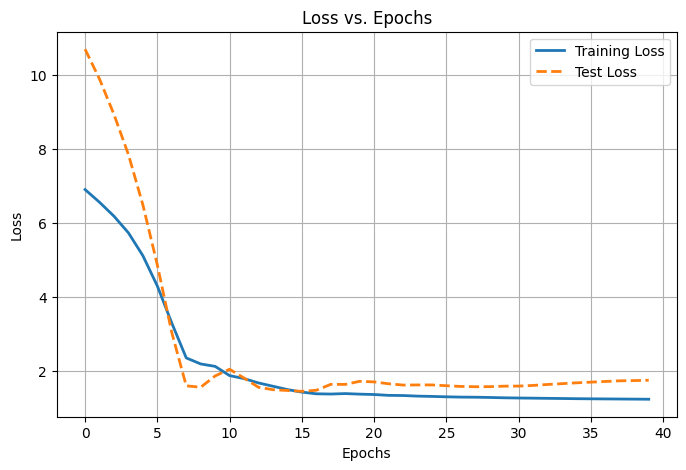

...done!
 
Training model 13/20...

Epoch   5: train error = 6.6540 test error = 3.1461 -
Epoch  10: train error = 2.9654 test error = 3.1853 +
Epoch  15: train error = 1.6943 test error = 1.8573 -
Epoch  20: train error = 1.3559 test error = 1.4617 -
Epoch  25: train error = 1.2817 test error = 1.4105 -
Epoch  30: train error = 1.2535 test error = 1.3962 -
Epoch  35: train error = 1.2339 test error = 1.3949 -
Epoch  40: train error = 1.2203 test error = 1.3958 +
Epoch  45: train error = 1.2077 test error = 1.3897 -
Epoch  50: train error = 1.2010 test error = 1.4013 +
Epoch  55: train error = 1.1947 test error = 1.4157 +
Epoch  60: train error = 1.1893 test error = 1.4092 +
Epoch  65: train error = 1.1818 test error = 1.4066 +
Epoch  70: train error = 1.1760 test error = 1.4126 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.3897083116275284

Epoch   5: train error = 8.0048 test error = 6.5040 -
Epoch  10: train error = 2.6608 test error = 2.1189 -
Epoch  15: tr

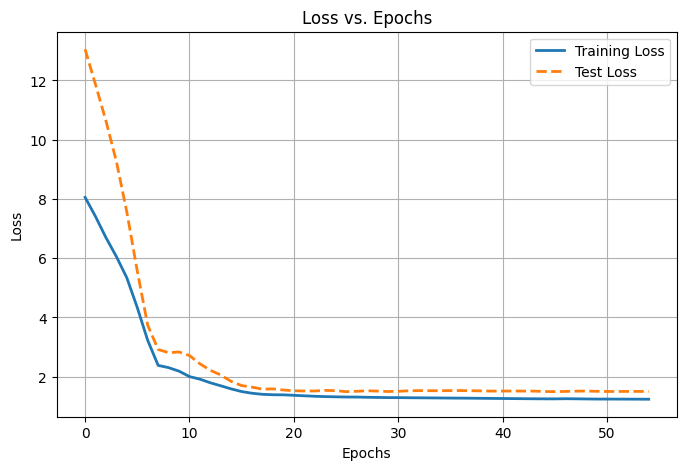

...done!
 
Training model 14/20...

Epoch   5: train error = 8.6526 test error = 7.8355 -
Epoch  10: train error = 2.6892 test error = 2.4428 -
Epoch  15: train error = 1.6535 test error = 2.0845 -
Epoch  20: train error = 1.2856 test error = 2.2548 +
Epoch  25: train error = 1.2193 test error = 2.2061 +
Epoch  30: train error = 1.1880 test error = 2.1089 +
Epoch  35: train error = 1.1716 test error = 2.0509 -
Epoch  40: train error = 1.1577 test error = 2.0559 +
Epoch  45: train error = 1.1461 test error = 2.0425 -
Epoch  50: train error = 1.1356 test error = 2.0510 +
Epoch  55: train error = 1.1252 test error = 2.0699 +
Epoch  60: train error = 1.1203 test error = 2.0648 +
Epoch  65: train error = 1.1166 test error = 2.0683 +
Epoch  70: train error = 1.1125 test error = 2.0754 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 2.0424687794227343

Epoch   5: train error = 6.3737 test error = 8.2935 -
Epoch  10: train error = 1.6060 test error = 5.9897 -
Epoch  15: tr

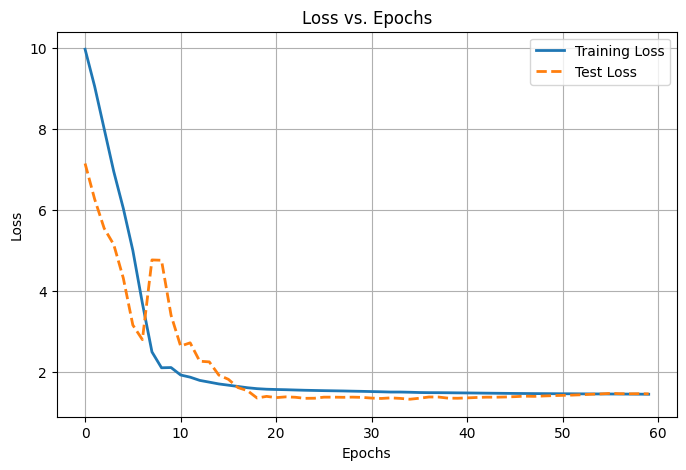

...done!
 
Training model 15/20...

Epoch   5: train error = 4.9388 test error = 8.6986 -
Epoch  10: train error = 1.6641 test error = 3.7245 -
Epoch  15: train error = 1.4093 test error = 2.2712 -
Epoch  20: train error = 1.3426 test error = 2.2351 -
Epoch  25: train error = 1.3035 test error = 2.0242 -
Epoch  30: train error = 1.2620 test error = 1.8683 -
Epoch  35: train error = 1.2266 test error = 1.9683 +
Epoch  40: train error = 1.2096 test error = 2.0104 +
Epoch  45: train error = 1.1895 test error = 2.0595 +
Epoch  50: train error = 1.1771 test error = 2.0947 +
Epoch  55: train error = 1.1691 test error = 2.1183 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.8682603102446391

Epoch   5: train error = 9.9075 test error = 4.7163 -
Epoch  10: train error = 3.4211 test error = 1.4160 -
Epoch  15: train error = 2.1846 test error = 1.2257 -
Epoch  20: train error = 1.5364 test error = 1.3032 +
Epoch  25: train error = 1.4460 test error = 1.3720 +
Epoch  30: tr

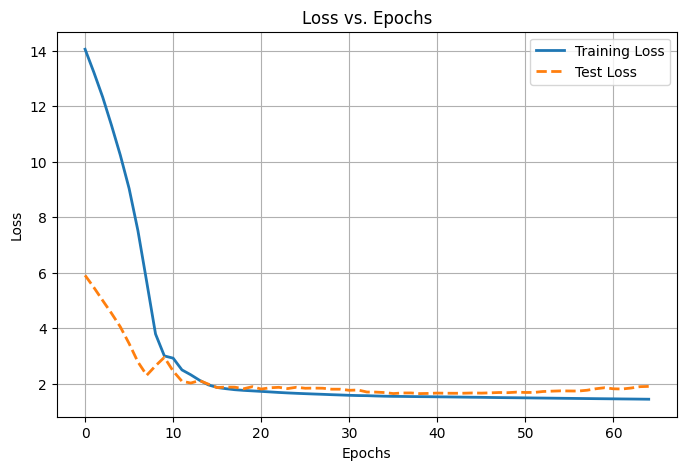

...done!
 
Training model 16/20...

Epoch   5: train error = 6.5449 test error = 6.4975 -
Epoch  10: train error = 2.7642 test error = 1.7712 -
Epoch  15: train error = 1.7578 test error = 1.3825 -
Epoch  20: train error = 1.6613 test error = 1.2797 -
Epoch  25: train error = 1.6082 test error = 1.2983 +
Epoch  30: train error = 1.5322 test error = 1.2634 -
Epoch  35: train error = 1.4709 test error = 1.2514 -
Epoch  40: train error = 1.4329 test error = 1.2875 +
Epoch  45: train error = 1.4082 test error = 1.3539 +
Epoch  50: train error = 1.3901 test error = 1.3829 +
Epoch  55: train error = 1.3754 test error = 1.3829 +
Epoch  60: train error = 1.3657 test error = 1.3685 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.2513544971040294

Epoch   5: train error = 8.6427 test error = 4.4375 -
Epoch  10: train error = 2.6975 test error = 2.8359 -
Epoch  15: train error = 1.8313 test error = 1.8157 -
Epoch  20: train error = 1.4963 test error = 1.3565 -
Epoch  25: tr

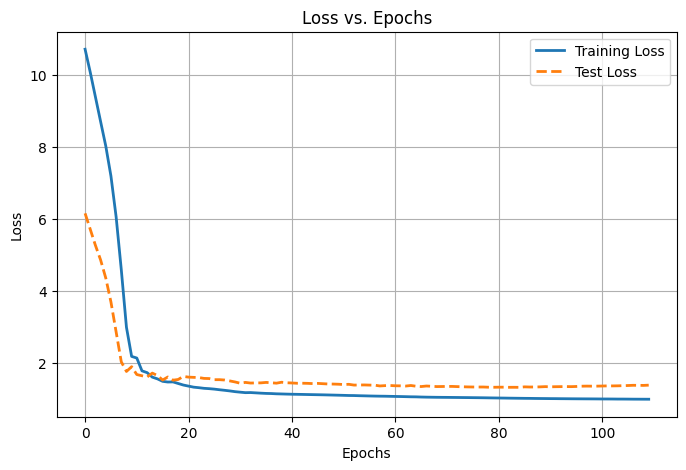

...done!
 
Training model 17/20...

Epoch   5: train error = 7.6654 test error = 5.1473 -
Epoch  10: train error = 2.3110 test error = 2.1231 -
Epoch  15: train error = 1.4444 test error = 1.7755 -
Epoch  20: train error = 1.3179 test error = 1.6869 -
Epoch  25: train error = 1.2589 test error = 1.5895 -
Epoch  30: train error = 1.2138 test error = 1.5183 -
Epoch  35: train error = 1.1777 test error = 1.4578 -
Epoch  40: train error = 1.1421 test error = 1.4401 -
Epoch  45: train error = 1.1237 test error = 1.4294 -
Epoch  50: train error = 1.1090 test error = 1.4185 -
Epoch  55: train error = 1.0979 test error = 1.4238 +
Epoch  60: train error = 1.0866 test error = 1.4211 +
Epoch  65: train error = 1.0735 test error = 1.4402 +
Epoch  70: train error = 1.0625 test error = 1.4404 +
Epoch  75: train error = 1.0530 test error = 1.4563 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.4184679102579536

Epoch   5: train error = 7.5984 test error = 4.1207 -
Epoch  10: tr

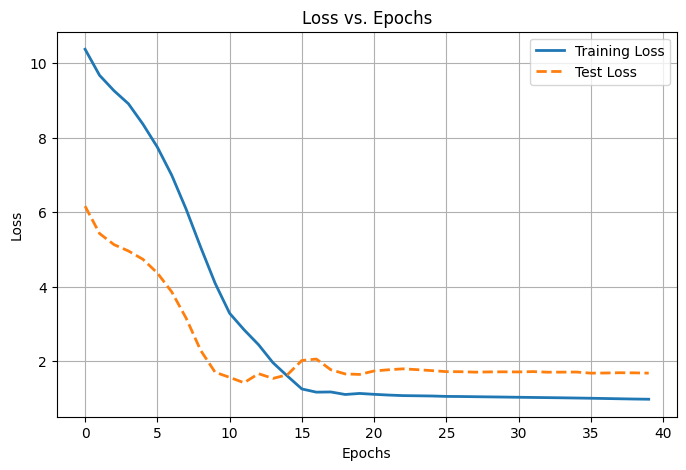

...done!
 
Training model 18/20...

Epoch   5: train error = 6.0218 test error = 9.0450 -
Epoch  10: train error = 1.9066 test error = 4.2478 -
Epoch  15: train error = 1.5713 test error = 1.7174 -
Epoch  20: train error = 1.2807 test error = 1.2324 -
Epoch  25: train error = 1.2396 test error = 1.2771 +
Epoch  30: train error = 1.1767 test error = 1.3477 +
Epoch  35: train error = 1.1962 test error = 1.4537 +
Epoch  40: train error = 1.1455 test error = 1.4431 +
Epoch  45: train error = 1.1328 test error = 1.4226 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.2323899914213425

Epoch   5: train error = 7.6325 test error = 5.7153 -
Epoch  10: train error = 2.3622 test error = 1.8082 -
Epoch  15: train error = 1.5203 test error = 1.7435 -
Epoch  20: train error = 1.2313 test error = 2.0570 +
Epoch  25: train error = 1.1782 test error = 1.7965 +
Epoch  30: train error = 1.1450 test error = 1.7765 +
Epoch  35: train error = 1.1076 test error = 1.6836 -
Epoch  40: tr

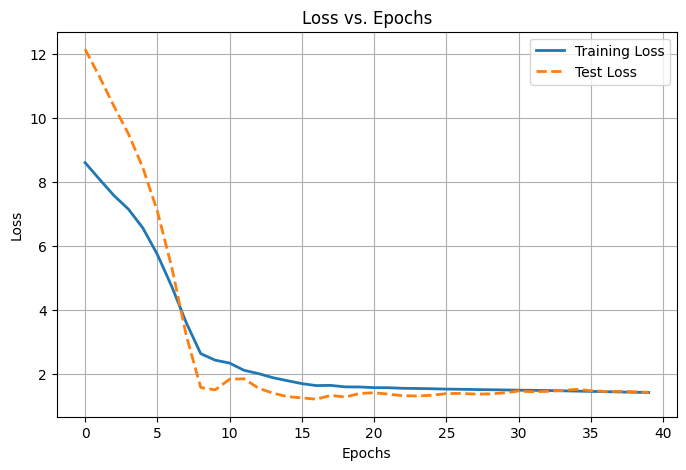

...done!
 
Training model 19/20...

Epoch   5: train error = 8.0029 test error = 6.1754 -
Epoch  10: train error = 2.4824 test error = 1.4460 -
Epoch  15: train error = 1.3053 test error = 1.2184 -
Epoch  20: train error = 1.0794 test error = 1.2435 +
Epoch  25: train error = 1.0149 test error = 1.3360 +
Epoch  30: train error = 0.9905 test error = 1.3418 +
Epoch  35: train error = 0.9648 test error = 1.3074 +
Epoch  40: train error = 0.9475 test error = 1.3349 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.2183566317108112

Epoch   5: train error = 8.6696 test error = 4.9537 -
Epoch  10: train error = 2.8882 test error = 2.0756 -
Epoch  15: train error = 1.8727 test error = 1.5063 -
Epoch  20: train error = 1.6179 test error = 1.3768 -
Epoch  25: train error = 1.4698 test error = 1.2559 -
Epoch  30: train error = 1.4044 test error = 1.3683 +
Epoch  35: train error = 1.3549 test error = 1.4845 +
Epoch  40: train error = 1.3360 test error = 1.4170 +
Epoch  45: tr

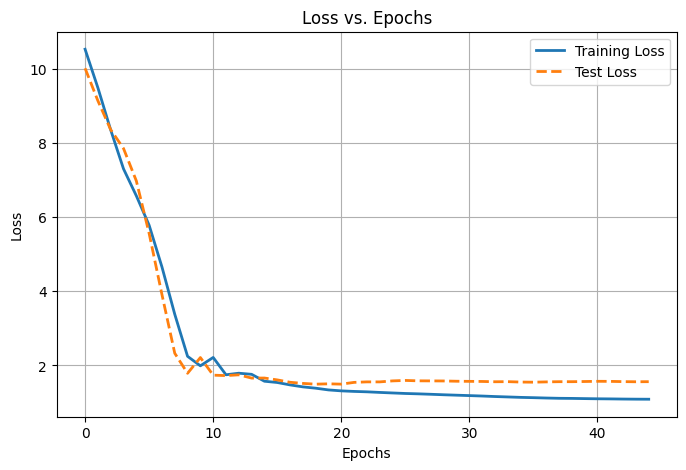

...done!
 
Training model 20/20...

Epoch   5: train error = 4.5751 test error = 2.4222 -
Epoch  10: train error = 1.7871 test error = 1.5078 -
Epoch  15: train error = 1.3765 test error = 1.4000 -
Epoch  20: train error = 1.3361 test error = 1.3799 -
Epoch  25: train error = 1.3168 test error = 1.3223 -
Epoch  30: train error = 1.2968 test error = 1.3329 +
Epoch  35: train error = 1.2790 test error = 1.3748 +
Epoch  40: train error = 1.2640 test error = 1.3806 +
Epoch  45: train error = 1.2505 test error = 1.3738 +
Epoch  50: train error = 1.2356 test error = 1.3502 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.3223298969256296

Epoch   5: train error = 5.9459 test error = 7.3010 -
Epoch  10: train error = 2.2368 test error = 1.5669 -
Epoch  15: train error = 1.5465 test error = 1.5407 -
Epoch  20: train error = 1.3419 test error = 1.7929 +
Epoch  25: train error = 1.3063 test error = 1.6469 +
Epoch  30: train error = 1.2943 test error = 1.6604 +
Epoch  35: tr

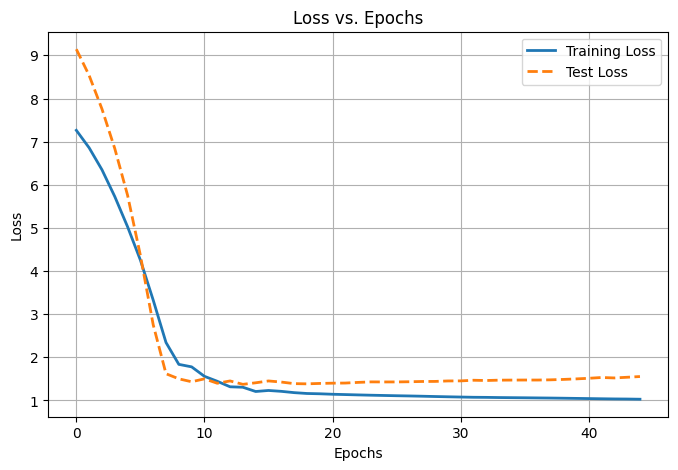

...done!
 
CPU times: user 6h 7min 22s, sys: 3min 49s, total: 6h 11min 11s
Wall time: 6h 23min 58s


In [54]:
%%time
# Define ensemble training
ensembleSize = 20  # Number of models in the ensemble

# Loop over the ensembles:
for i in range(1,1+ensembleSize):
    print(f"Training model {i}/{ensembleSize}...")

    f = NeuralFitter(fitpoints, th1, nnets=10, nbatch=50, batchlen=5, regularization='L2', lx_lambda=0.001)
    #f = g.fitter.NeuralFitter(fitpoints, th, nnets=10, nbatch=50, batchlen=2, regularization=None)
    f.fit()
    torch.save(th1.nn_model.state_dict(), f'Test1_nets_{i}.pt')

    # Plot the results:
    plt.figure(figsize=(8, 5))
    plt.plot(f.history, label="Training Loss",linewidth=2.0)
    plt.plot(f.test_history, label="Test Loss", linestyle="dashed",linewidth=2.0)
    plt.xlabel("Epochs") #Epochs in nbatch length
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    print("...done!")
    print(" ")

### Train a Classifier Ensemble 

In [106]:
# Set the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect the ensemble predictions on the test data
ensemble_predictions = []
ensembleSize = 20  

# Iterate over ensemble networks
for i in range(1, 1 + ensembleSize):
    # Re-initialize the model to ensure consistency
    current_model = th1.nn_model.to(device)  # Ensure fresh model instance on the correct device

    # Load the saved state dictionary
    current_state_dict = torch.load(f'Test1_nets_{i}.pt', map_location=device)

    # Get the model's current state dictionary
    model_state_dict = current_model.state_dict()

    # Filter only matching keys
    filtered_state_dict = {k: v for k, v in current_state_dict.items() if k in model_state_dict and v.shape == model_state_dict[k].shape}

    # Load the filtered parameters
    model_state_dict.update(filtered_state_dict)
    current_model.load_state_dict(model_state_dict, strict=False)

    # Set model to evaluation mode
    current_model.eval()

    # Ensure Data_points is a tensor and on the same device as the model
    data_tensor = torch.as_tensor(Data_points, dtype=torch.float32).to(device)

    # Get predictions
    with torch.no_grad():  # Ensure no gradients are tracked
        current_predictions = current_model(data_tensor)

    # Convert to NumPy and store
    ensemble_predictions.append(current_predictions.detach().cpu().numpy())

# Convert predictions to a stacked NumPy array
ensemble_predictions = np.stack(ensemble_predictions)  # Shape: (num_models, num_data_points, num_outputs)

# Print the shape of the final ensemble prediction array
print(ensemble_predictions.shape)

(15, 172, 2)


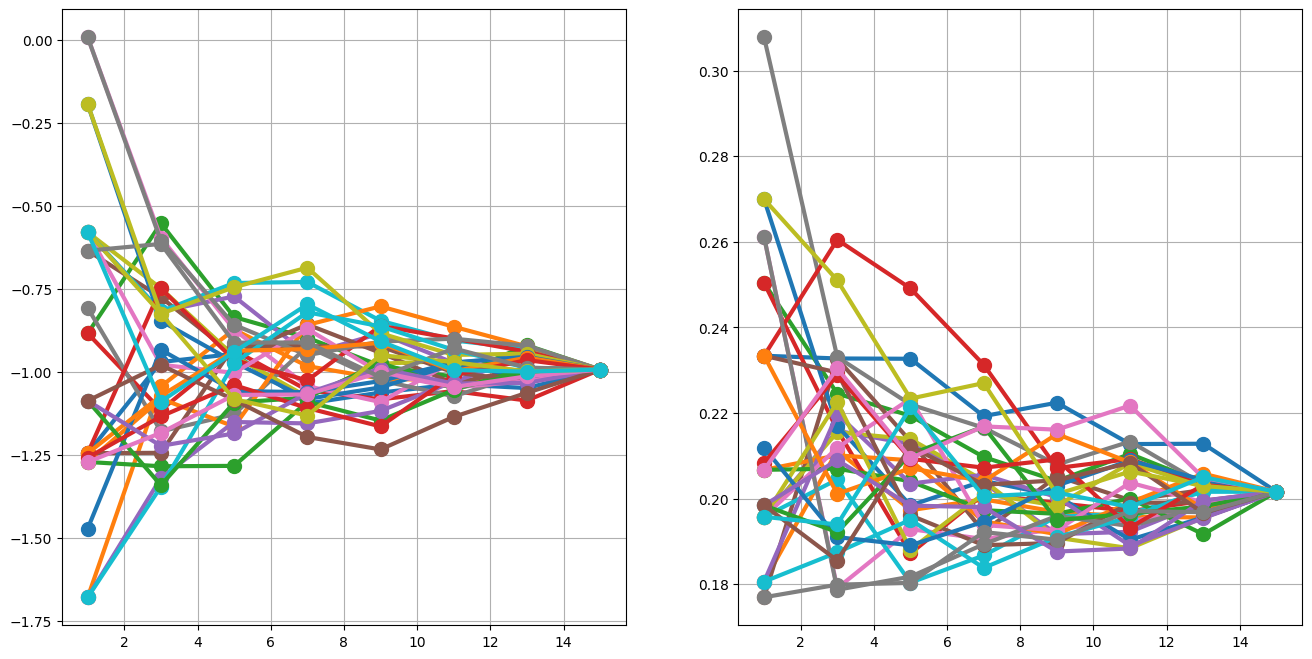

In [107]:
# Function to remove entries from array:
def remove_entries(a, n):
    if n < a.shape[0]:
        removed_entries = np.random.choice(a.shape[0], n, replace=False)
        return np.delete(a, removed_entries, axis=0), True
    return a, False

# Get residuals from ensemble predictions:
def get_residuals(ensemble_predictions, y_true, current_idx):
    residual = y_true - np.mean(ensemble_predictions[current_idx], axis=0)
    r_mean = np.mean(residual, axis=0)
    r_std = np.std(residual, axis=0)
    return np.mean(r_mean), np.mean(r_std)

# Evaluate ensemble performance:
def evaluate_ensemble(ensemble_predictions, y_true, n_remove, n_trials):
    ensemble_size = ensemble_predictions.shape[0]
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    for _ in range(n_trials):
        residuals_mean = []
        residuals_std = []
        sizes = [ensemble_size]

        keep_removing = True
        idx = np.arange(ensemble_size)
        res = get_residuals(ensemble_predictions, y_true, idx)
        residuals_mean.append(res[0])
        residuals_std.append(res[1])

        while keep_removing:
            new_idx, keep_removing = remove_entries(idx, n_remove)
            if keep_removing:
                res = get_residuals(ensemble_predictions, y_true, new_idx)
                residuals_mean.append(res[0])
                residuals_std.append(res[1])
                sizes.append(new_idx.shape[0])

            idx = new_idx

        ax[0].plot(sizes, residuals_mean, '-o', linewidth=3.0, markersize=10)
        ax[0].grid(True)
        ax[1].plot(sizes, residuals_std, '-o', linewidth=3.0, markersize=10)
        ax[1].grid(True)

evaluate_ensemble(ensemble_predictions, Data_pointsy, 2, 30)

In [90]:
th1.chisq(fitpoints)

(np.float64(65.0627090623119), 171, np.float64(0.9999999999999909))

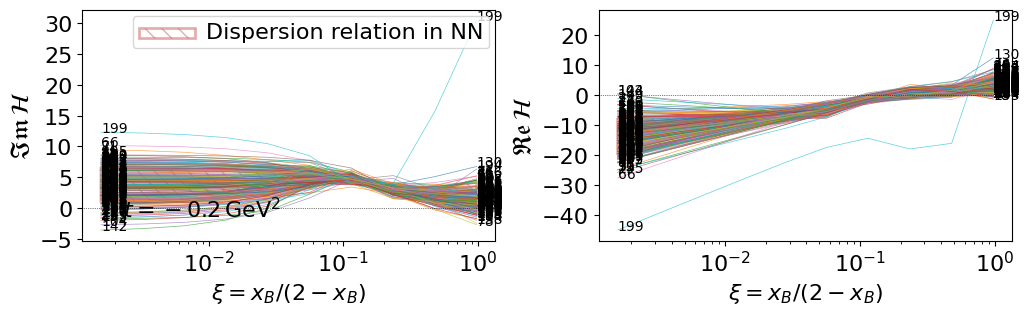

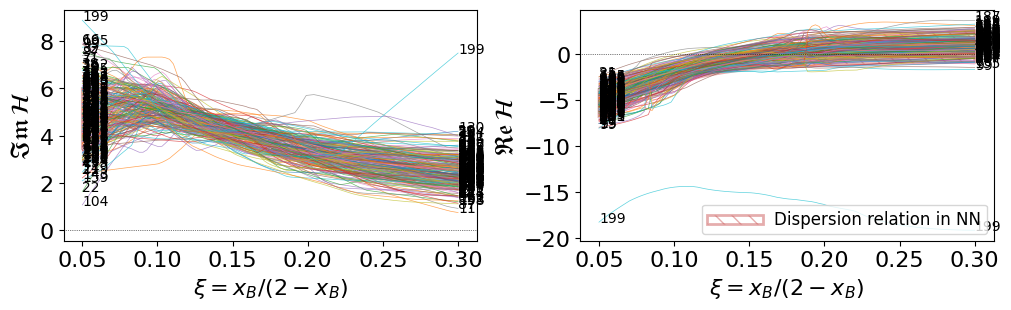

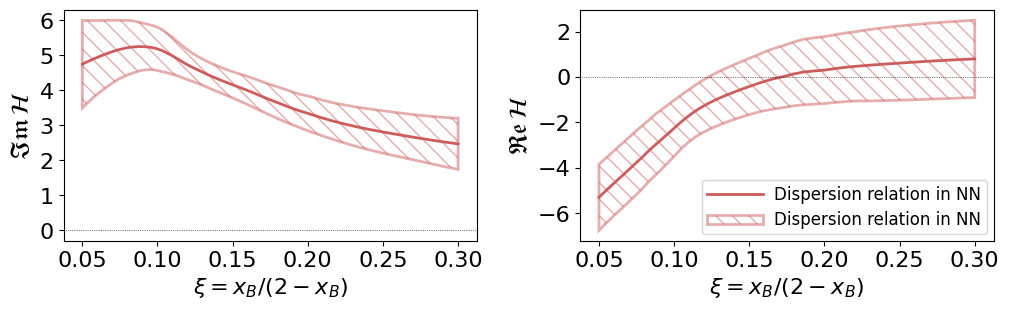

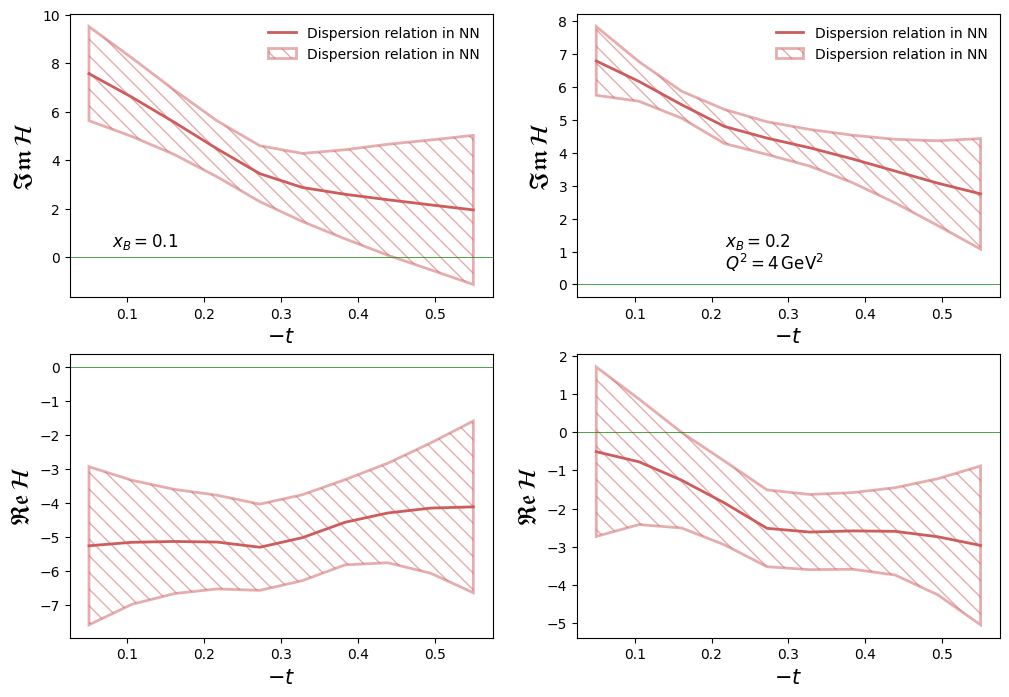

In [91]:
th1.name = "Dispersion relation in NN"
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th1, bands=[th1], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th1, bands=[th1])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th1], bands=[th1])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th1], bands=[th1])

In [108]:
th1.name = "DR in NN whit 2 CFFs"
D = []
std_values = [] #!
net_indices = [] #!

print("\n---- [{} - {}] ----".format(th1.name, th1.description))
A = []
for pt in ptts[::-1]:
    Ds = []
    for i, net in enumerate(th1.nets):  # Loop over neural networks
        th1.nn_model, th1.nn_mean, th1.nn_std = net  # Assign neural net parameters
            
        Ds.append(float(th1.m.subtraction(pt).detach().numpy()*18./25.))
        #print(float(-th.m.subtraction(pt).detach().numpy()*18./25.))
        th1.cffs_evaluated = False
    net_indices.append(i)
        #for k in range(len(th.m.nets)):
        #th.m.parameters['nnet'] = k
        # NOTE: subtraction in code is equal to -\Delta(t) !
        #Ds.append(-th.m.subtraction(pt).detach().numpy()*18./25.) 
        #print(-th.m.subtraction(pt).detach().numpy()*18./25.)
    Ds = np.array(Ds)
    D_std = Ds.std() #!
    std_values.append(D_std) #!

    print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
    A.append((pt.tm, Ds.mean(), Ds.std()))
th1.m.parameters['nnet'] = 'ALL'    
D.append(A)


---- [DR in NN whit 2 CFFs - N/A] ----
0.185, -0.5: -0.8245252675830852 +- 1.3842551579174593
0.185, -0.4555555555555556: -0.8121912288514431 +- 1.1363076964949577
0.185, -0.4111111111111111: -0.7496977438533213 +- 0.9145453282910592
0.185, -0.3666666666666667: -0.6577043669077102 +- 0.7554802257677875
0.185, -0.32222222222222224: -0.5598936152888928 +- 0.6591435660161882
0.185, -0.2777777777777778: -0.5416866510984255 +- 0.6406503250908853
0.185, -0.23333333333333334: -0.7845295364945195 +- 0.7279746965590306
0.185, -0.18888888888888888: -1.0827999110333622 +- 0.935705591798907
0.185, -0.14444444444444446: -1.3879935005027801 +- 1.217814601164492
0.185, -0.1: -1.7238331548473798 +- 1.5360080835306196


/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_13862/2904861926.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ds.append(float(th1.m.subtraction(pt).detach().numpy()*18./25.))


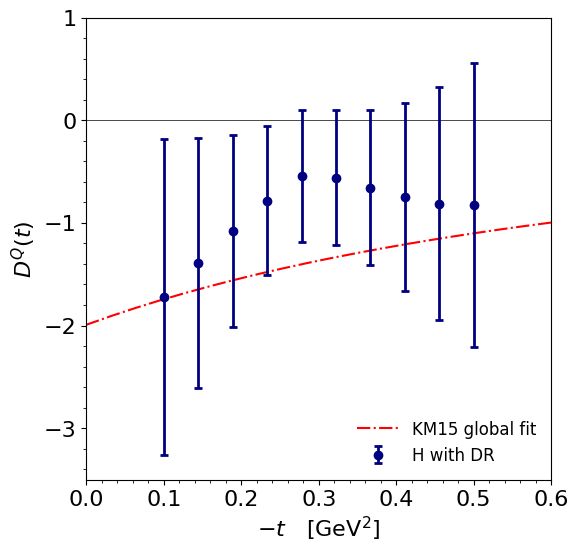

In [109]:
NPTS = 20
ts = np.linspace(0, 0.6, NPTS)
KMS = np.array([-(18./25.)*2.768/(1.+tm/1.204**2)**2 for tm in ts])
CDS = np.array(D[0])
#CADS = np.array(D[1])
fig, ax = plt.subplots(1, 1,  figsize=[6,6])
ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
ax.plot(ts, KMS, 'r-.', label='KM15 global fit')
ax.errorbar(CDS[:,0], CDS[:,1], CDS[:,2], linestyle='None', color='navy',
            elinewidth=2, capsize=3, capthick=2, marker='o', label='H with DR')
#ax.errorbar(CADS[:,0,]+0.01, CADS[:,1], CADS[:,2], linestyle='None', elinewidth=2,
#            capsize=3, capthick=2, marker='o', color='indianred', label='H and E with DR')

ax.set_xlim(0.0, 0.6)
ax.set_ylim(-3.5, 1)
ax.legend(loc=4, handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(0)
ax.set_xlabel(r'$-t \quad [{\rm GeV}^2]$', fontsize=16)
ax.set_ylabel(r'$D^{Q}(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)) 
ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.02)) 
ax.yaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(1.)) 
ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.2)) 

# Fitting with regularization L1

In [110]:
th2 = NNTest_DR(output_layer=['ImH', 'D'])
th2.name = 'fit'

Training model 1/20...


/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/model.py:399: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),



Epoch   5: train error = 8.1520 test error = 5.8502 -
Epoch  10: train error = 2.2312 test error = 1.8618 -
Epoch  15: train error = 1.9393 test error = 1.4385 -
Epoch  20: train error = 1.6084 test error = 1.4379 -
Epoch  25: train error = 1.5082 test error = 1.4517 +
Epoch  30: train error = 1.4604 test error = 1.4078 -
Epoch  35: train error = 1.4201 test error = 1.3997 -
Epoch  40: train error = 1.3915 test error = 1.4471 +
Epoch  45: train error = 1.3682 test error = 1.4710 +
Epoch  50: train error = 1.3523 test error = 1.4581 +
Epoch  55: train error = 1.3412 test error = 1.4460 +
Epoch  60: train error = 1.3303 test error = 1.4502 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.3996681613421886

Epoch   5: train error = 8.0002 test error = 6.5053 -
Epoch  10: train error = 3.0613 test error = 1.2109 -
Epoch  15: train error = 1.7664 test error = 1.4523 +
Epoch  20: train error = 1.5555 test error = 1.3590 +
Epoch  25: train error = 1.4958 test error = 1.2

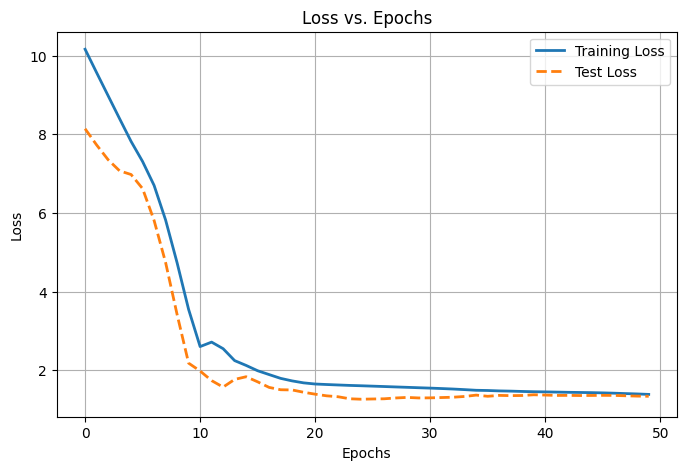

...done!
 
Training model 2/20...

Epoch   5: train error = 10.0585 test error = 3.2540 -
Epoch  10: train error = 2.5901 test error = 1.3727 -
Epoch  15: train error = 1.4651 test error = 1.1980 -
Epoch  20: train error = 1.1830 test error = 1.1510 -
Epoch  25: train error = 1.1375 test error = 1.1212 -
Epoch  30: train error = 1.1021 test error = 1.1319 +
Epoch  35: train error = 1.0728 test error = 1.1345 +
Epoch  40: train error = 1.0446 test error = 1.1522 +
Epoch  45: train error = 1.0227 test error = 1.2091 +
Epoch  50: train error = 0.9934 test error = 1.2634 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.1212279510595524

Epoch   5: train error = 7.8812 test error = 6.0194 -
Epoch  10: train error = 2.3015 test error = 2.6505 -
Epoch  15: train error = 1.5871 test error = 2.1065 -
Epoch  20: train error = 1.3276 test error = 1.9333 -
Epoch  25: train error = 1.2965 test error = 1.9101 -
Epoch  30: train error = 1.2615 test error = 1.8620 -
Epoch  35: tr

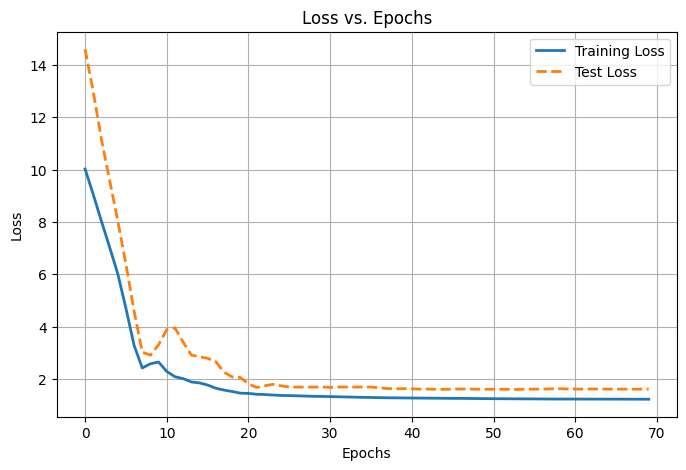

...done!
 
Training model 3/20...

Epoch   5: train error = 8.5625 test error = 4.2392 -
Epoch  10: train error = 2.5247 test error = 2.1976 -
Epoch  15: train error = 1.8398 test error = 1.7365 -
Epoch  20: train error = 1.6634 test error = 1.5323 -
Epoch  25: train error = 1.5515 test error = 1.6191 +
Epoch  30: train error = 1.5137 test error = 1.6696 +
Epoch  35: train error = 1.4852 test error = 1.7077 +
Epoch  40: train error = 1.4652 test error = 1.7317 +
Epoch  45: train error = 1.4496 test error = 1.7321 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.532252596927426

Epoch   5: train error = 8.3524 test error = 5.9693 -
Epoch  10: train error = 3.3936 test error = 2.6511 -
Epoch  15: train error = 1.7195 test error = 2.3826 -
Epoch  20: train error = 1.5169 test error = 1.7757 -
Epoch  25: train error = 1.4636 test error = 1.7780 +
Epoch  30: train error = 1.4327 test error = 1.6866 -
Epoch  35: train error = 1.4063 test error = 1.5901 -
Epoch  40: trai

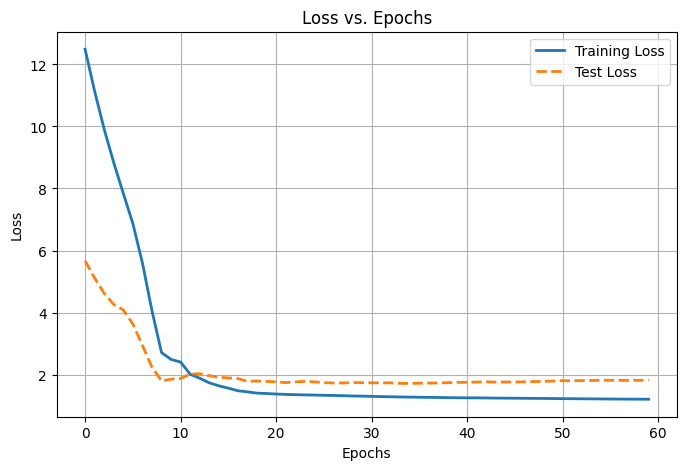

...done!
 
Training model 4/20...

Epoch   5: train error = 8.9772 test error = 4.0953 -
Epoch  10: train error = 2.8374 test error = 2.2228 -
Epoch  15: train error = 1.4964 test error = 1.6255 -
Epoch  20: train error = 1.1780 test error = 1.8015 +
Epoch  25: train error = 1.1237 test error = 1.7856 +
Epoch  30: train error = 1.1009 test error = 1.8178 +
Epoch  35: train error = 1.0755 test error = 1.8418 +
Epoch  40: train error = 1.0514 test error = 1.8670 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.6254524949051048

Epoch   5: train error = 7.7446 test error = 6.8105 -
Epoch  10: train error = 1.8380 test error = 3.0645 -
Epoch  15: train error = 1.7357 test error = 1.9314 -
Epoch  20: train error = 1.5674 test error = 1.5955 -
Epoch  25: train error = 1.5056 test error = 1.5498 -
Epoch  30: train error = 1.4655 test error = 1.5447 -
Epoch  35: train error = 1.4450 test error = 1.5583 +
Epoch  40: train error = 1.4214 test error = 1.5826 +
Epoch  45: tra

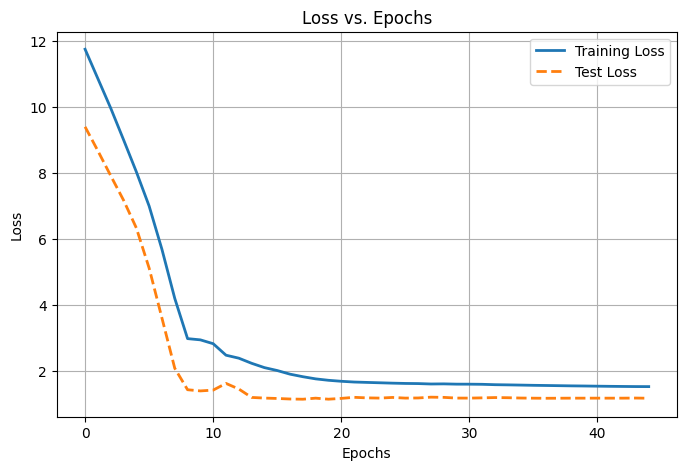

...done!
 
Training model 5/20...

Epoch   5: train error = 7.2877 test error = 6.7330 -
Epoch  10: train error = 2.3258 test error = 2.2369 -
Epoch  15: train error = 1.6647 test error = 1.7925 -
Epoch  20: train error = 1.4606 test error = 1.6405 -
Epoch  25: train error = 1.4029 test error = 1.6473 +
Epoch  30: train error = 1.3594 test error = 1.6132 -
Epoch  35: train error = 1.3306 test error = 1.6070 -
Epoch  40: train error = 1.2811 test error = 1.6211 +
Epoch  45: train error = 1.2324 test error = 1.6804 +
Epoch  50: train error = 1.1970 test error = 1.7733 +
Epoch  55: train error = 1.1713 test error = 1.8691 +
Epoch  60: train error = 1.1570 test error = 1.9319 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.6069714532693524

Epoch   5: train error = 9.5123 test error = 9.2594 -
Epoch  10: train error = 3.6315 test error = 2.3567 -
Epoch  15: train error = 2.1562 test error = 1.9361 -
Epoch  20: train error = 1.6490 test error = 1.1250 -
Epoch  25: tra

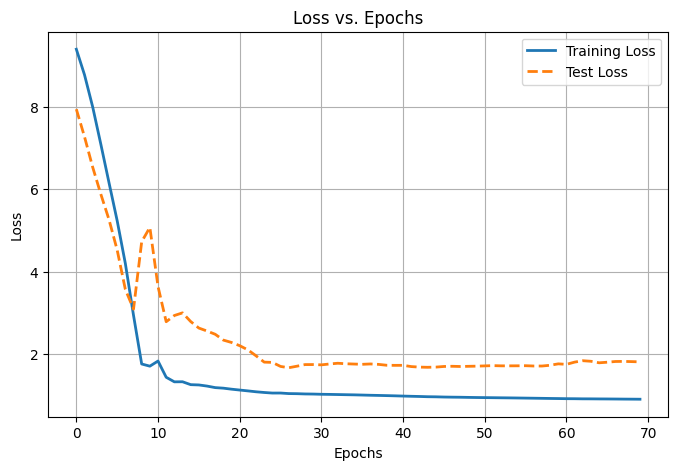

...done!
 
Training model 6/20...

Epoch   5: train error = 5.2981 test error = 5.5400 -
Epoch  10: train error = 2.1297 test error = 2.5918 -
Epoch  15: train error = 1.4264 test error = 1.6273 -
Epoch  20: train error = 1.2578 test error = 1.7249 +
Epoch  25: train error = 1.2112 test error = 1.6545 +
Epoch  30: train error = 1.1688 test error = 1.5235 -
Epoch  35: train error = 1.1391 test error = 1.4769 -
Epoch  40: train error = 1.1131 test error = 1.4247 -
Epoch  45: train error = 1.0898 test error = 1.3852 -
Epoch  50: train error = 1.0794 test error = 1.4160 +
Epoch  55: train error = 1.0711 test error = 1.3902 +
Epoch  60: train error = 1.0580 test error = 1.3818 -
Epoch  65: train error = 1.0451 test error = 1.4045 +
Epoch  70: train error = 1.0295 test error = 1.3754 -
Epoch  75: train error = 1.0195 test error = 1.3887 +
Epoch  80: train error = 1.0125 test error = 1.3972 +
Epoch  85: train error = 1.0047 test error = 1.3778 +
Epoch  90: train error = 0.9954 test error = 1.

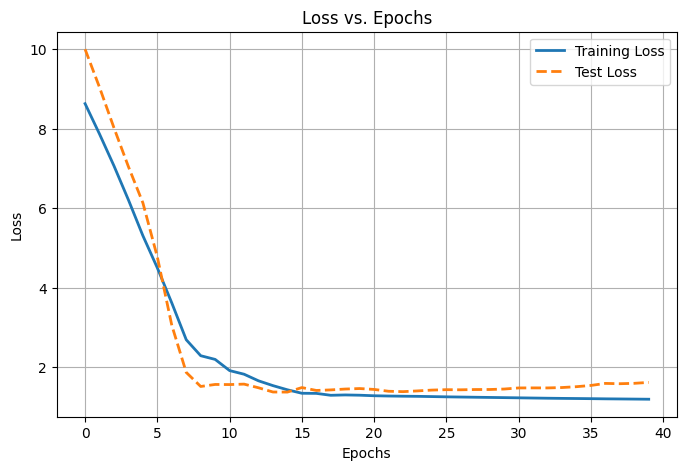

...done!
 
Training model 7/20...

Epoch   5: train error = 6.9616 test error = 7.6422 -
Epoch  10: train error = 2.3364 test error = 1.5805 -
Epoch  15: train error = 1.6922 test error = 1.7168 +
Epoch  20: train error = 1.5083 test error = 1.5814 +
Epoch  25: train error = 1.4095 test error = 1.6504 +
Epoch  30: train error = 1.3392 test error = 1.8421 +
Epoch  35: train error = 1.2755 test error = 1.8451 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.5805327543440908

Epoch   5: train error = 9.2984 test error = 4.7143 -
Epoch  10: train error = 2.7776 test error = 2.8920 -
Epoch  15: train error = 1.8189 test error = 2.2213 -
Epoch  20: train error = 1.4936 test error = 1.8942 -
Epoch  25: train error = 1.4303 test error = 1.9213 +
Epoch  30: train error = 1.3919 test error = 1.9147 +
Epoch  35: train error = 1.3440 test error = 1.8999 +
Epoch  40: train error = 1.2939 test error = 1.8472 -
Epoch  45: train error = 1.2349 test error = 1.8160 -
Epoch  50: tra

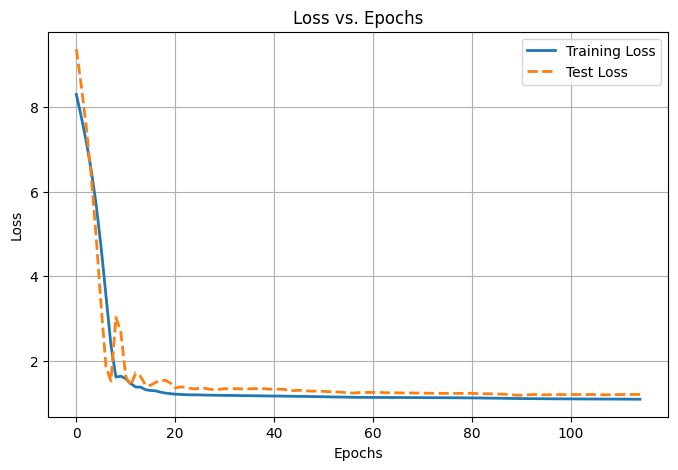

...done!
 
Training model 8/20...

Epoch   5: train error = 7.8225 test error = 7.1165 -
Epoch  10: train error = 2.9551 test error = 1.5528 -
Epoch  15: train error = 1.7155 test error = 1.3070 -
Epoch  20: train error = 1.4655 test error = 1.3679 +
Epoch  25: train error = 1.4151 test error = 1.2825 -
Epoch  30: train error = 1.3876 test error = 1.3164 +
Epoch  35: train error = 1.3500 test error = 1.4173 +
Epoch  40: train error = 1.3184 test error = 1.4095 +
Epoch  45: train error = 1.2856 test error = 1.4711 +
Epoch  50: train error = 1.2753 test error = 1.4472 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.2825156700253741

Epoch   5: train error = 6.8418 test error = 5.4230 -
Epoch  10: train error = 2.6255 test error = 2.0343 -
Epoch  15: train error = 1.5268 test error = 1.4839 -
Epoch  20: train error = 1.1875 test error = 1.5117 +
Epoch  25: train error = 1.1034 test error = 1.5268 +
Epoch  30: train error = 1.0548 test error = 1.5459 +
Epoch  35: tra

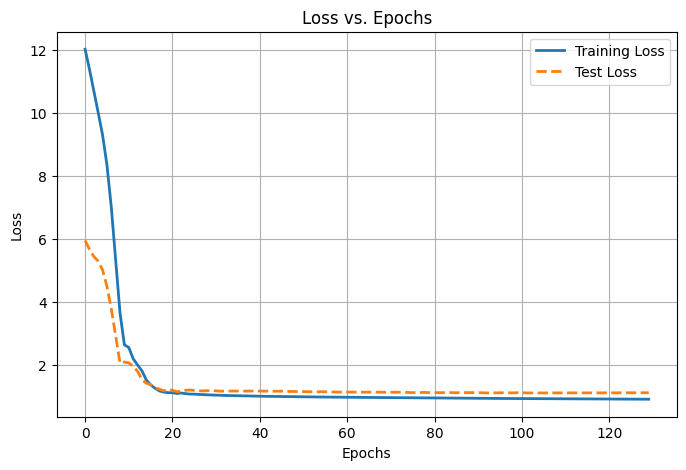

...done!
 
Training model 9/20...

Epoch   5: train error = 5.9668 test error = 5.9650 -
Epoch  10: train error = 2.2039 test error = 1.8521 -
Epoch  15: train error = 1.3756 test error = 1.4921 -
Epoch  20: train error = 1.1632 test error = 1.2460 -
Epoch  25: train error = 1.1049 test error = 1.1766 -
Epoch  30: train error = 1.0803 test error = 1.1942 +
Epoch  35: train error = 1.0624 test error = 1.1890 +
Epoch  40: train error = 1.0408 test error = 1.1807 +
Epoch  45: train error = 1.0131 test error = 1.2129 +
Epoch  50: train error = 0.9843 test error = 1.2360 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.1766463114035381

Epoch   5: train error = 10.3094 test error = 4.6903 -
Epoch  10: train error = 5.0376 test error = 3.4078 -
Epoch  15: train error = 1.7644 test error = 2.2436 -
Epoch  20: train error = 1.4100 test error = 1.6568 -
Epoch  25: train error = 1.3773 test error = 1.6283 -
Epoch  30: train error = 1.3481 test error = 1.6125 -
Epoch  35: tr

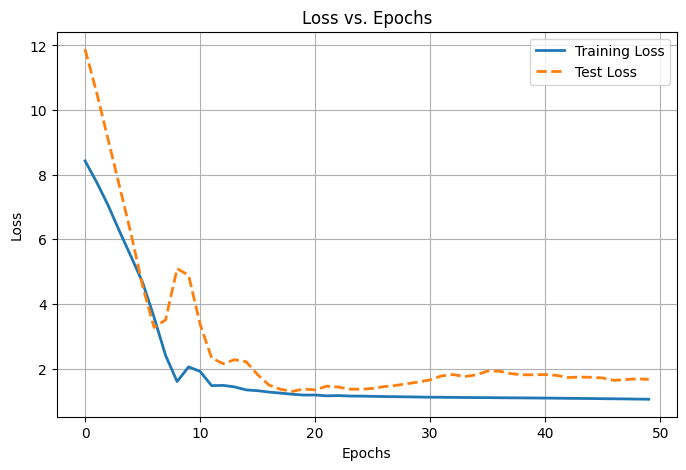

...done!
 
Training model 10/20...

Epoch   5: train error = 6.6693 test error = 4.1065 -
Epoch  10: train error = 2.4530 test error = 1.1979 -
Epoch  15: train error = 1.9867 test error = 1.2337 +
Epoch  20: train error = 1.7612 test error = 1.3609 +
Epoch  25: train error = 1.6757 test error = 1.3969 +
Epoch  30: train error = 1.6125 test error = 1.5020 +
Epoch  35: train error = 1.5636 test error = 1.5138 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.197864304632413

Epoch   5: train error = 6.8441 test error = 8.3691 -
Epoch  10: train error = 2.1726 test error = 2.8990 -
Epoch  15: train error = 1.8303 test error = 1.8862 -
Epoch  20: train error = 1.6368 test error = 1.8671 -
Epoch  25: train error = 1.5899 test error = 1.8554 -
Epoch  30: train error = 1.5658 test error = 1.8578 +
Epoch  35: train error = 1.5472 test error = 1.8768 +
Epoch  40: train error = 1.5246 test error = 1.8939 +
Epoch  45: train error = 1.5024 test error = 1.9073 +
Epoch  50: tra

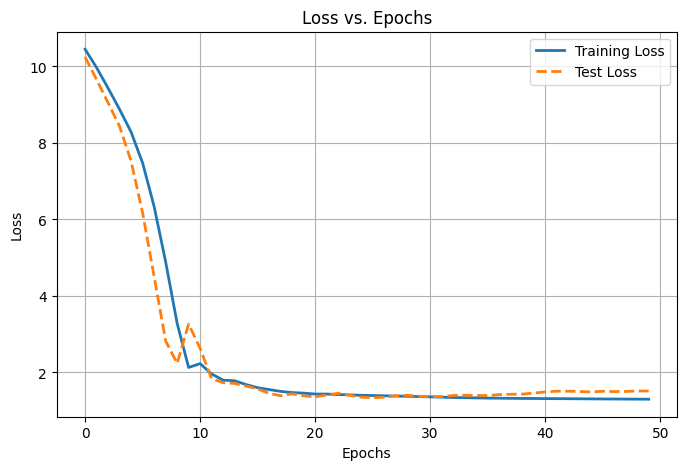

...done!
 
Training model 11/20...

Epoch   5: train error = 6.4021 test error = 6.4746 -
Epoch  10: train error = 2.0108 test error = 2.2725 -
Epoch  15: train error = 1.4860 test error = 1.7007 -
Epoch  20: train error = 1.3633 test error = 1.6788 -
Epoch  25: train error = 1.2754 test error = 1.8584 +
Epoch  30: train error = 1.2286 test error = 1.8186 +
Epoch  35: train error = 1.1921 test error = 1.9113 +
Epoch  40: train error = 1.1521 test error = 1.9676 +
Epoch  45: train error = 1.1330 test error = 2.0534 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.6788365178951128

Epoch   5: train error = 6.4918 test error = 9.0904 -
Epoch  10: train error = 2.4718 test error = 2.0298 -
Epoch  15: train error = 1.4805 test error = 1.5079 -
Epoch  20: train error = 1.2962 test error = 1.5150 +
Epoch  25: train error = 1.2443 test error = 1.5096 +
Epoch  30: train error = 1.2294 test error = 1.5165 +
Epoch  35: train error = 1.2182 test error = 1.5275 +
Epoch  40: tr

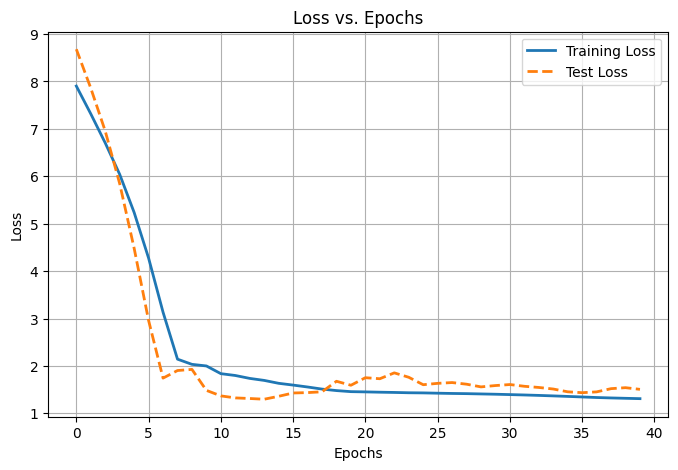

...done!
 
Training model 12/20...

Epoch   5: train error = 5.7765 test error = 4.2514 -
Epoch  10: train error = 2.4237 test error = 2.1912 -
Epoch  15: train error = 1.5933 test error = 1.7587 -
Epoch  20: train error = 1.4693 test error = 1.7882 +
Epoch  25: train error = 1.4129 test error = 1.7965 +
Epoch  30: train error = 1.3807 test error = 1.8328 +
Epoch  35: train error = 1.3497 test error = 1.8582 +
Epoch  40: train error = 1.3240 test error = 1.8194 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.7587417518586692

Epoch   5: train error = 7.5558 test error = 8.8708 -
Epoch  10: train error = 2.1732 test error = 2.5147 -
Epoch  15: train error = 1.4898 test error = 2.1934 -
Epoch  20: train error = 1.4511 test error = 2.3277 +
Epoch  25: train error = 1.3981 test error = 2.3543 +
Epoch  30: train error = 1.3815 test error = 2.4200 +
Epoch  35: train error = 1.3620 test error = 2.4085 +
Epoch  40: train error = 1.3399 test error = 2.4357 +
No improvemen

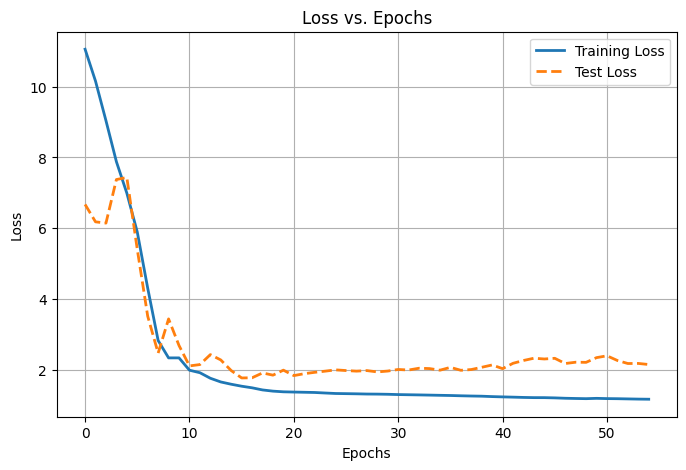

...done!
 
Training model 13/20...

Epoch   5: train error = 5.4455 test error = 5.6968 -
Epoch  10: train error = 1.9258 test error = 2.5268 -
Epoch  15: train error = 1.4018 test error = 1.9893 -
Epoch  20: train error = 1.1418 test error = 1.8128 -
Epoch  25: train error = 1.0769 test error = 1.8641 +
Epoch  30: train error = 1.0486 test error = 1.8096 -
Epoch  35: train error = 1.0290 test error = 1.7958 -
Epoch  40: train error = 1.0108 test error = 1.7322 -
Epoch  45: train error = 0.9980 test error = 1.7436 +
Epoch  50: train error = 0.9887 test error = 1.7280 -
Epoch  55: train error = 0.9743 test error = 1.7062 -
Epoch  60: train error = 0.9673 test error = 1.7448 +
Epoch  65: train error = 0.9590 test error = 1.7372 +
Epoch  70: train error = 0.9435 test error = 1.7499 +
Epoch  75: train error = 0.9319 test error = 1.7594 +
Epoch  80: train error = 0.9260 test error = 1.7481 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.7062152416438017

Epoch   5: tr

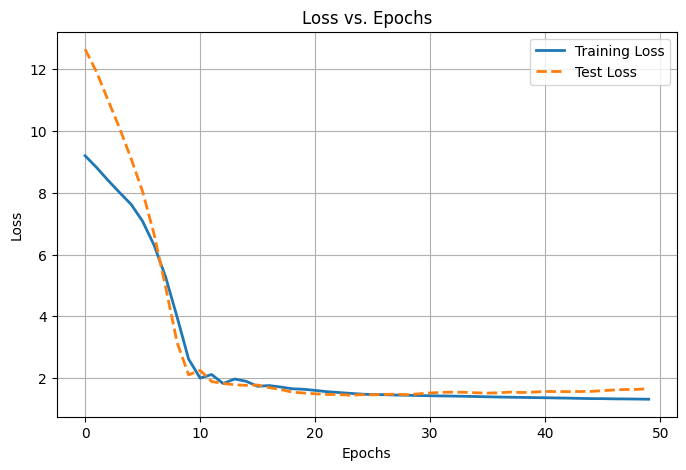

...done!
 
Training model 14/20...

Epoch   5: train error = 5.6333 test error = 4.9194 -
Epoch  10: train error = 2.2823 test error = 2.6159 -
Epoch  15: train error = 1.7514 test error = 2.4077 -
Epoch  20: train error = 1.5903 test error = 2.2215 -
Epoch  25: train error = 1.5406 test error = 2.1172 -
Epoch  30: train error = 1.5119 test error = 2.1674 +
Epoch  35: train error = 1.4822 test error = 2.1716 +
Epoch  40: train error = 1.4472 test error = 2.1767 +
Epoch  45: train error = 1.4021 test error = 2.2303 +
Epoch  50: train error = 1.3689 test error = 2.3371 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 2.11723094875702

Epoch   5: train error = 9.2509 test error = 5.4850 -
Epoch  10: train error = 2.4501 test error = 2.6518 -
Epoch  15: train error = 1.8347 test error = 1.5716 -
Epoch  20: train error = 1.3028 test error = 1.3775 -
Epoch  25: train error = 1.2036 test error = 1.3860 +
Epoch  30: train error = 1.1295 test error = 1.3795 +
Epoch  35: trai

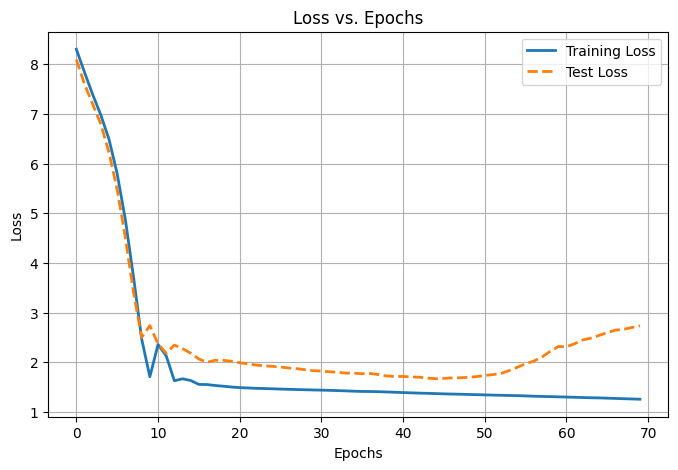

...done!
 
Training model 15/20...

Epoch   5: train error = 8.8823 test error = 4.9946 -
Epoch  10: train error = 2.2081 test error = 1.3607 -
Epoch  15: train error = 1.6240 test error = 1.4504 +
Epoch  20: train error = 1.4311 test error = 1.3984 +
Epoch  25: train error = 1.3875 test error = 1.4134 +
Epoch  30: train error = 1.3417 test error = 1.4170 +
Epoch  35: train error = 1.3091 test error = 1.4189 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.3607020816429247

Epoch   5: train error = 7.1766 test error = 6.0737 -
Epoch  10: train error = 1.7360 test error = 1.6174 -
Epoch  15: train error = 1.6280 test error = 1.2499 -
Epoch  20: train error = 1.4512 test error = 1.2284 -
Epoch  25: train error = 1.3930 test error = 1.3815 +
Epoch  30: train error = 1.3565 test error = 1.4444 +
Epoch  35: train error = 1.3319 test error = 1.5164 +
Epoch  40: train error = 1.3098 test error = 1.5824 +
Epoch  45: train error = 1.2940 test error = 1.6686 +
No improvemen

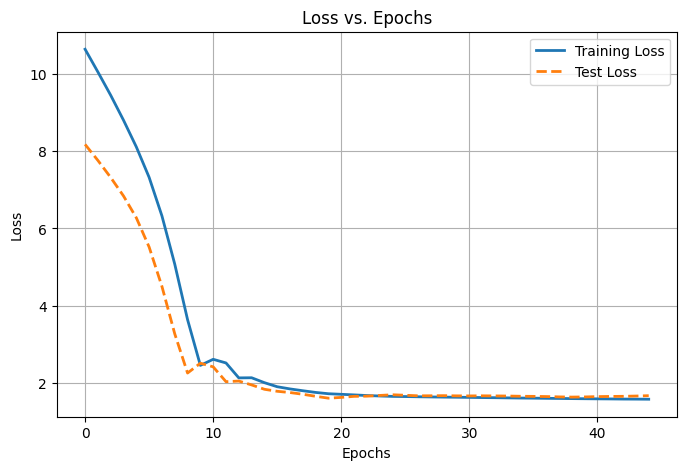

...done!
 
Training model 16/20...

Epoch   5: train error = 6.2592 test error = 5.1861 -
Epoch  10: train error = 2.4009 test error = 2.7003 -
Epoch  15: train error = 1.6582 test error = 1.4848 -
Epoch  20: train error = 1.4825 test error = 1.0156 -
Epoch  25: train error = 1.4439 test error = 0.9287 -
Epoch  30: train error = 1.3953 test error = 0.9366 +
Epoch  35: train error = 1.3334 test error = 0.9823 +
Epoch  40: train error = 1.2825 test error = 1.1485 +
Epoch  45: train error = 1.2594 test error = 1.1934 +
Epoch  50: train error = 1.2456 test error = 1.2066 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 0.9287349204377651

Epoch   5: train error = 5.7754 test error = 5.8787 -
Epoch  10: train error = 1.8963 test error = 1.7807 -
Epoch  15: train error = 1.2548 test error = 1.7391 -
Epoch  20: train error = 1.1086 test error = 1.5887 -
Epoch  25: train error = 1.0488 test error = 1.5533 -
Epoch  30: train error = 1.0162 test error = 1.5389 -
Epoch  35: tr

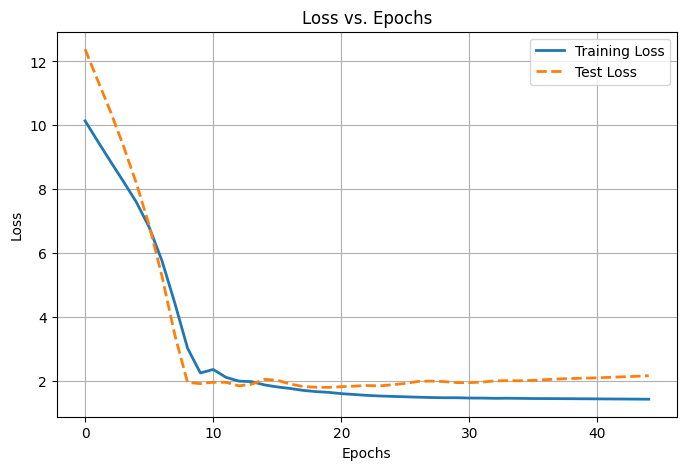

...done!
 
Training model 17/20...

Epoch   5: train error = 6.8658 test error = 4.9059 -
Epoch  10: train error = 1.9679 test error = 2.1884 -
Epoch  15: train error = 1.1417 test error = 1.9857 -
Epoch  20: train error = 1.1228 test error = 2.0803 +
Epoch  25: train error = 1.0775 test error = 2.0620 +
Epoch  30: train error = 1.0581 test error = 2.0510 +
Epoch  35: train error = 1.0404 test error = 2.0086 +
Epoch  40: train error = 1.0298 test error = 2.0261 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.985748653251025

Epoch   5: train error = 7.5923 test error = 4.1464 -
Epoch  10: train error = 2.4008 test error = 2.9070 -
Epoch  15: train error = 1.6130 test error = 2.0903 -
Epoch  20: train error = 1.4021 test error = 1.9680 -
Epoch  25: train error = 1.3739 test error = 1.8993 -
Epoch  30: train error = 1.3503 test error = 1.8695 -
Epoch  35: train error = 1.3258 test error = 1.9246 +
Epoch  40: train error = 1.2887 test error = 2.3416 +
Epoch  45: tra

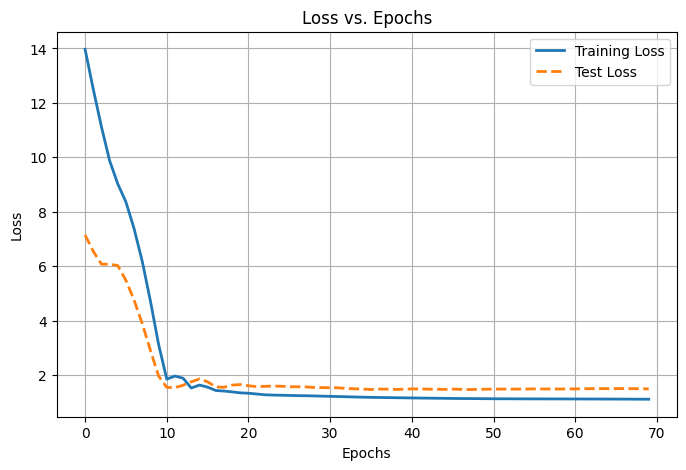

...done!
 
Training model 18/20...

Epoch   5: train error = 5.1332 test error = 6.6068 -
Epoch  10: train error = 1.9298 test error = 5.2283 -
Epoch  15: train error = 1.4064 test error = 3.3982 -
Epoch  20: train error = 1.3076 test error = 2.5963 -
Epoch  25: train error = 1.2187 test error = 2.0352 -
Epoch  30: train error = 1.1515 test error = 1.7322 -
Epoch  35: train error = 1.1195 test error = 1.6212 -
Epoch  40: train error = 1.0913 test error = 1.6597 +
Epoch  45: train error = 1.0573 test error = 1.7266 +
Epoch  50: train error = 1.0326 test error = 1.8133 +
Epoch  55: train error = 1.0217 test error = 1.8555 +
Epoch  60: train error = 1.0116 test error = 1.8709 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.6211668408655766

Epoch   5: train error = 7.9368 test error = 7.4196 -
Epoch  10: train error = 2.1795 test error = 1.9845 -
Epoch  15: train error = 1.8251 test error = 1.9278 -
Epoch  20: train error = 1.5913 test error = 1.9307 +
Epoch  25: tr

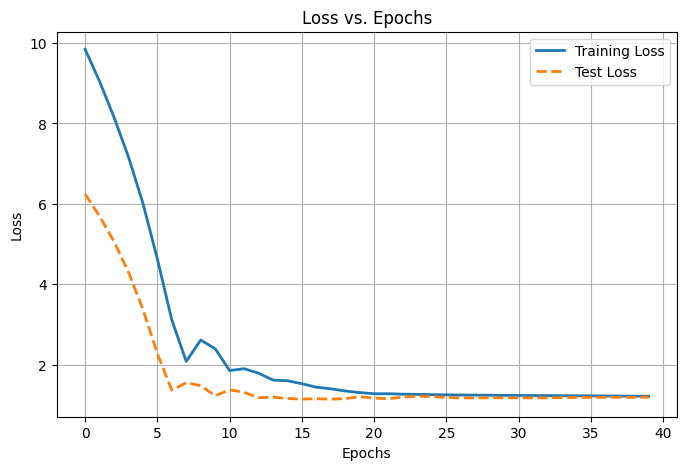

...done!
 
Training model 19/20...

Epoch   5: train error = 4.1455 test error = 8.5819 -
Epoch  10: train error = 2.1144 test error = 2.7540 -
Epoch  15: train error = 1.6606 test error = 2.2831 -
Epoch  20: train error = 1.4529 test error = 2.2427 -
Epoch  25: train error = 1.4074 test error = 2.2434 +
Epoch  30: train error = 1.3659 test error = 2.2858 +
Epoch  35: train error = 1.3406 test error = 2.4790 +
Epoch  40: train error = 1.3208 test error = 2.5542 +
Epoch  45: train error = 1.3040 test error = 2.5136 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 2.2427239657031737

Epoch   5: train error = 6.7470 test error = 4.5660 -
Epoch  10: train error = 2.4069 test error = 3.3199 -
Epoch  15: train error = 1.5841 test error = 2.1550 -
Epoch  20: train error = 1.3406 test error = 2.2924 +
Epoch  25: train error = 1.2582 test error = 2.7447 +
Epoch  30: train error = 1.2204 test error = 2.7369 +
Epoch  35: train error = 1.1891 test error = 2.7120 +
Epoch  40: tr

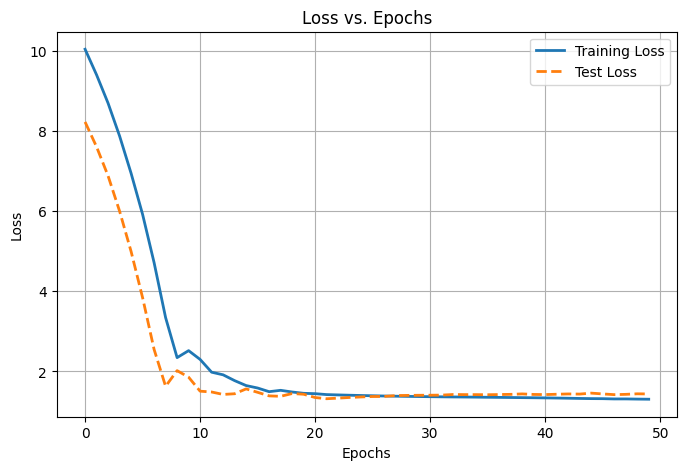

...done!
 
Training model 20/20...

Epoch   5: train error = 6.6718 test error = 4.7027 -
Epoch  10: train error = 2.1661 test error = 1.9311 -
Epoch  15: train error = 1.3860 test error = 0.8789 -
Epoch  20: train error = 1.2855 test error = 0.8217 -
Epoch  25: train error = 1.2389 test error = 0.8402 +
Epoch  30: train error = 1.2134 test error = 0.8631 +
Epoch  35: train error = 1.1823 test error = 0.9019 +
Epoch  40: train error = 1.1650 test error = 0.8591 +
Epoch  45: train error = 1.1419 test error = 0.8370 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 0.821686644372882

Epoch   5: train error = 5.7687 test error = 6.6014 -
Epoch  10: train error = 1.8915 test error = 2.6466 -
Epoch  15: train error = 1.4787 test error = 2.4120 -
Epoch  20: train error = 1.2784 test error = 2.1759 -
Epoch  25: train error = 1.2048 test error = 2.3672 +
Epoch  30: train error = 1.1601 test error = 2.3849 +
Epoch  35: train error = 1.1265 test error = 2.4471 +
Epoch  40: tra

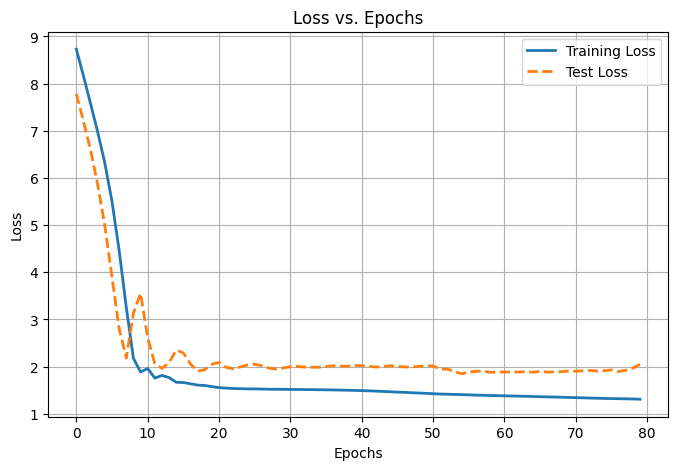

...done!
 
CPU times: user 5h 43min 10s, sys: 1min 19s, total: 5h 44min 29s
Wall time: 5h 46min 11s


In [111]:
%%time
# Define ensemble training
ensembleSize = 20  # Number of models in the ensemble

# Loop over the ensembles:
for i in range(1,1+ensembleSize):
    print(f"Training model {i}/{ensembleSize}...")

    f = NeuralFitter(fitpoints, th2, nnets=10, nbatch=50, batchlen=5, regularization='L1', lx_lambda=0.001)
    #f = g.fitter.NeuralFitter(fitpoints, th, nnets=10, nbatch=50, batchlen=2, regularization=None)
    f.fit()
    torch.save(th2.nn_model.state_dict(), f'Test2_nets_{i}.pt')

    # Plot the results:
    plt.figure(figsize=(8, 5))
    plt.plot(f.history, label="Training Loss",linewidth=2.0)
    plt.plot(f.test_history, label="Test Loss", linestyle="dashed",linewidth=2.0)
    plt.xlabel("Epochs") #Epochs in nbatch length
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    print("...done!")
    print(" ")

### Train a Classifier Ensemble 

In [121]:
# Collect the ensemble predictions on the test data:
ensemble_predictions = []
ensembleSize = 20 

# Set the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Access individual trained networks


for i in range(1,1+ensembleSize):
    current_model = th2.nn_model.to(device)
#for i, net in enumerate(th.nets):  # Loop over neural networks
    current_state_dict = torch.load(f'Test2_nets_{i}.pt', map_location=device) 
    current_model.load_state_dict(current_state_dict, strict=False)
    current_model.eval()  # Set to evaluation mode
    
    current_predictions = current_model(torch.as_tensor(Data_points, dtype=torch.float32))
    ensemble_predictions.append(current_predictions.detach().cpu().numpy())  # Convert to NumPy for analysis

ensemble_predictions = np.stack(ensemble_predictions)  # Shape: (num_models, num_data_points, num_outputs)
print(ensemble_predictions.shape)

(20, 172, 2)


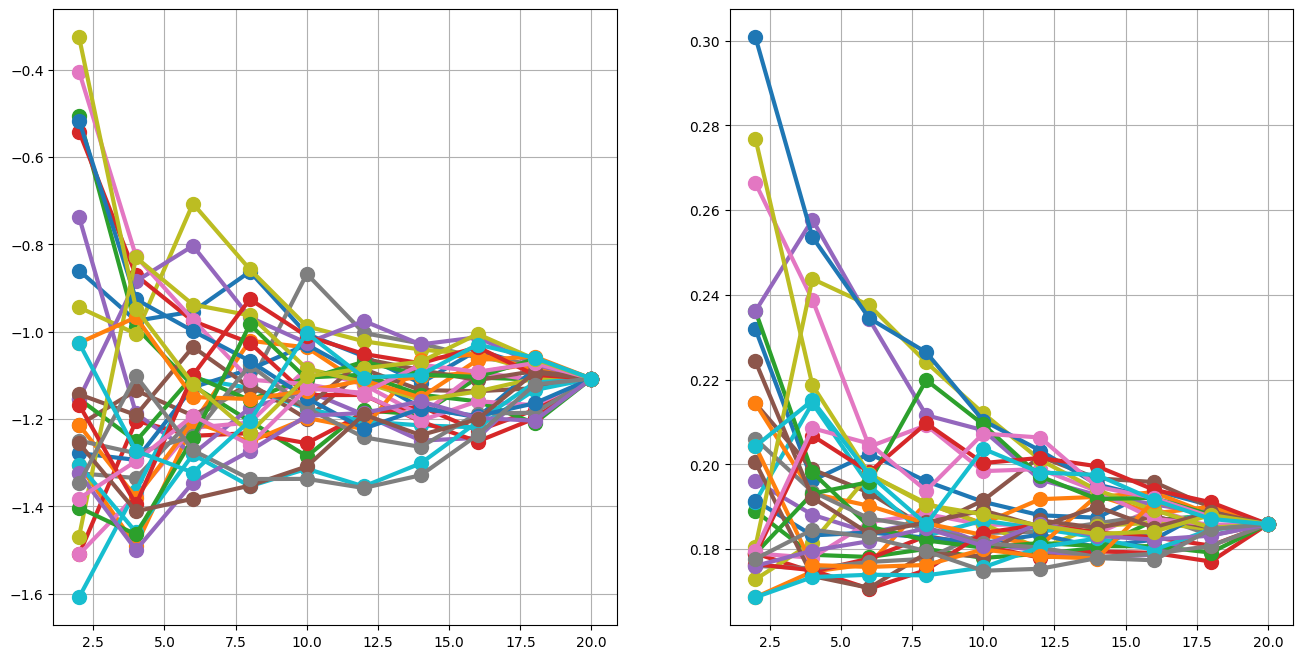

In [122]:
# Function to remove entries from array:
def remove_entries(a, n):
    if n < a.shape[0]:
        removed_entries = np.random.choice(a.shape[0], n, replace=False)
        return np.delete(a, removed_entries, axis=0), True
    return a, False

# Get residuals from ensemble predictions:
def get_residuals(ensemble_predictions, y_true, current_idx):
    residual = y_true - np.mean(ensemble_predictions[current_idx], axis=0)
    r_mean = np.mean(residual, axis=0)
    r_std = np.std(residual, axis=0)
    return np.mean(r_mean), np.mean(r_std)

# Evaluate ensemble performance:
def evaluate_ensemble(ensemble_predictions, y_true, n_remove, n_trials):
    ensemble_size = ensemble_predictions.shape[0]
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    for _ in range(n_trials):
        residuals_mean = []
        residuals_std = []
        sizes = [ensemble_size]

        keep_removing = True
        idx = np.arange(ensemble_size)
        res = get_residuals(ensemble_predictions, y_true, idx)
        residuals_mean.append(res[0])
        residuals_std.append(res[1])

        while keep_removing:
            new_idx, keep_removing = remove_entries(idx, n_remove)
            if keep_removing:
                res = get_residuals(ensemble_predictions, y_true, new_idx)
                residuals_mean.append(res[0])
                residuals_std.append(res[1])
                sizes.append(new_idx.shape[0])

            idx = new_idx

        ax[0].plot(sizes, residuals_mean, '-o', linewidth=3.0, markersize=10)
        ax[0].grid(True)
        ax[1].plot(sizes, residuals_std, '-o', linewidth=3.0, markersize=10)
        ax[1].grid(True)

evaluate_ensemble(ensemble_predictions, Data_pointsy, 2, 30)

In [115]:
th2.chisq(fitpoints)

(np.float64(64.74535803607783), 172, np.float64(0.9999999999999957))

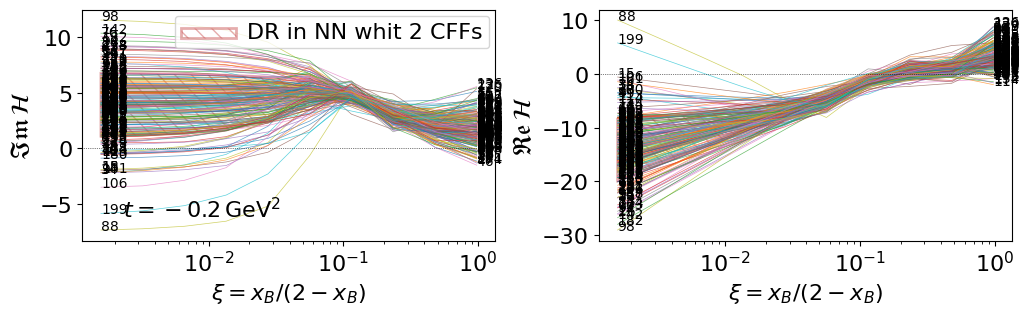

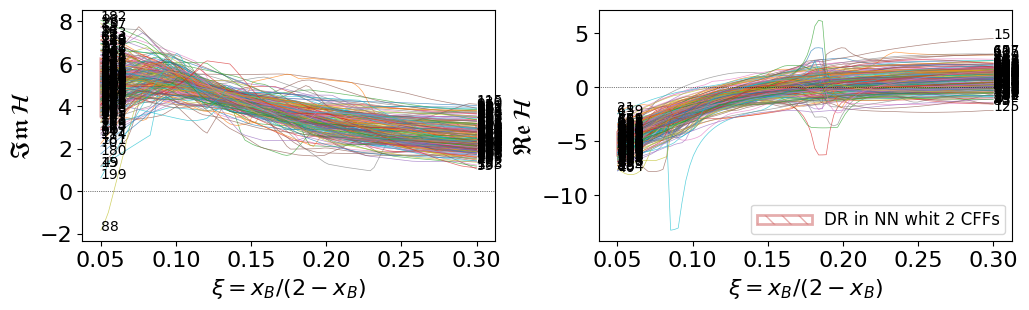

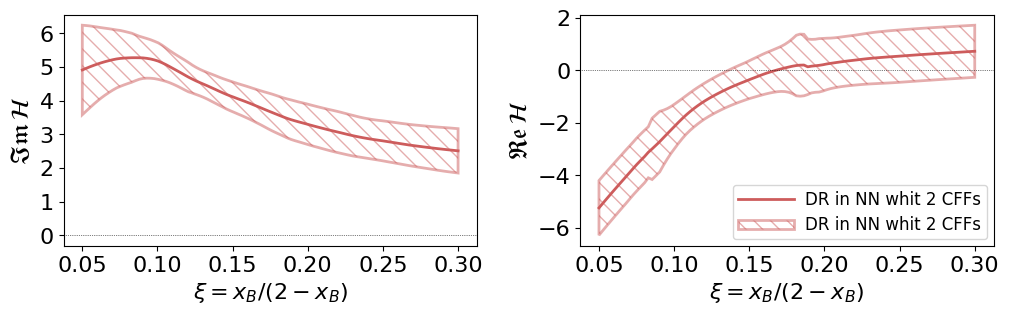

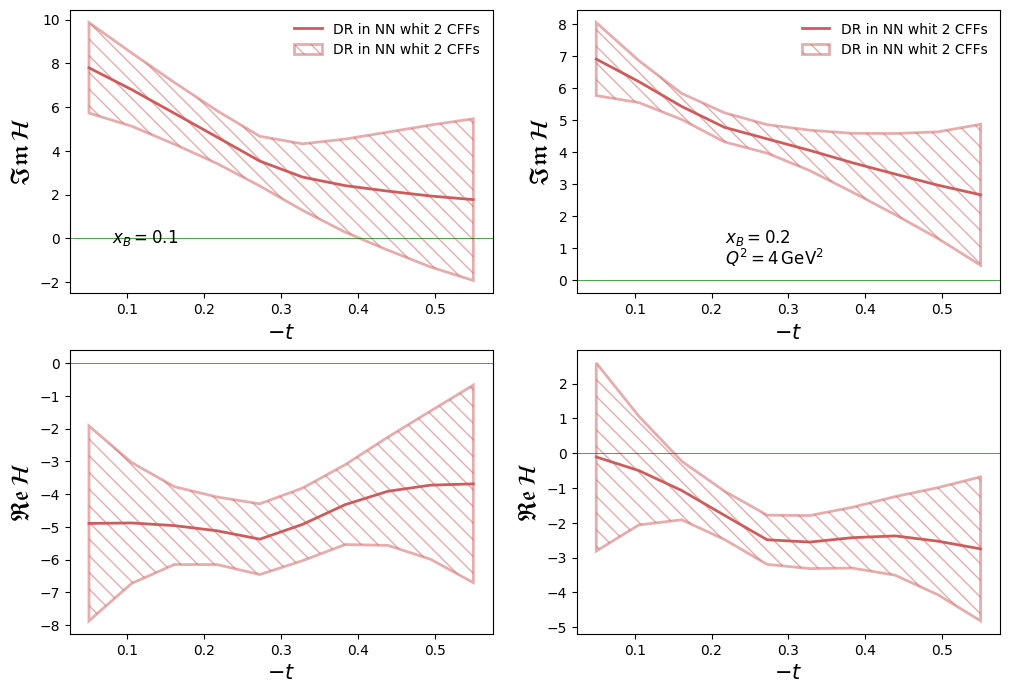

In [ ]:
th2.name = "Dispersion relation in NN"
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th2], bands=[th2])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th2], bands=[th2])

In [125]:
th2.name = "DR in NN whit 2 CFFs"
D = []
std_values = [] #!
net_indices = [] #!

print("\n---- [{} - {}] ----".format(th2.name, th2.description))
A = []
for pt in ptts[::-1]:
    Ds = []
    for i, net in enumerate(th2.nets):  # Loop over neural networks
        th2.nn_model, th2.nn_mean, th2.nn_std = net  # Assign neural net parameters
            
        Ds.append(float(th2.m.subtraction(pt).detach().numpy()*18./25.))
        #print(float(-th.m.subtraction(pt).detach().numpy()*18./25.))
        th2.cffs_evaluated = False
    net_indices.append(i)
        #for k in range(len(th.m.nets)):
        #th.m.parameters['nnet'] = k
        # NOTE: subtraction in code is equal to -\Delta(t) !
        #Ds.append(-th.m.subtraction(pt).detach().numpy()*18./25.) 
        #print(-th.m.subtraction(pt).detach().numpy()*18./25.)
    Ds = np.array(Ds)
    D_std = Ds.std() #!
    std_values.append(D_std) #!

    print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
    A.append((pt.tm, Ds.mean(), Ds.std()))
th2.m.parameters['nnet'] = 'ALL'    
D.append(A)


---- [DR in NN whit 2 CFFs - N/A] ----
0.185, -0.5: -1.0747354611195623 +- 1.472531012721969
0.185, -0.4555555555555556: -1.0261086793616414 +- 1.227292452152578
0.185, -0.4111111111111111: -0.9080833459738642 +- 1.0061704670899951
0.185, -0.3666666666666667: -0.7572951656021177 +- 0.8570632707962957
0.185, -0.32222222222222224: -0.5896543505328009 +- 0.7476724632660268
0.185, -0.2777777777777778: -0.5154893786902539 +- 0.6821600959184432
0.185, -0.23333333333333334: -0.7941482260357589 +- 0.758234949039164
0.185, -0.18888888888888888: -1.1611718191206455 +- 0.9662935601504308
0.185, -0.14444444444444446: -1.578931254753843 +- 1.2532281241065113
0.185, -0.1: -2.0033235867414625 +- 1.7309378699362288


/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_13862/1330471368.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ds.append(float(th2.m.subtraction(pt).detach().numpy()*18./25.))


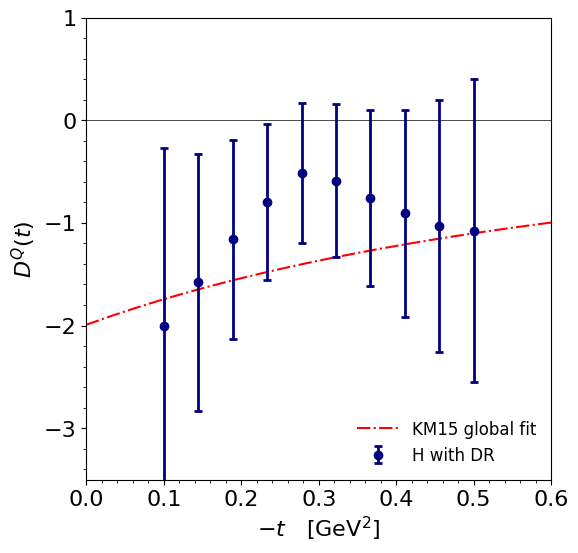

In [126]:
NPTS = 20
ts = np.linspace(0, 0.6, NPTS)
KMS = np.array([-(18./25.)*2.768/(1.+tm/1.204**2)**2 for tm in ts])
CDS = np.array(D[0])
#CADS = np.array(D[1])
fig, ax = plt.subplots(1, 1,  figsize=[6,6])
ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
ax.plot(ts, KMS, 'r-.', label='KM15 global fit')
ax.errorbar(CDS[:,0], CDS[:,1], CDS[:,2], linestyle='None', color='navy',
            elinewidth=2, capsize=3, capthick=2, marker='o', label='H with DR')
#ax.errorbar(CADS[:,0,]+0.01, CADS[:,1], CADS[:,2], linestyle='None', elinewidth=2,
#            capsize=3, capthick=2, marker='o', color='indianred', label='H and E with DR')

ax.set_xlim(0.0, 0.6)
ax.set_ylim(-3.5, 1)
ax.legend(loc=4, handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(0)
ax.set_xlabel(r'$-t \quad [{\rm GeV}^2]$', fontsize=16)
ax.set_ylabel(r'$D^{Q}(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)) 
ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.02)) 
ax.yaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(1.)) 
ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.2)) 

# Fitting with None regularization 

In [127]:
th3 = NNTest_DR(output_layer=['ImH', 'D'])
th3.name = 'fit'

Training model 1/15...


/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/model.py:399: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),



Epoch   5: train error = 6.3799 test error = 5.9763 -
Epoch  10: train error = 2.1411 test error = 3.0485 -
Epoch  15: train error = 1.4553 test error = 2.2228 -
Epoch  20: train error = 1.2268 test error = 1.7322 -
Epoch  25: train error = 1.1677 test error = 1.6103 -
Epoch  30: train error = 1.1089 test error = 1.6311 +
Epoch  35: train error = 1.0720 test error = 1.6435 +
Epoch  40: train error = 1.0432 test error = 1.6787 +
Epoch  45: train error = 1.0050 test error = 1.7106 +
Epoch  50: train error = 0.9789 test error = 1.6931 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.6103262204748954

Epoch   5: train error = 7.0078 test error = 5.5306 -
Epoch  10: train error = 2.0121 test error = 1.3083 -
Epoch  15: train error = 1.2458 test error = 1.4238 +
Epoch  20: train error = 1.1615 test error = 1.3753 +
Epoch  25: train error = 1.1262 test error = 1.3987 +
Epoch  30: train error = 1.1018 test error = 1.4175 +
Epoch  35: train error = 1.0803 test error = 1.4

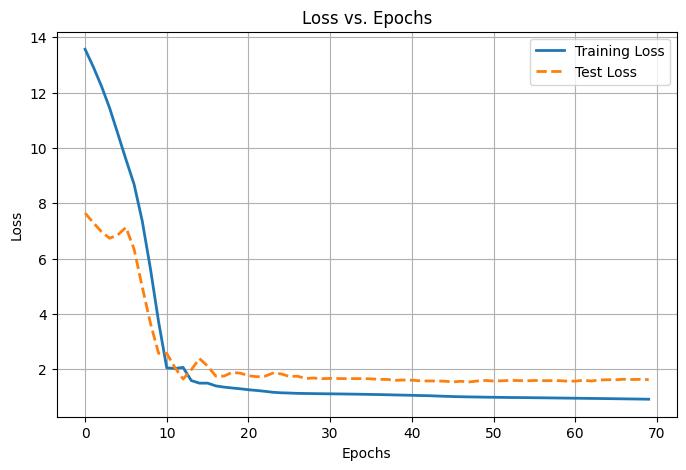

...done!
 
Training model 2/15...

Epoch   5: train error = 8.3098 test error = 5.5722 -
Epoch  10: train error = 3.0213 test error = 2.7344 -
Epoch  15: train error = 2.1213 test error = 2.0620 -
Epoch  20: train error = 1.9338 test error = 1.6311 -
Epoch  25: train error = 1.7890 test error = 1.3962 -
Epoch  30: train error = 1.7504 test error = 1.4499 +
Epoch  35: train error = 1.7191 test error = 1.4565 +
Epoch  40: train error = 1.6825 test error = 1.4226 +
Epoch  45: train error = 1.6507 test error = 1.3963 +
Epoch  50: train error = 1.6273 test error = 1.3869 -
Epoch  55: train error = 1.5974 test error = 1.3548 -
Epoch  60: train error = 1.5724 test error = 1.3060 -
Epoch  65: train error = 1.5484 test error = 1.2836 -
Epoch  70: train error = 1.5222 test error = 1.2600 -
Epoch  75: train error = 1.4992 test error = 1.2944 +
Epoch  80: train error = 1.4774 test error = 1.2893 +
Epoch  85: train error = 1.4530 test error = 1.2836 +
Epoch  90: train error = 1.4309 test error = 1.

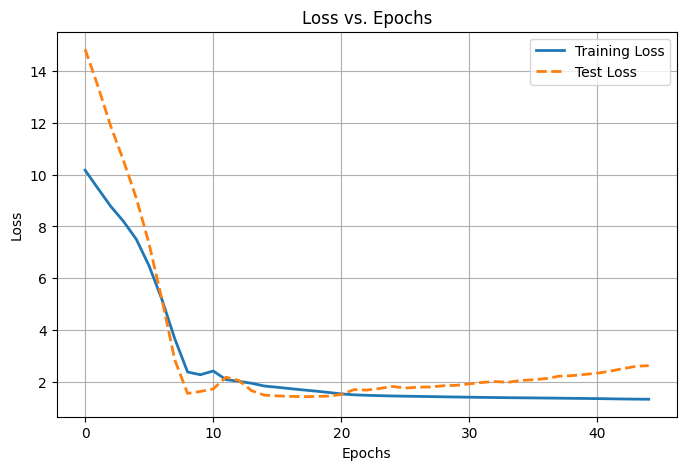

...done!
 
Training model 3/15...

Epoch   5: train error = 7.1317 test error = 6.7589 -
Epoch  10: train error = 2.2091 test error = 3.3314 -
Epoch  15: train error = 1.6422 test error = 1.6945 -
Epoch  20: train error = 1.4449 test error = 1.4253 -
Epoch  25: train error = 1.4034 test error = 1.5122 +
Epoch  30: train error = 1.3546 test error = 1.5868 +
Epoch  35: train error = 1.3295 test error = 1.6094 +
Epoch  40: train error = 1.3149 test error = 1.5949 +
Epoch  45: train error = 1.3007 test error = 1.5595 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.425280735357209

Epoch   5: train error = 6.8704 test error = 4.0006 -
Epoch  10: train error = 2.4661 test error = 1.7688 -
Epoch  15: train error = 1.8153 test error = 1.4376 -
Epoch  20: train error = 1.6782 test error = 1.4671 +
Epoch  25: train error = 1.6048 test error = 1.4779 +
Epoch  30: train error = 1.5561 test error = 1.4423 +
Epoch  35: train error = 1.5120 test error = 1.4092 -
Epoch  40: trai

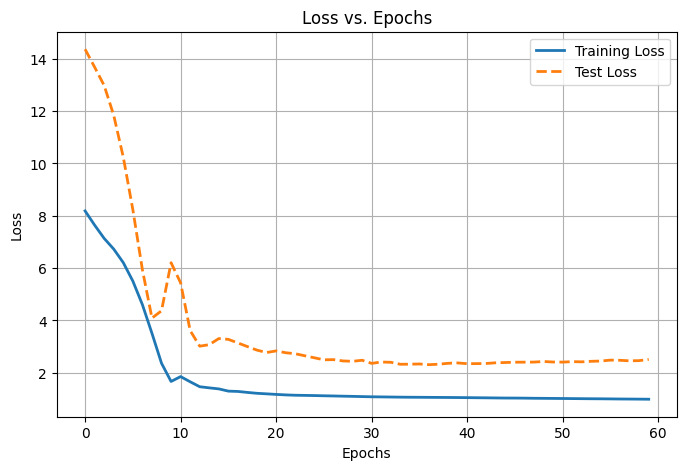

...done!
 
Training model 4/15...

Epoch   5: train error = 6.3428 test error = 6.9223 -
Epoch  10: train error = 2.2875 test error = 2.5130 -
Epoch  15: train error = 1.6737 test error = 2.0236 -
Epoch  20: train error = 1.4352 test error = 1.6613 -
Epoch  25: train error = 1.3173 test error = 1.6977 +
Epoch  30: train error = 1.2585 test error = 1.8332 +
Epoch  35: train error = 1.2058 test error = 1.8998 +
Epoch  40: train error = 1.1693 test error = 1.9500 +
Epoch  45: train error = 1.1426 test error = 1.9618 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.6613053544258372

Epoch   5: train error = 7.1874 test error = 6.7605 -
Epoch  10: train error = 2.1079 test error = 3.4216 -
Epoch  15: train error = 1.4200 test error = 2.1903 -
Epoch  20: train error = 1.2253 test error = 1.6310 -
Epoch  25: train error = 1.0707 test error = 1.2830 -
Epoch  30: train error = 1.0141 test error = 1.3490 +
Epoch  35: train error = 0.9890 test error = 1.3504 +
Epoch  40: tra

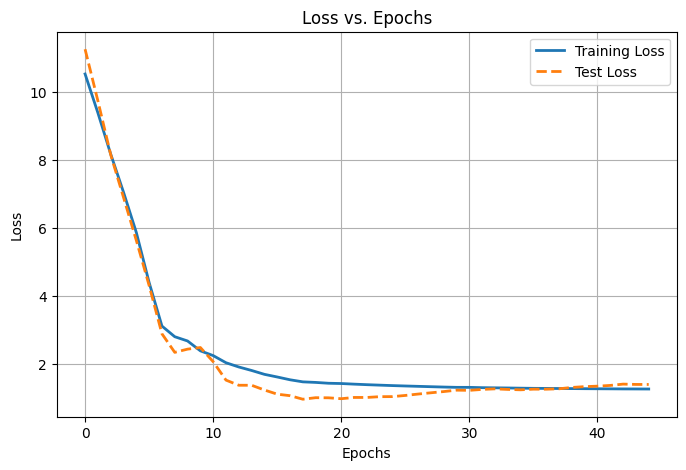

...done!
 
Training model 5/15...

Epoch   5: train error = 6.3176 test error = 6.3674 -
Epoch  10: train error = 2.5047 test error = 2.2351 -
Epoch  15: train error = 1.7194 test error = 1.5365 -
Epoch  20: train error = 1.4737 test error = 1.5411 +
Epoch  25: train error = 1.4244 test error = 1.6212 +
Epoch  30: train error = 1.3407 test error = 1.6910 +
Epoch  35: train error = 1.2354 test error = 1.7307 +
Epoch  40: train error = 1.2248 test error = 1.7357 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.536544062333032

Epoch   5: train error = 7.6385 test error = 9.1751 -
Epoch  10: train error = 3.0045 test error = 2.7928 -
Epoch  15: train error = 1.8576 test error = 1.8612 -
Epoch  20: train error = 1.4211 test error = 1.9210 +
Epoch  25: train error = 1.3275 test error = 1.9508 +
Epoch  30: train error = 1.2755 test error = 2.0509 +
Epoch  35: train error = 1.2367 test error = 2.0987 +
Epoch  40: train error = 1.1982 test error = 2.3054 +
No improvement 

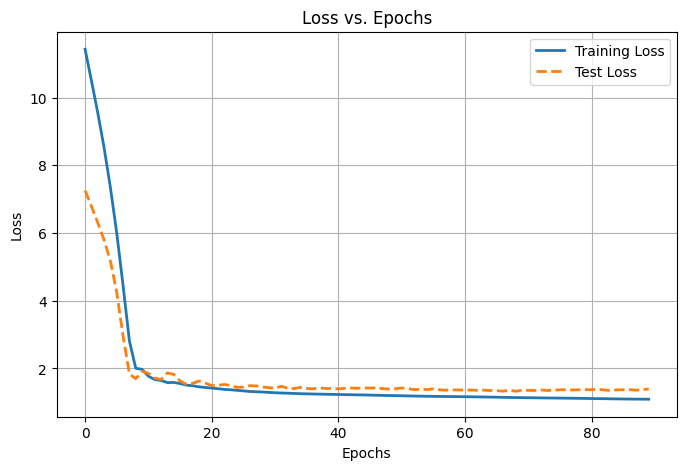

...done!
 
Training model 6/15...

Epoch   5: train error = 5.4564 test error = 6.0833 -
Epoch  10: train error = 1.9803 test error = 1.7245 -
Epoch  15: train error = 1.6037 test error = 1.6352 -
Epoch  20: train error = 1.5266 test error = 1.8422 +
Epoch  25: train error = 1.4962 test error = 1.8042 +
Epoch  30: train error = 1.4859 test error = 1.8471 +
Epoch  35: train error = 1.4781 test error = 1.8531 +
Epoch  40: train error = 1.4693 test error = 1.8629 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.6351943514118115

Epoch   5: train error = 8.2983 test error = 4.4740 -
Epoch  10: train error = 3.2775 test error = 1.7363 -
Epoch  15: train error = 1.9068 test error = 1.3664 -
Epoch  20: train error = 1.5163 test error = 1.2953 -
Epoch  25: train error = 1.4709 test error = 1.3121 +
Epoch  30: train error = 1.4396 test error = 1.3358 +
Epoch  35: train error = 1.4233 test error = 1.3016 +
Epoch  40: train error = 1.4135 test error = 1.2810 -
Epoch  45: tra

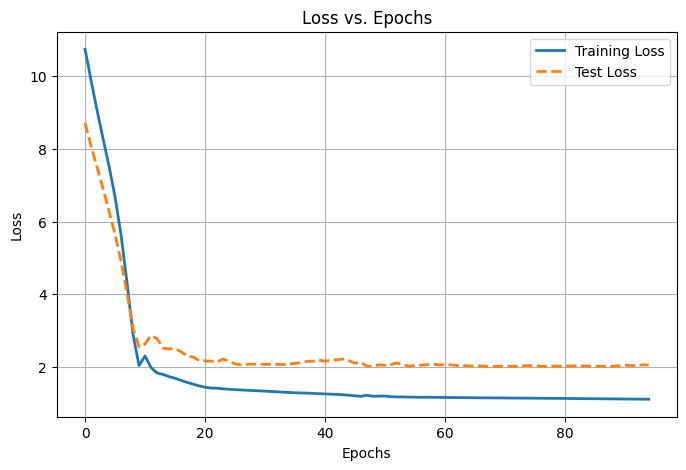

...done!
 
Training model 7/15...

Epoch   5: train error = 5.8623 test error = 8.8832 -
Epoch  10: train error = 2.1648 test error = 4.3369 -
Epoch  15: train error = 2.0660 test error = 2.4864 -
Epoch  20: train error = 1.7402 test error = 1.9382 -
Epoch  25: train error = 1.5448 test error = 1.5918 -
Epoch  30: train error = 1.4663 test error = 1.6470 +
Epoch  35: train error = 1.4125 test error = 1.6885 +
Epoch  40: train error = 1.3775 test error = 1.7102 +
Epoch  45: train error = 1.3282 test error = 1.7302 +
Epoch  50: train error = 1.3066 test error = 1.7916 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.591839647727946

Epoch   5: train error = 7.4896 test error = 7.0899 -
Epoch  10: train error = 1.9598 test error = 1.2662 -
Epoch  15: train error = 1.9744 test error = 1.7975 +
Epoch  20: train error = 1.7322 test error = 1.4621 +
Epoch  25: train error = 1.6939 test error = 1.4480 +
Epoch  30: train error = 1.6611 test error = 1.4727 +
Epoch  35: trai

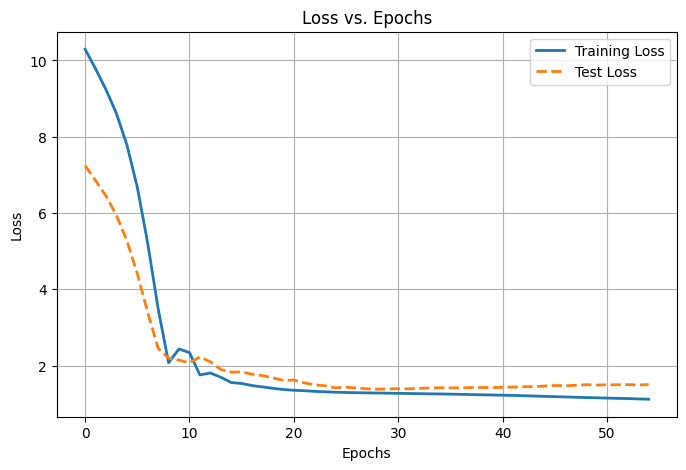

...done!
 
Training model 8/15...

Epoch   5: train error = 6.5280 test error = 8.2834 -
Epoch  10: train error = 2.0596 test error = 1.7245 -
Epoch  15: train error = 1.3940 test error = 1.7033 -
Epoch  20: train error = 1.2049 test error = 1.4620 -
Epoch  25: train error = 1.1662 test error = 1.5440 +
Epoch  30: train error = 1.1379 test error = 1.6523 +
Epoch  35: train error = 1.1190 test error = 1.7125 +
Epoch  40: train error = 1.0904 test error = 1.7572 +
Epoch  45: train error = 1.0617 test error = 1.8008 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.4620169245390298

Epoch   5: train error = 5.7537 test error = 9.3989 -
Epoch  10: train error = 1.9106 test error = 3.7677 -
Epoch  15: train error = 1.5549 test error = 1.8785 -
Epoch  20: train error = 1.3247 test error = 1.8326 -
Epoch  25: train error = 1.2032 test error = 1.9778 +
Epoch  30: train error = 1.1618 test error = 2.1594 +
Epoch  35: train error = 1.1299 test error = 2.0701 +
Epoch  40: tra

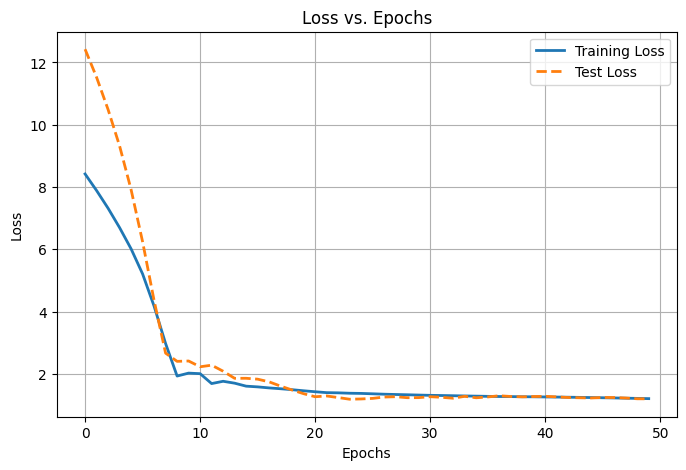

...done!
 
Training model 9/15...

Epoch   5: train error = 8.7062 test error = 4.3950 -
Epoch  10: train error = 1.6813 test error = 1.5104 -
Epoch  15: train error = 1.3811 test error = 1.3110 -
Epoch  20: train error = 1.2554 test error = 1.3246 +
Epoch  25: train error = 1.2283 test error = 1.3403 +
Epoch  30: train error = 1.2115 test error = 1.3145 +
Epoch  35: train error = 1.1896 test error = 1.3240 +
Epoch  40: train error = 1.1635 test error = 1.3557 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.3109599918348407

Epoch   5: train error = 6.2341 test error = 13.0428 -
Epoch  10: train error = 2.6278 test error = 2.6715 -
Epoch  15: train error = 1.7829 test error = 1.8412 -
Epoch  20: train error = 1.5805 test error = 1.4608 -
Epoch  25: train error = 1.5126 test error = 1.4649 +
Epoch  30: train error = 1.4463 test error = 1.5358 +
Epoch  35: train error = 1.4081 test error = 1.6055 +
Epoch  40: train error = 1.3824 test error = 1.6964 +
Epoch  45: tr

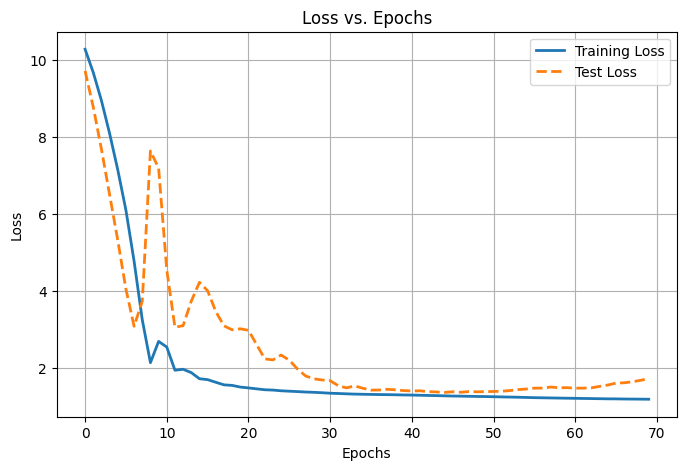

...done!
 
Training model 10/15...

Epoch   5: train error = 5.7608 test error = 6.8127 -
Epoch  10: train error = 2.0176 test error = 2.3164 -
Epoch  15: train error = 1.4861 test error = 2.0125 -
Epoch  20: train error = 1.3045 test error = 1.6783 -
Epoch  25: train error = 1.2413 test error = 1.6335 -
Epoch  30: train error = 1.2037 test error = 1.6989 +
Epoch  35: train error = 1.1790 test error = 1.7117 +
Epoch  40: train error = 1.1676 test error = 1.7459 +
Epoch  45: train error = 1.1607 test error = 1.7624 +
Epoch  50: train error = 1.1571 test error = 1.7489 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.6335156540820652

Epoch   5: train error = 8.0087 test error = 6.6067 -
Epoch  10: train error = 2.1821 test error = 4.9299 -
Epoch  15: train error = 1.6425 test error = 2.9714 -
Epoch  20: train error = 1.4580 test error = 1.9387 -
Epoch  25: train error = 1.3774 test error = 1.4010 -
Epoch  30: train error = 1.3261 test error = 1.2877 -
Epoch  35: tr

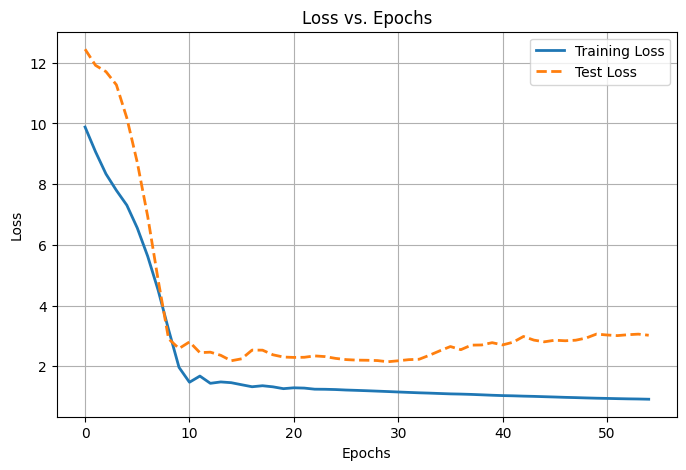

...done!
 
Training model 11/15...

Epoch   5: train error = 7.9317 test error = 5.2684 -
Epoch  10: train error = 2.0129 test error = 1.1106 -
Epoch  15: train error = 1.6787 test error = 1.0503 -
Epoch  20: train error = 1.4903 test error = 1.0189 -
Epoch  25: train error = 1.4297 test error = 1.0296 +
Epoch  30: train error = 1.4040 test error = 1.0567 +
Epoch  35: train error = 1.3802 test error = 1.0872 +
Epoch  40: train error = 1.3455 test error = 1.1370 +
Epoch  45: train error = 1.2982 test error = 1.3179 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.018856503104622

Epoch   5: train error = 7.5528 test error = 5.0105 -
Epoch  10: train error = 3.2126 test error = 1.9297 -
Epoch  15: train error = 2.0462 test error = 1.5288 -
Epoch  20: train error = 1.6872 test error = 1.5162 -
Epoch  25: train error = 1.6137 test error = 1.4508 -
Epoch  30: train error = 1.5836 test error = 1.3823 -
Epoch  35: train error = 1.5595 test error = 1.3617 -
Epoch  40: tra

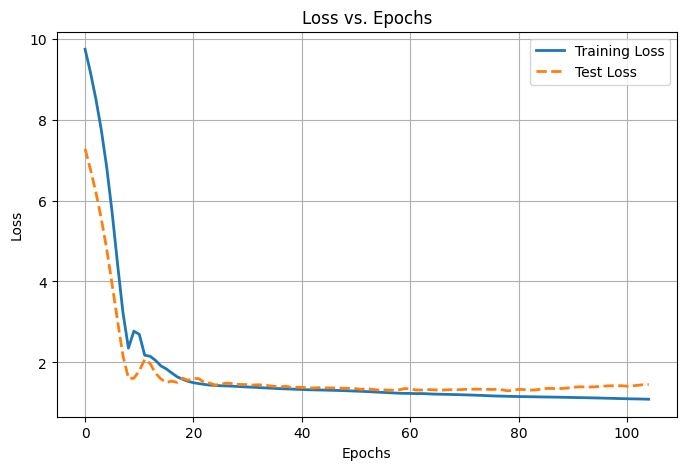

...done!
 
Training model 12/15...

Epoch   5: train error = 8.4166 test error = 4.0214 -
Epoch  10: train error = 2.9016 test error = 2.4626 -
Epoch  15: train error = 1.6385 test error = 1.4966 -
Epoch  20: train error = 1.2147 test error = 1.3461 -
Epoch  25: train error = 1.1649 test error = 1.3129 -
Epoch  30: train error = 1.1288 test error = 1.3455 +
Epoch  35: train error = 1.0923 test error = 1.4476 +
Epoch  40: train error = 1.0447 test error = 1.6517 +
Epoch  45: train error = 1.0298 test error = 1.7862 +
Epoch  50: train error = 1.0148 test error = 1.7601 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.3128671587903216

Epoch   5: train error = 7.5716 test error = 5.6633 -
Epoch  10: train error = 2.5742 test error = 3.5963 -
Epoch  15: train error = 1.9024 test error = 2.1631 -
Epoch  20: train error = 1.6240 test error = 1.9151 -
Epoch  25: train error = 1.5042 test error = 1.9096 -
Epoch  30: train error = 1.3916 test error = 2.1086 +
Epoch  35: tr

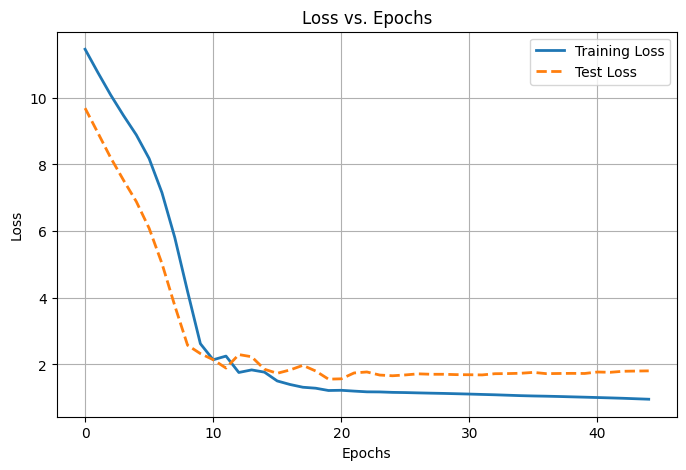

...done!
 
Training model 13/15...

Epoch   5: train error = 7.4589 test error = 9.1814 -
Epoch  10: train error = 2.6088 test error = 2.3386 -
Epoch  15: train error = 1.6904 test error = 2.1375 -
Epoch  20: train error = 1.5145 test error = 1.9599 -
Epoch  25: train error = 1.4097 test error = 1.9092 -
Epoch  30: train error = 1.3838 test error = 1.9175 +
Epoch  35: train error = 1.3595 test error = 1.9071 -
Epoch  40: train error = 1.3466 test error = 1.8938 -
Epoch  45: train error = 1.3302 test error = 1.8966 +
Epoch  50: train error = 1.3173 test error = 1.9164 +
Epoch  55: train error = 1.3063 test error = 1.9238 +
Epoch  60: train error = 1.2997 test error = 1.9622 +
Epoch  65: train error = 1.2934 test error = 2.0238 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.893797031849006

Epoch   5: train error = 6.2808 test error = 6.5146 -
Epoch  10: train error = 1.6720 test error = 1.9984 -
Epoch  15: train error = 1.7368 test error = 1.7825 -
Epoch  20: tra

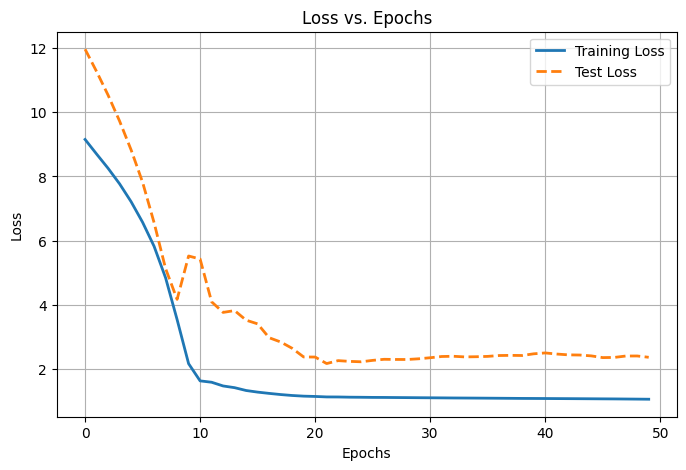

...done!
 
Training model 14/15...

Epoch   5: train error = 3.4618 test error = 4.9203 -
Epoch  10: train error = 1.8120 test error = 2.3688 -
Epoch  15: train error = 1.3729 test error = 1.5283 -
Epoch  20: train error = 1.2478 test error = 1.7636 +
Epoch  25: train error = 1.1871 test error = 1.5432 +
Epoch  30: train error = 1.1286 test error = 1.8700 +
Epoch  35: train error = 1.0888 test error = 2.3283 +
Epoch  40: train error = 1.0671 test error = 2.3210 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.528251159649307

Epoch   5: train error = 6.5212 test error = 6.1239 -
Epoch  10: train error = 1.6886 test error = 5.9786 -
Epoch  15: train error = 1.3646 test error = 3.9668 -
Epoch  20: train error = 1.2791 test error = 3.5318 -
Epoch  25: train error = 1.2370 test error = 3.4778 -
Epoch  30: train error = 1.2052 test error = 3.5907 +
Epoch  35: train error = 1.1800 test error = 3.4876 +
Epoch  40: train error = 1.1700 test error = 4.0364 +
Epoch  45: tra

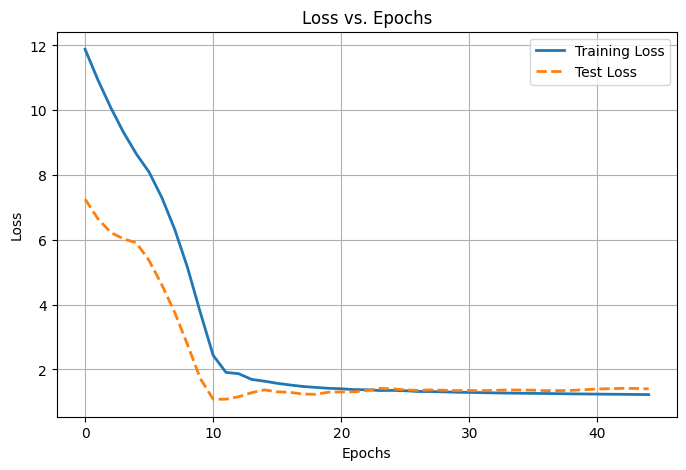

...done!
 
Training model 15/15...

Epoch   5: train error = 6.8682 test error = 5.9608 -
Epoch  10: train error = 2.2710 test error = 2.4518 -
Epoch  15: train error = 1.5424 test error = 1.7730 -
Epoch  20: train error = 1.4284 test error = 1.7477 -
Epoch  25: train error = 1.3536 test error = 1.7780 +
Epoch  30: train error = 1.3165 test error = 1.7850 +
Epoch  35: train error = 1.3005 test error = 1.7911 +
Epoch  40: train error = 1.2799 test error = 1.8204 +
Epoch  45: train error = 1.2637 test error = 1.8910 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.7477018668617392

Epoch   5: train error = 8.7250 test error = 3.2355 -
Epoch  10: train error = 2.8014 test error = 2.0184 -
Epoch  15: train error = 1.6179 test error = 1.8961 -
Epoch  20: train error = 1.4448 test error = 1.8567 -
Epoch  25: train error = 1.3474 test error = 1.9530 +
Epoch  30: train error = 1.3011 test error = 1.9253 +
Epoch  35: train error = 1.2701 test error = 1.8682 +
Epoch  40: tr

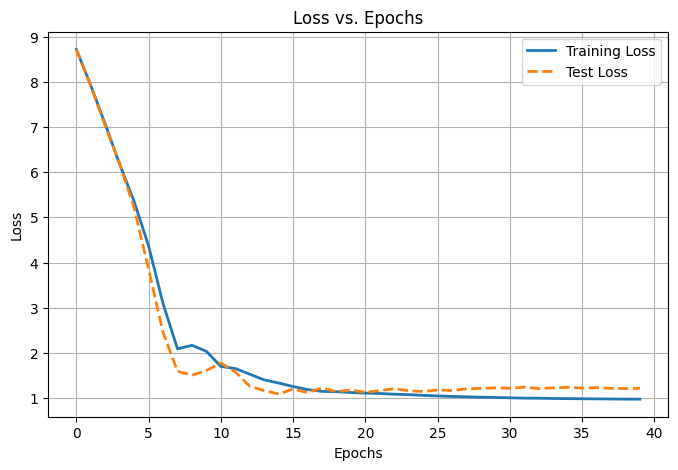

...done!
 
CPU times: user 4h 19min 20s, sys: 1min 17s, total: 4h 20min 38s
Wall time: 4h 22min 36s


In [128]:
%%time
# Define ensemble training
ensembleSize = 15  # Number of models in the ensemble

# Loop over the ensembles:
for i in range(1,1+ensembleSize):
    print(f"Training model {i}/{ensembleSize}...")

    f = NeuralFitter(fitpoints, th3, nnets=10, nbatch=50, batchlen=5, regularization=None, lx_lambda=0.001)
    #f = g.fitter.NeuralFitter(fitpoints, th, nnets=10, nbatch=50, batchlen=2, regularization=None)
    f.fit()
    torch.save(th3.nn_model.state_dict(), f'Test3_nets_{i}.pt')

    # Plot the results:
    plt.figure(figsize=(8, 5))
    plt.plot(f.history, label="Training Loss",linewidth=2.0)
    plt.plot(f.test_history, label="Test Loss", linestyle="dashed",linewidth=2.0)
    plt.xlabel("Epochs") #Epochs in nbatch length
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    print("...done!")
    print(" ")

In [129]:
# Collect the ensemble predictions on the test data:
ensemble_predictions = []
ensembleSize = 15 

# Set the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Access individual trained networks


for i in range(1,1+ensembleSize):
    current_model = th3.nn_model.to(device)
#for i, net in enumerate(th.nets):  # Loop over neural networks
    current_state_dict = torch.load(f'Test3_nets_{i}.pt', map_location=device) 
    current_model.load_state_dict(current_state_dict, strict=False)
    current_model.eval()  # Set to evaluation mode
    
    current_predictions = current_model(torch.as_tensor(Data_points, dtype=torch.float32))
    ensemble_predictions.append(current_predictions.detach().cpu().numpy())  # Convert to NumPy for analysis

ensemble_predictions = np.stack(ensemble_predictions)  # Shape: (num_models, num_data_points, num_outputs)
print(ensemble_predictions.shape)

(15, 172, 2)


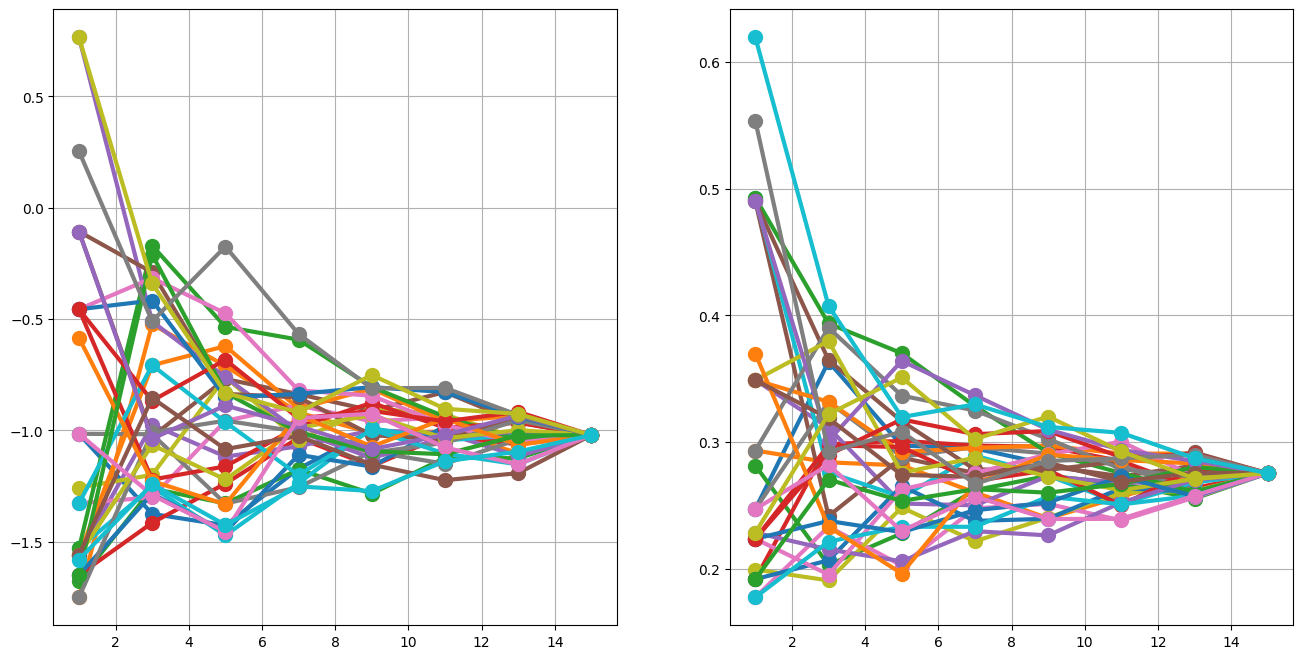

In [130]:
# Function to remove entries from array:
def remove_entries(a, n):
    if n < a.shape[0]:
        removed_entries = np.random.choice(a.shape[0], n, replace=False)
        return np.delete(a, removed_entries, axis=0), True
    return a, False

# Get residuals from ensemble predictions:
def get_residuals(ensemble_predictions, y_true, current_idx):
    residual = y_true - np.mean(ensemble_predictions[current_idx], axis=0)
    r_mean = np.mean(residual, axis=0)
    r_std = np.std(residual, axis=0)
    return np.mean(r_mean), np.mean(r_std)

# Evaluate ensemble performance:
def evaluate_ensemble(ensemble_predictions, y_true, n_remove, n_trials):
    ensemble_size = ensemble_predictions.shape[0]
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    for _ in range(n_trials):
        residuals_mean = []
        residuals_std = []
        sizes = [ensemble_size]

        keep_removing = True
        idx = np.arange(ensemble_size)
        res = get_residuals(ensemble_predictions, y_true, idx)
        residuals_mean.append(res[0])
        residuals_std.append(res[1])

        while keep_removing:
            new_idx, keep_removing = remove_entries(idx, n_remove)
            if keep_removing:
                res = get_residuals(ensemble_predictions, y_true, new_idx)
                residuals_mean.append(res[0])
                residuals_std.append(res[1])
                sizes.append(new_idx.shape[0])

            idx = new_idx

        ax[0].plot(sizes, residuals_mean, '-o', linewidth=3.0, markersize=10)
        ax[0].grid(True)
        ax[1].plot(sizes, residuals_std, '-o', linewidth=3.0, markersize=10)
        ax[1].grid(True)

evaluate_ensemble(ensemble_predictions, Data_pointsy, 2, 30)

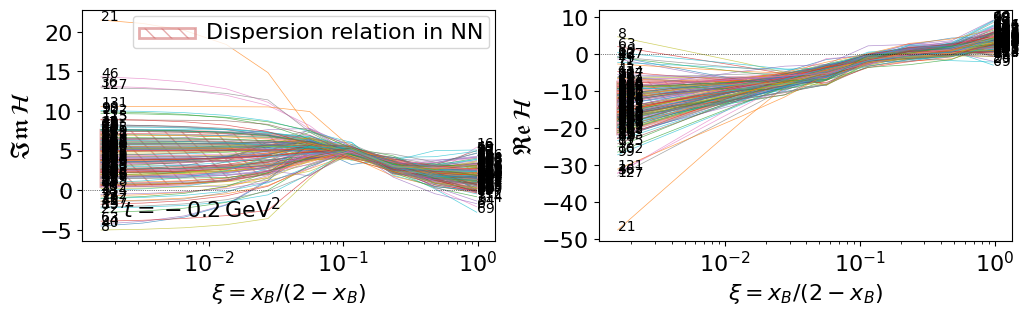

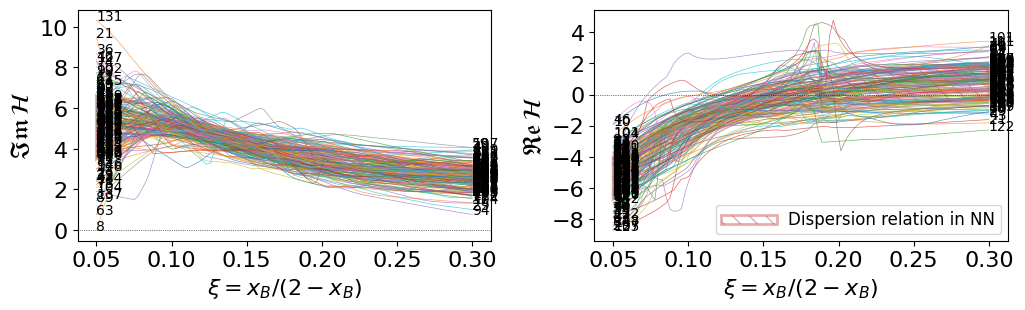

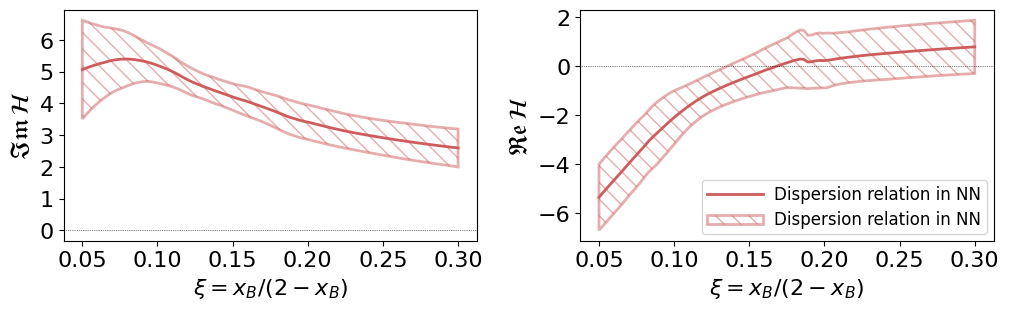

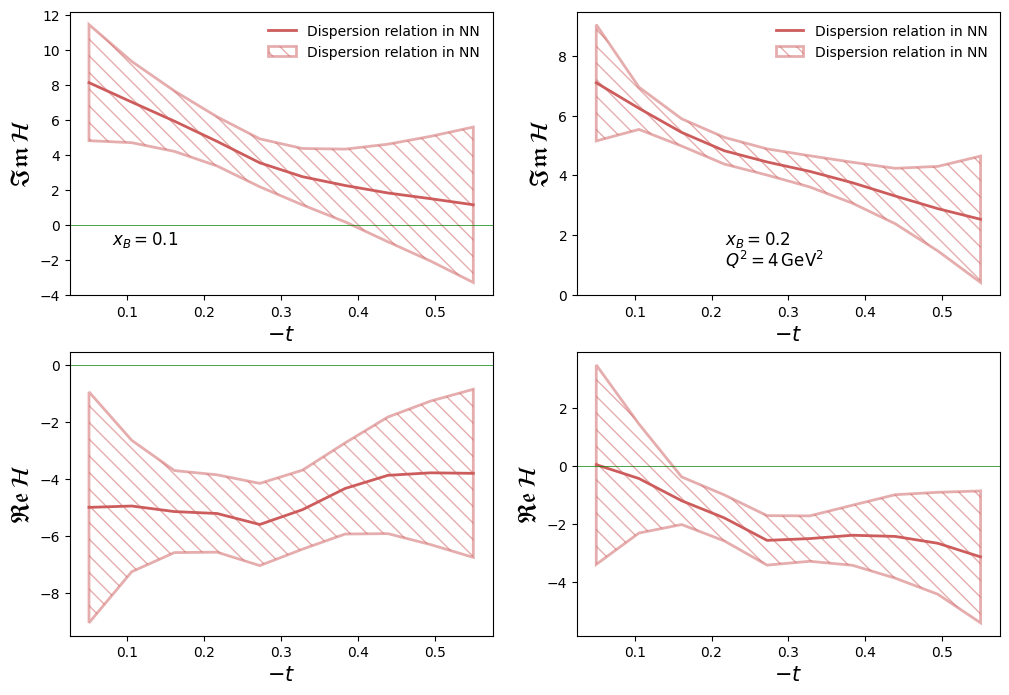

In [131]:
th3.name = "Dispersion relation in NN"
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th3, bands=[th3], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th3, bands=[th3])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th3], bands=[th3])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th3], bands=[th3])

In [132]:
th3.name = "DR in NN whit 2 CFFs"
D = []
std_values = [] #!
net_indices = [] #!

print("\n---- [{} - {}] ----".format(th3.name, th3.description))
A = []
for pt in ptts[::-1]:
    Ds = []
    for i, net in enumerate(th3.nets):  # Loop over neural networks
        th3.nn_model, th3.nn_mean, th3.nn_std = net  # Assign neural net parameters
            
        Ds.append(float(th3.m.subtraction(pt).detach().numpy()*18./25.))
        #print(float(-th.m.subtraction(pt).detach().numpy()*18./25.))
        th3.cffs_evaluated = False
    net_indices.append(i)
        #for k in range(len(th.m.nets)):
        #th.m.parameters['nnet'] = k
        # NOTE: subtraction in code is equal to -\Delta(t) !
        #Ds.append(-th.m.subtraction(pt).detach().numpy()*18./25.) 
        #print(-th.m.subtraction(pt).detach().numpy()*18./25.)
    Ds = np.array(Ds)
    D_std = Ds.std() #!
    std_values.append(D_std) #!

    print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
    A.append((pt.tm, Ds.mean(), Ds.std()))
th3.m.parameters['nnet'] = 'ALL'    
D.append(A)


---- [DR in NN whit 2 CFFs - N/A] ----
0.185, -0.5: -1.180437828116119 +- 1.653685762727284
0.185, -0.4555555555555556: -1.1700259594475695 +- 1.4951333028580565
0.185, -0.4111111111111111: -1.0311905608652159 +- 1.214266275787892
0.185, -0.3666666666666667: -0.8283214969187975 +- 0.9621915751909259
0.185, -0.32222222222222224: -0.5775908494430284 +- 0.7570542216347335
0.185, -0.2777777777777778: -0.4027628883618551 +- 0.7794270458932678
0.185, -0.23333333333333334: -0.7843812357789527 +- 0.7098243517154154
0.185, -0.18888888888888888: -1.1636370399547742 +- 0.9541161448081793
0.185, -0.14444444444444446: -1.5695910796771446 +- 1.2987996918922868
0.185, -0.1: -2.1441493092496726 +- 1.8956187803232125


/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_13862/680746165.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ds.append(float(th3.m.subtraction(pt).detach().numpy()*18./25.))


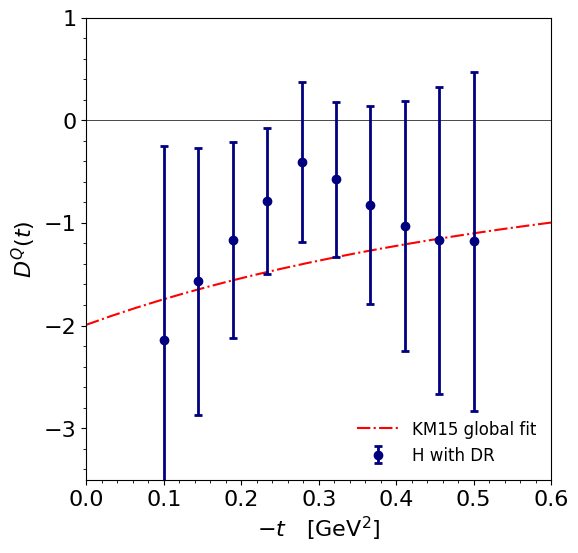

In [133]:
NPTS = 20
ts = np.linspace(0, 0.6, NPTS)
KMS = np.array([-(18./25.)*2.768/(1.+tm/1.204**2)**2 for tm in ts])
CDS = np.array(D[0])
#CADS = np.array(D[1])
fig, ax = plt.subplots(1, 1,  figsize=[6,6])
ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
ax.plot(ts, KMS, 'r-.', label='KM15 global fit')
ax.errorbar(CDS[:,0], CDS[:,1], CDS[:,2], linestyle='None', color='navy',
            elinewidth=2, capsize=3, capthick=2, marker='o', label='H with DR')
#ax.errorbar(CADS[:,0,]+0.01, CADS[:,1], CADS[:,2], linestyle='None', elinewidth=2,
#            capsize=3, capthick=2, marker='o', color='indianred', label='H and E with DR')

ax.set_xlim(0.0, 0.6)
ax.set_ylim(-3.5, 1)
ax.legend(loc=4, handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(0)
ax.set_xlabel(r'$-t \quad [{\rm GeV}^2]$', fontsize=16)
ax.set_ylabel(r'$D^{Q}(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)) 
ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.02)) 
ax.yaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(1.)) 
ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.2)) 